# Solar Production Data Analysis

## Objective
This notebook will analysis solar production data using the data science lifecyce outlined here: link
https://docs.google.com/document/d/1gKr6j7s02hjilNhqYrjDK7t6jqR092hzezn-MB09EZo/edit#heading=h.mbjsiz6n6jlo

## Contents:
1. Business Understanding
    
    In this section, I outline business goals that will be explored through following analysis.


2. Data Understanding

    In this section, I analyze some summary statistics of the dataset as a whole as well as each column of the dataset provided. I first go through the columns to ensure correct typings for data manipulation, then plot some overall distributions of size, production, etc., and generate a basic correlation matrix. Going deeper into the individual feature examination, I break down the distribution of each feature and try to find any missing, anomalous, or potentially concerning data. At the end of each feature section, I conduct either a regression for numeric variables or significance testing for categorical variables to determine whether or not they might affect performance. I generate individual estimates of yield and degradation per system and compare with the more generic yields and degradations given in the titled sections. I also examine low performance in the performance section and non-comms and weather-related loss in those sections.


3. Data Preparation

    The bulk of data processing is done when anomalies are encountered throughout the previous section. In this section, I do a bit of data manipulation converting categorical variables to dummy variables to allow us to work with them in numeric models. I also attempt to calculate an automated feature importance.


4. Modeling

    In this section, I generate 2 main models: an anomaly detection model and a predictive model. Within the anomaly detection section, I attempt 2 approaches and compare results from each method. First, I manually create a multivariate Gaussian distribution and generate p-values for each data point or observation, which I use to compare probabilities of occurence; those under a certain threshold are considered anomalous. Then, I use an automated isolation forest to output potentially anomalous data. For the predictive model, I use the predictors with sufficiently high correlation coefficients or significance values from section 2 to run a regression on performance and generate appropriate graphs.


5. Evaluation

    In this section, I re-evaluate business goals and consider how well they were met. I summarize results and outline some potential next steps.


6. Deployment

python version: 3.9.0

requirements:
see imports

## 0 Setup

### 0.1 Load Packages

In [1]:
import pandas as pd # pandas for data manipulation / analysis
import numpy as np # numpy for math
import matplotlib.pyplot as plt # pyplot for plotting and visualization
import datetime # datetime for computing times
import seaborn as sns # fancier plots
import statsmodels.api as statsmodels # for regression
from scipy import stats # more regression (and other statistics)
from sklearn import linear_model # regression model
from statsmodels.formula.api import ols # anova / significance testing
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, recall_score, \
precision_score, accuracy_score # for anomaly detection
from sklearn.ensemble import IsolationForest # for anomaly detection
from sklearn.model_selection import train_test_split # for predictive modeling
from sklearn.metrics import r2_score # for model tuning

from pylab import rcParams
rcParams['figure.figsize'] = 15, 8 # set figsize for all future plots

/Users/katherineli/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


### 0.2 Load Data

In [2]:
df_production = pd.read_csv('daily_contract_production.csv', header = None)
df_production.columns = ['holding_company_id', 'project_company_id', 'contract_id', 'size_kwdc', 'created_on', \
                'updated_on', 'production_date', 'ato_date', 'actual_kwh', 'expected_kwh', \
                'weather_adjusted_expected_kwh']
df_contracts = pd.read_csv('d_contracts.csv')

df = df_production.join(df_contracts.set_index('id'), on = 'contract_id', rsuffix="DROP").filter(regex="^(?!.*DROP)")

df.head()

,holding_company_id,project_company_id,contract_id,size_kwdc,created_on,updated_on,production_date,ato_date,actual_kwh,expected_kwh,...,host_type,revenue_type,interconnection_type,registry_facility_name,cref_short_name,subscriber_orginization,system_yield_as_built,system_yield_finance,annual_degradation_engr,annual_degradation_finance
0,15,44,4FbAzTVD,25.13,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-01 00:00:00.000000,2018-11-29,NaN,42.908097,...,C&I,NEM,NEM,NON241648,NaN,NaN,1131.0,1131.0,0.005,NaN
1,14,50,56XBWDhT,40.00,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-01 00:00:00.000000,2018-09-28,NaN,71.340590,...,C&I,NEM,NEM,NON241695,NaN,NaN,954.7,1170.0,0.005,0.005
2,28,71,5Q6T8Cm7,6.70,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-01 00:00:00.000000,2018-11-28,0.139945,12.643548,...,Residential,NEM,NEM,NON241642,NaN,NaN,1250.0,1250.0,0.005,0.005
3,14,43,8EaZmYXK,26.18,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-01 00:00:00.000000,2018-03-10,23.113000,50.342822,...,C&I,CREF,CREF,NON241367,NCS07,Arcadia,1240.8,1327.0,0.005,NaN
4,15,44,8GniqiNd,77.52,2021-02-24 03:49:53.575000,2021-02-24 03:53:14.940699,2019-01-01 00:00:00.000000,2018-07-12,NaN,142.074655,...,C&I,NEM,NEM,NON241708,NaN,NaN,1214.0,1214.0,0.005,NaN


## 1 Business Understanding
### Sections
#### 1.1 Question Definition
First, define your question(s) of interest from a business perspective. 
#### 1.2 Success Criteria
What is the goal of the project you propose, and what are the criteria for a successful or useful outcome? Assess the situation, including resources, constraints, assumptions, requirements. 
#### 1.3 Statistical Criteria 
Then, translate business objective(s) and metric(s) for success to data mining goals. If the business goal is to increase sales, the data mining goal might be to predict variance in sales based on advertising money spent, production costs, etc. 
#### 1.4 Project Plan
Finally, produce a project plan specifying the steps to be taken throughout the rest of the project, including initial assessment of tools and techniques, durations, dependencies, etc.

What is the goal of this project?
What are the criteria for a successful outcome?

Business goals are:
What will the production be of a new system?
What will the performance be of a new system?

Other questions to answer if time permits:
What is the quality of the data?
understand the fleet better - how many systems, when were they installed
indentify and predict poor performance?
how might we improve performance?
Can we predict future production?



Are all holding companies made equal?
Solar systems convert light energy from the sun to electricity. The amount of electricity produced is called "production" and the amount of electricity produced in reality compared to expectation is called "performance".
A commercial and residential solar installer is interested to learn if they can predict the production and performance of a new solar system.
They have provided data on the production and performance of their fleet with the hopes that it can be used as training data for a model.
Among other things, the model and analysis should tell them basic information, like growth of their fleet, average performance, and top performing systems, but also advanced statistics, like if the financial company is correlated to performance, which months are the best to install a new system, and what is the best estimation for annual degradation.

## 2 Data Understanding
### 2.1 List all datasets required
Collect initial data and list all datasets acquired, locations, methods of acquisition, and any problems encountered. 

Data were synthesized from 2 excel documents provided by Denny. These sheets were extracted from the solar database maintained by Denny using a SQL query. The first document, contained in the dataframe "data" above, contains core information on the production of solar contracts over time. It contains also contains descriptive data like the ato date of each system, its size, ownership, etc.  This "daily contract production" sheet is the third iteration after the first contained too many missing values, and the second contained only 4 columns. The SQL query used to extract these data was eventually fixed by Denny and another intern, Chris. The second document, extracted from the same database using a different SQL query, contains other, more detailed, decsriptive data like contract type, some financial info, estimated degradation rates, etc. There were no major problems with these data.

### 2.2 Gross properties of the data
 Describe the gross properties of the data, including its format, shape, field identities, etc.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84216 entries, 0 to 84215
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   holding_company_id             84216 non-null  int64  
 1   project_company_id             84216 non-null  int64  
 2   contract_id                    84216 non-null  object 
 3   size_kwdc                      84216 non-null  float64
 4   created_on                     84216 non-null  object 
 5   updated_on                     84148 non-null  object 
 6   production_date                84216 non-null  object 
 7   ato_date                       84216 non-null  object 
 8   actual_kwh                     80982 non-null  float64
 9   expected_kwh                   84216 non-null  float64
 10  weather_adjusted_expected_kwh  84216 non-null  float64
 11  site_id                        84216 non-null  int64  
 12  in_service_date                41423 non-null 

This dataset has 23 columns and 84,215 rows.

Holding and project company ids refer to the company that financed and owns/operates a system respectively, while contract ids  provide a unique identifier for each solar system. These should be objects or strings as they are unique identifiers, not data types that can be compared. 

Solar system sizes are also provided in units of kilowatts DC and describe the production capacity of a system.

Created on and updated on dates are relevant mostly for database management rather than describing any feature of the solar systems themselves, so they should not be relevant to this analysis.

Production date (the day of operation), ato date (the first day a system was licensed / legally allowed to go into production), and in-service date (the first day a system was actually turned on and started producing power) should be, as evident, dates. Notably, while production and ato dates are known for all data points included, in-service date only exists for around half. Thus, it may be appropriate to sub in ato dates where in-service dates are missing.

'actual_kwh', 'expected_kwh', and 'weather_adjusted_expected_kwh' all refer to production: the actual amount of energy produced by a system on a given production day, measured in kilowatt-hours, the expected energy produced based on complex algorithmic predictions, and the expected energy produced including adjustments for weather, respectively. Again, note: actual production values are missing for around 3234/84216 data points. These missing values likely indicate non-comms.

The site id column has not been fully developed, so it is currently filled with 1s as placeholders and will not be relevant to this analysis.

The host type column refers to the type of contract a system represents: commercial&industrial or residential. These are categorical, so it is appropriate for them to remain objects.

The revenue type column refers to the type of contract under which a solar system is paid; interconnection type tells us whether energy is paid directly through net metering (NEM) or leased out and split through community renewable energy facilities (CREF).

Registry facility names and cref short names are unique identifiers, so appropriately objects.

Subscriber organization likely tells us whether a system was brokered through some outside organization who brought in indirect customers.

System yield as built refers to the actual expected yield (kwh/kw) per year of each system, and system yield finance is the number used for financial calculations. Annual degradation (engr) is the estimated degradation rate of each solar system by engineering, and annual degradation (finance) is the estimate used for finances.

In [4]:
# implement the fixes described above

# drop irrelevant columns
df.drop(['created_on', 'updated_on', 'site_id'], axis = 1, inplace = True)

# convert time-bearing columns to times (originally objects)
time_cols = [*range(4, 6), 9]
for i in time_cols:
    df[df.columns[i]] = pd.to_datetime(df[df.columns[i]])
    
# convert holding and project company ids to strings instead of ints so we don't accidentally do math on them
df.to_string(columns = ['holding_company_id', 'project_company_id'])

# fill in missing in service dates with ato dates
for i in df.index:
    if pd.isnull(df['in_service_date'][i]):
        df['in_service_date'][i] = df['ato_date'][i]

/Users/katherineli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84216 entries, 0 to 84215
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   holding_company_id             84216 non-null  int64         
 1   project_company_id             84216 non-null  int64         
 2   contract_id                    84216 non-null  object        
 3   size_kwdc                      84216 non-null  float64       
 4   production_date                84216 non-null  datetime64[ns]
 5   ato_date                       84216 non-null  datetime64[ns]
 6   actual_kwh                     80982 non-null  float64       
 7   expected_kwh                   84216 non-null  float64       
 8   weather_adjusted_expected_kwh  84216 non-null  float64       
 9   in_service_date                84216 non-null  datetime64[ns]
 10  host_type                      84216 non-null  object        
 11  revenue_type   

### 2.3 Feature Analysis
Explore key attributes, simple statistics, visualizations. Identify potential relationships and interesting data characteristics to inform initial hypotheses. 

#### 2.3.1 Portfolio

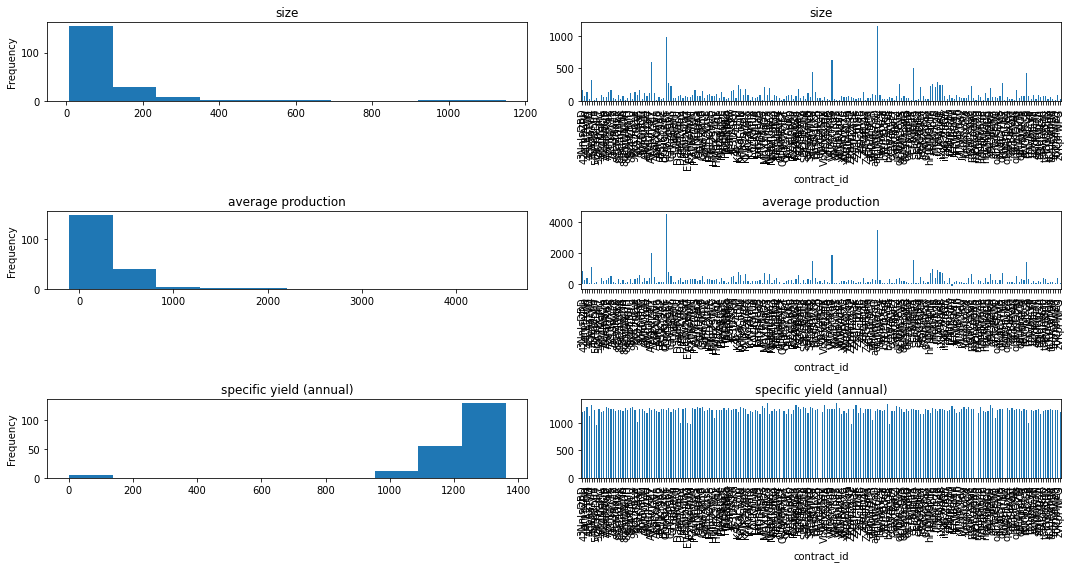

In [6]:
fig, axes = plt.subplots(nrows = 3, ncols = 2)

group = df.groupby(['contract_id'])

# plot average solar system size
group.mean()['size_kwdc'].plot(kind = 'hist', figsize = (15, 8), ax = axes[0, 0], \
title = 'size')

# plot average solar system production
group.mean()['actual_kwh'].plot(kind = 'hist', figsize = (15, 8), ax = axes[1, 0], \
title = 'average production')

# plot average solar system yield
group.mean()['system_yield_as_built'].plot(kind = 'hist', figsize = (15, 8), \
ax = axes[2, 0], title = 'specific yield (annual)')

# plot average solar system size
group.mean()['size_kwdc'].plot(kind = 'bar', figsize = (15, 8), ax = axes[0, 1], \
title = 'size')

# plot average solar system production
group.mean()['actual_kwh'].plot(kind = 'bar', figsize = (15, 8), ax = axes[1, 1], \
title = 'average production')

# plot average solar system yield
group.mean()['system_yield_as_built'].plot(kind = 'bar', figsize = (15, 8), \
ax = axes[2, 1], title = 'specific yield (annual)')

plt.tight_layout()

In [7]:
# get average / mean column values by contract (can also do max, min, etc.)

group.mean()

,holding_company_id,project_company_id,size_kwdc,actual_kwh,expected_kwh,weather_adjusted_expected_kwh,system_yield_as_built,system_yield_finance,annual_degradation_engr,annual_degradation_finance
contract_id,,,,,,,,,,
3NnJsDBD,30.000000,26.000000,172.80,818.966745,753.852275,804.048556,1202.4,1202.4,0.005,NaN
42gm9ZRb,36.000000,85.000000,72.20,292.040526,336.928888,336.928888,1215.9,1215.9,0.005,NaN
4CLfAuJq,2.594502,32.474227,137.00,421.977237,440.965338,434.769781,1283.0,1283.0,0.005,0.0025
4FbAzTVD,14.839822,44.249166,25.13,75.072695,77.572922,76.059615,1131.0,1131.0,0.005,NaN
4qv9aTyM,4.472401,8.944801,322.90,1127.756060,1185.079051,1159.594450,1318.0,1318.0,0.005,NaN
...,...,...,...,...,...,...,...,...,...,...
tDUAwoqa,7.842105,37.134737,60.06,164.500244,216.353370,209.502031,1248.0,1250.0,0.005,0.0025
tbANVfMW,5.684685,11.369369,32.40,126.611421,116.154486,113.068259,1239.0,1239.0,0.005,NaN
tnmvfwZ9,7.873418,8.075949,15.10,69.384894,66.973181,69.096800,1233.2,1233.2,0.005,NaN


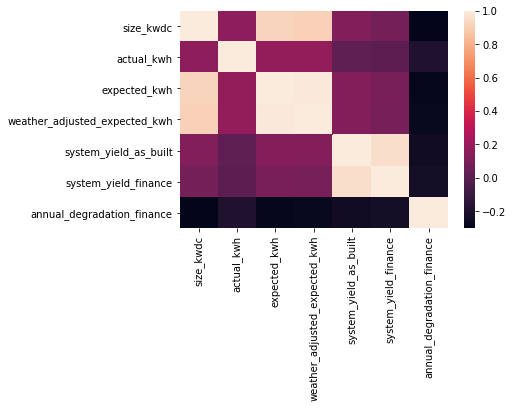

In [8]:
# get an idea of how (numeric) variables correspond with each other

correlations = df.corr()

heatmap = correlations.iloc[2:, 2:].dropna(how = 'all')
heatmap.dropna(axis = 1, how = 'all', inplace = True)

sns.heatmap(heatmap, xticklabels=heatmap.columns, yticklabels=heatmap.columns)

#### 2.3.2 Size

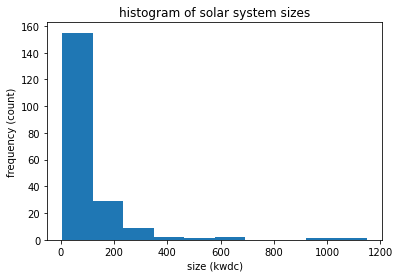

In [9]:
# get an idea of solar system sizes

size_unique = group.apply(lambda x: x['size_kwdc'].unique()[0])
plt.hist(size_unique)
plt.title('histogram of solar system sizes')
plt.xlabel('size (kwdc)')
plt.ylabel('frequency (count)')
plt.show()

Observing contract sizes, the histogram below is heavily skewed right with many small contracts and a few big ones.

In [10]:
# find the problematic contract

sizes = group.apply(lambda x: x['size_kwdc'].unique())

for i in range(len(sizes)): 
    elem = sizes[sizes.index[i]]
    if len(elem) != 1:
        print(sizes.index[i], elem)

9EUCfnGw [218.2  82.7]


Interestingly, there is one contract with multiple sizes! This is likely an anomaly, but we would need to check with the database to see which one is right and why there are 2.

#### 2.3.3 Production

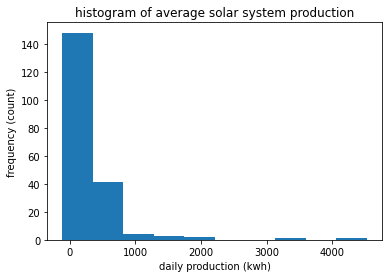

In [11]:
# plot histogram of average solar system production (skewed right w/ many smaller values and some large ones)

avg_contract_production = group.mean()['actual_kwh'] # store average production by contract to use later
plt.hist(avg_contract_production)
plt.title('histogram of average solar system production')
plt.xlabel('daily production (kwh)')
plt.ylabel('frequency (count)')
plt.show()

In [12]:
# calculate correlations see how other variables correspond to production

df.corr()['actual_kwh'][2:]

size_kwdc                        0.165128
actual_kwh                       1.000000
expected_kwh                     0.178816
weather_adjusted_expected_kwh    0.180223
system_yield_as_built            0.020092
system_yield_finance             0.012633
annual_degradation_engr               NaN
annual_degradation_finance      -0.191320
Name: actual_kwh, dtype: float64

This plot of average system production looks similar to the histogram of sizes from above - this makes sense because production should correspond exactly with size and, as such, should be distributed similarly. The plot is again heavily skewed right with a few systems producing very highly and most producing smaller amounts on average. The list of correlations between production and other numeric columns is, as we would expect, strong for size as well as expected production and weather adjusted production. This means our existing predictions (of expected production) are pretty accurate, which is good (though there is still room for improvement). One concerning point about the histogram is that the first bar does not start from 0, meaning there may be some contracts with net *negative* production. Below, we may want to look into this.

In [13]:
# find any problematic contracts (net negative production)

[elem for elem in avg_contract_production.items() if elem[1] < 0]

[('jZWEeuhJ', -108.57662392260588)]

In [14]:
# examine the anomalous contract w/ net negative production

jZWEeuhJ = df[df['contract_id'] == 'jZWEeuhJ']
jZWEeuhJ[jZWEeuhJ['actual_kwh'] < 0] # filter for only negative production values - some EXTREMELY negative

,holding_company_id,project_company_id,contract_id,size_kwdc,production_date,ato_date,actual_kwh,expected_kwh,weather_adjusted_expected_kwh,in_service_date,host_type,revenue_type,interconnection_type,registry_facility_name,cref_short_name,subscriber_orginization,system_yield_as_built,system_yield_finance,annual_degradation_engr,annual_degradation_finance
43803,21,57,jZWEeuhJ,43.92,2020-10-01,2018-07-10,-203217.536090,150.976558,124.555661,2018-07-10,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
44315,21,57,jZWEeuhJ,43.92,2020-10-05,2018-07-10,-203769.953827,150.976558,124.555661,2018-07-10,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
44443,21,57,jZWEeuhJ,43.92,2020-10-06,2018-07-10,-59.278923,150.976558,124.555661,2018-07-10,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
44571,21,57,jZWEeuhJ,43.92,2020-10-07,2018-07-10,-147.025910,150.976558,124.555661,2018-07-10,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
44699,21,57,jZWEeuhJ,43.92,2020-10-08,2018-07-10,-155.335679,150.976558,124.555661,2018-07-10,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
45339,21,57,jZWEeuhJ,43.92,2020-10-13,2018-07-10,-205248.635567,150.976558,124.555661,2018-07-10,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
45594,21,57,jZWEeuhJ,43.92,2020-10-15,2018-07-10,-205792.877759,150.976558,124.555661,2018-07-10,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
45721,21,57,jZWEeuhJ,43.92,2020-10-16,2018-07-10,-38.183055,150.976558,124.555661,2018-07-10,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
46105,21,57,jZWEeuhJ,43.92,2020-10-19,2018-07-10,-206639.162217,150.976558,124.555661,2018-07-10,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN
60484,21,57,jZWEeuhJ,43.92,2021-01-31,2018-07-10,-0.142861,85.334577,86.102588,2018-07-10,C&I,NaN,NEM,NON231026,NaN,NaN,1300.0,1300.0,0.005,NaN


Looking further into the contract with negative production, we see, in fact, some VERY extreme negative values. We should probably check if there are more extreme values in the dataset and, if so, delete them so they don't skew our data.

In [15]:
# find all datapoints with actual production values less than -10 (concerning - for further inspection)

anomalies = {}

for i in df.index:
    if df['actual_kwh'][i] < -10:
        try:
            anomalies[df['contract_id'][i]].append((df['production_date'][i], df['actual_kwh'][i]))
        except:
            anomalies[df['contract_id'][i]] = [(df['production_date'][i], df['actual_kwh'][i])]
            
for elem in anomalies.keys():
    print(elem)
    for val in anomalies[elem]:
        print(val)

ek6YqHFq
(Timestamp('2019-01-06 00:00:00'), -41.99239388888888)
(Timestamp('2019-01-08 00:00:00'), -17.999270833333327)
(Timestamp('2019-01-10 00:00:00'), -48.036115555555526)
(Timestamp('2019-01-11 00:00:00'), -47.59431694444445)
(Timestamp('2019-01-16 00:00:00'), -16.59812055555554)
(Timestamp('2019-01-20 00:00:00'), -10.091960277777758)
(Timestamp('2019-01-21 00:00:00'), -24.332235)
(Timestamp('2019-01-22 00:00:00'), -21.9092675)
8EaZmYXK
(Timestamp('2019-04-25 00:00:00'), -5968.855)
ZXE74w3k
(Timestamp('2020-02-07 00:00:00'), -2172.002206388889)
gXwfgdGx
(Timestamp('2020-03-12 00:00:00'), -15.073318611102875)
(Timestamp('2020-03-13 00:00:00'), -32.14882166669122)
(Timestamp('2020-03-14 00:00:00'), -36.57348999999522)
(Timestamp('2020-03-15 00:00:00'), -15.886510555559653)
(Timestamp('2020-03-16 00:00:00'), -36.97634694444423)
(Timestamp('2020-03-17 00:00:00'), -32.73582027776865)
(Timestamp('2020-03-18 00:00:00'), -34.6662927777943)
(Timestamp('2020-03-19 00:00:00'), -18.1433272222

In [16]:
# get rid of some obvious anomalies

df.drop(df[df['actual_kwh'] < -10].index, inplace = True) # get rid of unreasonably negative values
df.drop(df[df['actual_kwh'] > 10000].index, inplace = True) # and unreasonably positive values

group = df.groupby('contract_id') # re-group for deletion

Now that we've removed the potentially anomalous values we noticed, we can continue with our analysis of production, this time with size.

/Users/katherineli/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


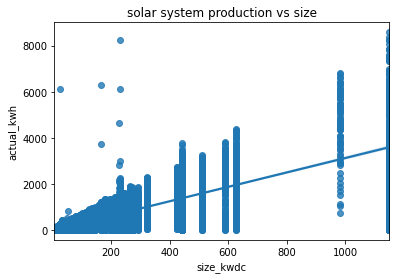

In [17]:
# plot size against production

sns.regplot(df['size_kwdc'], df['actual_kwh'])
plt.title('solar system production vs size')
plt.show()

Plotting size against production directly, we do see that the bigger systems have higher max production values compared to smaller ones. However, the variance is also higher. The trend is that production does increase with size, as we would expect. Some smaller contracts also occasionally produce very high power (potentially anomalous, but we can examine this later with specific yield).

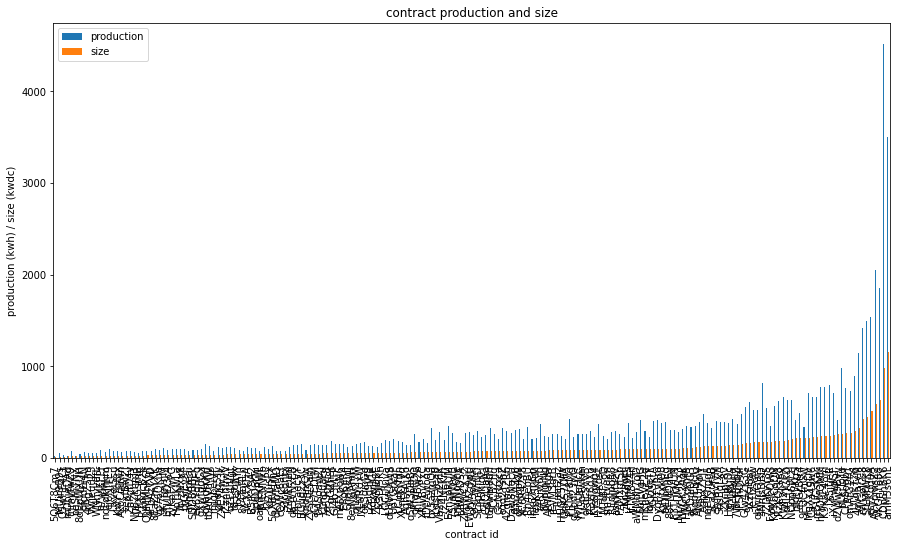

In [18]:
# plot each contract's size versus average (daily) production for comparison (same axes)

df_size_production = pd.DataFrame() # combine to a new dataframe to plot using pandas
df_size_production['production'] = group.mean()['actual_kwh'] # get average production per contract
df_size_production['size'] = size_unique # we already have size from earlier, so just add it
df_size_production.sort_values(by = 'size').plot(kind = 'bar', figsize = (15, 8))
plt.title('contract production and size')
plt.xlabel('contract id')
plt.ylabel('production (kwh) / size (kwdc)')
plt.show()

Plotted individually by contract, again, size corresponds with average production. Next, we will examine both of these variables alongside specific yield.

#### 2.3.4 Yield

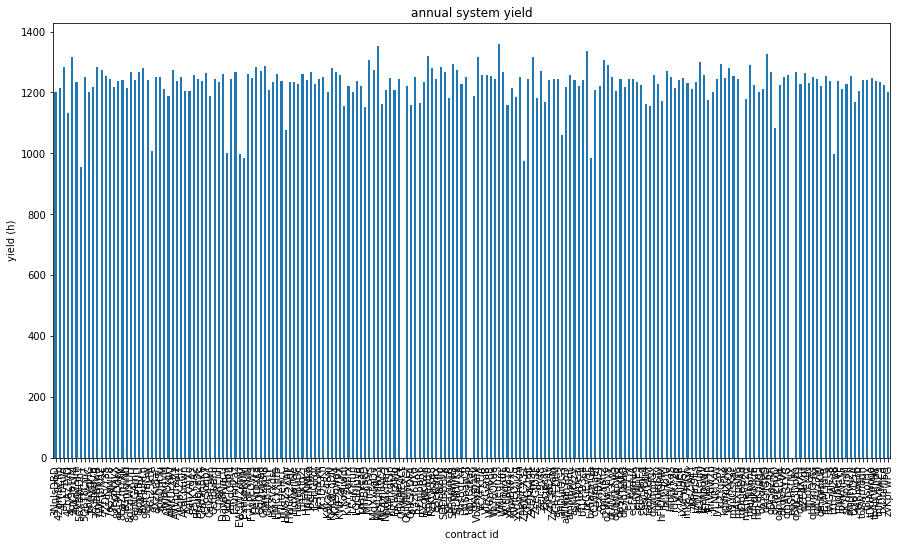

In [19]:
# plot system yield by contract

annual_yield = df.groupby(['contract_id']).mean()['system_yield_as_built']
annual_yield.plot(kind = 'bar', figsize = (15, 8))
plt.title('annual system yield')
plt.xlabel('contract id')
plt.ylabel('yield (h)')
plt.show()

At a glance, annual yield as provided in the dataset seems very evenly distributed. Since this is something we can also calculate on our own given that we have data for both production and size, we can do so and see if our self-calculated yield matches the one provided.

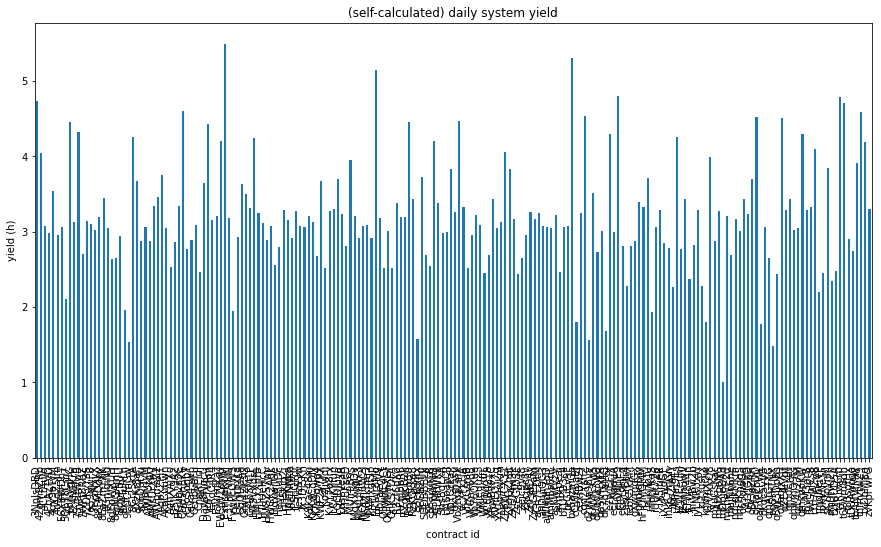

In [20]:
# find and plot ratios of production per size (calculated yield)

df_size_production['yield'] = group.mean()['actual_kwh']/size_unique # new column to dataframe
df_size_production['yield'].plot(kind = 'bar', figsize = (15, 8))
plt.title('(self-calculated) daily system yield')
plt.xlabel('contract id')
plt.ylabel('yield (h)')
plt.show()

The self-calculated specific yield ratios, while still relatively random at a glance, seem to have a much higher variance than the ones provided. This could be due to random variations in production, or it could be a sign that some provided data are off.

In [21]:
# create new columns for annual yield and daily yield to compare to the self-calculated one

df_size_production['annual yield'] = annual_yield
df_size_production['daily yield'] = annual_yield/365

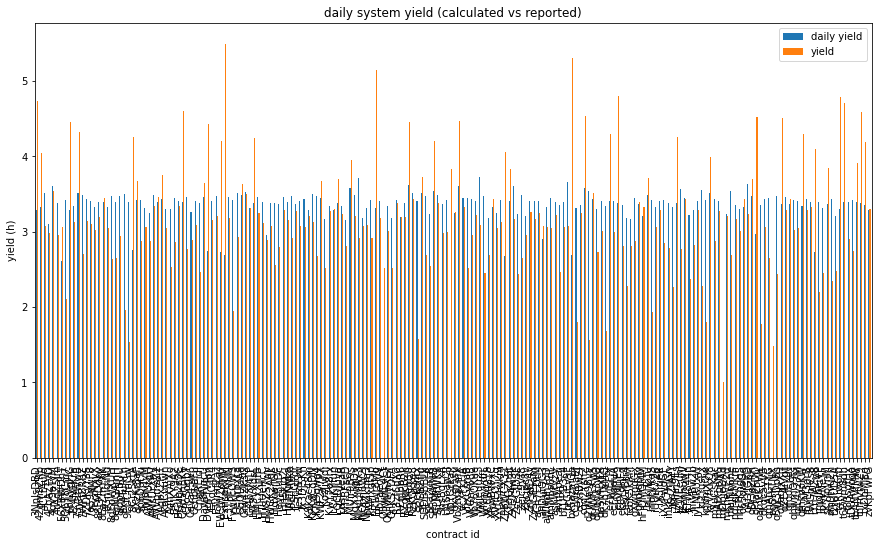

In [22]:
# plot calculated against provided daily yield to notice correspondence

df_size_production[['daily yield', 'yield']].plot(kind = 'bar', figsize = (15, 8))
plt.title('daily system yield (calculated vs reported)')
plt.xlabel('contract id')
plt.ylabel('yield (h)')
plt.show()

Plotting calculated yield against provided yield, we can see that there are some gaps in the provided yield plot where there is data for calculated yield. That is, some of the expected yields are 0 where systems are actually producing. This likley means these provided yields are off. We can examine provided vs calculated specific yields in more detail below.

In [23]:
# (provided daily yield, number of contracts with that yield)

df_size_production['daily yield'].value_counts()

0.000000    4
3.405753    3
3.446575    3
3.408219    3
3.394521    3
           ..
3.441644    1
3.165479    1
3.345205    1
3.293151    1
3.294247    1
Name: daily yield, Length: 169, dtype: int64

In [24]:
# (calculated daily yield, number of contracts with that yield)

df_size_production['yield'].value_counts()

4.739391    1
4.302328    1
3.069080    1
5.299599    1
1.795675    1
           ..
2.521551    1
3.272230    1
3.307718    1
3.698247    1
3.301824    1
Name: yield, Length: 200, dtype: int64

In [25]:
# check if any of the contracts have a calculated yield of 0 (e.g. never produced)

df_size_production['yield'][df_size_production['yield'] == 0]

Series([], Name: yield, dtype: float64)

Again, it is slightly concerning that there are 4 systems for which the reported yield is 0 and 30 for which no yield is reported. It is also a bit strange why some contracts have the same specific yield, down to 6 decimal points. In comparison, our self-calculated specific yields are unique, exist for all contracts (except the one removed earlier), and contain no zeroes. 

In [26]:
# (mean provided daily yield, mean calculated daily yield)

np.mean(df_size_production['daily yield']), np.mean(df_size_production['yield'])

(3.2944576712328746, 3.181337501913126)

Interestingly, too, the average daily yield as averaged using the provided yield is higher than the one averaged using our self-calculated yield, despite the provided data containing zeroes. Further, provided yield is 'system_yield_as_built', the engineering as opposed to finance value, so it's more problematic for it to be inflated or potentially inaccurate. Still, out self-calculated yield may also have problems as production values used to calculate them can fluctuate and throw our calculations off. Since we're not sure which yield is more accurate, we will plot both against production and size to see if there are any trends or correlations between them.

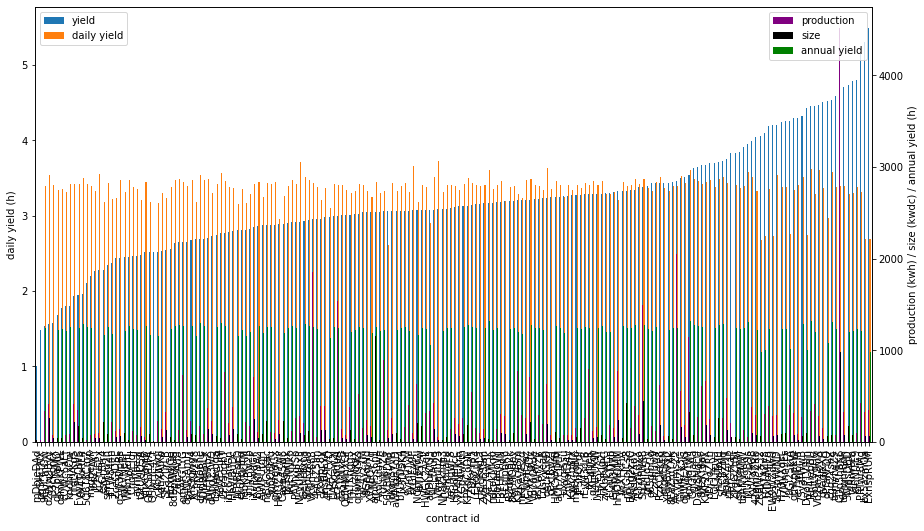

In [27]:
# bar plot sorted by self-calculated yield

ax = df_size_production.sort_values(by = 'yield')[['yield', 'daily yield']].plot(kind = 'bar', figsize = (15, 8))
ax.set_xlabel("contract id")
ax.set_ylabel("daily yield (h)")
ax2 = ax.twinx()
df_size_production.sort_values(by = 'yield')[['production', 'size', 'annual yield']].plot(kind = 'bar', \
figsize = (15, 8), ax = ax2, color = ['purple', 'black', 'green'])
ax2.set_ylabel("production (kwh) / size (kwdc) / annual yield (h)")
ax2.legend(loc='upper right')
plt.show()

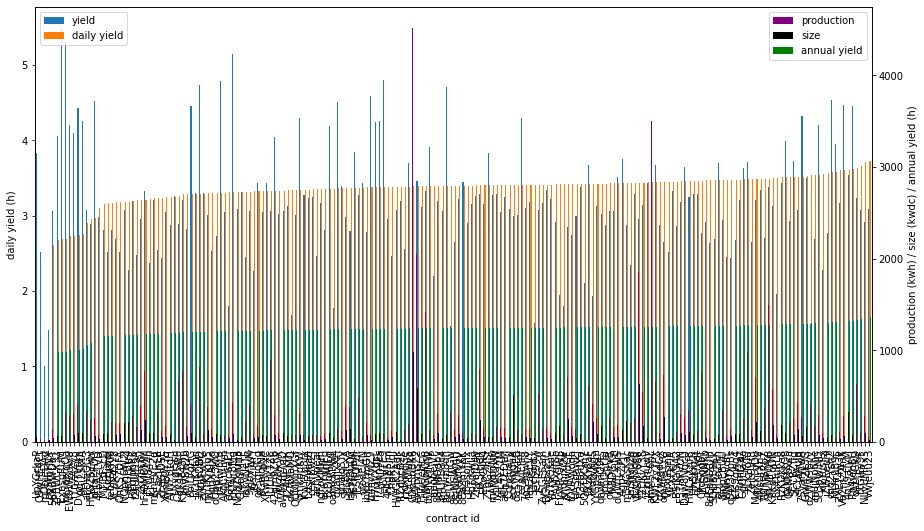

In [28]:
# bar plot sorted by provided yield

ax = df_size_production.sort_values(by = 'daily yield')[['yield', 'daily yield']].plot(kind = 'bar', figsize = (15, 8))
ax.set_xlabel("contract id")
ax.set_ylabel("daily yield (h)")
ax.legend(loc='upper left')
ax2 = ax.twinx()
df_size_production.sort_values(by = 'daily yield')[['production', 'size', 'annual yield']].plot(kind = 'bar', \
figsize = (15, 8), ax = ax2, color = ['purple', 'black', 'green'])
ax2.set_ylabel("production (kwh) / size (kwdc) / annual yield (h)")
ax2.legend(loc='upper right')
plt.show()

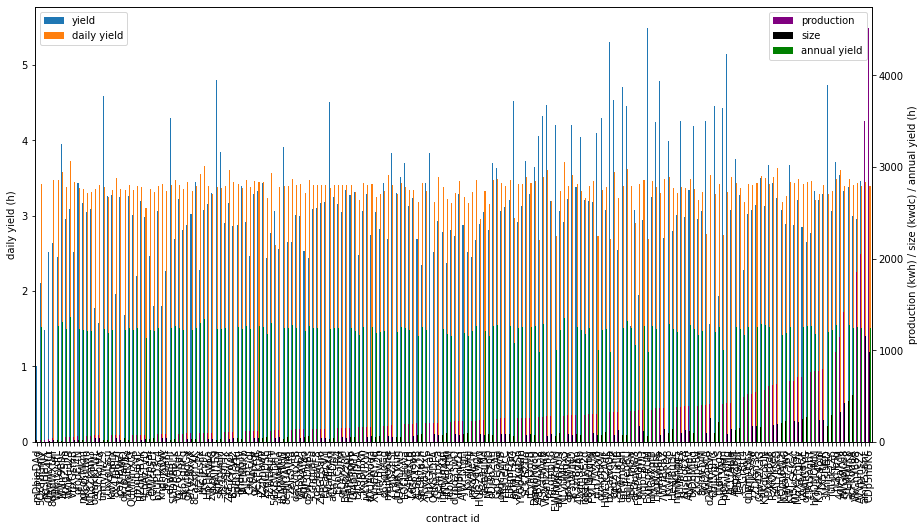

In [29]:
# bar plot sorted by production

ax = df_size_production.sort_values(by = 'production')[['yield', 'daily yield']].plot(kind = 'bar', figsize = (15, 8))
ax.set_xlabel("contract id")
ax.set_ylabel("daily yield (h)")
ax.legend(loc='upper left')
ax2 = ax.twinx()
df_size_production.sort_values(by = 'production')[['production', 'size', 'annual yield']].plot(kind = 'bar', \
figsize = (15, 8), ax = ax2, color = ['purple', 'black', 'green'])
ax2.set_ylabel("production (kwh) / size (kwdc) / annual yield (h)")
ax2.legend(loc='upper right')
plt.show()

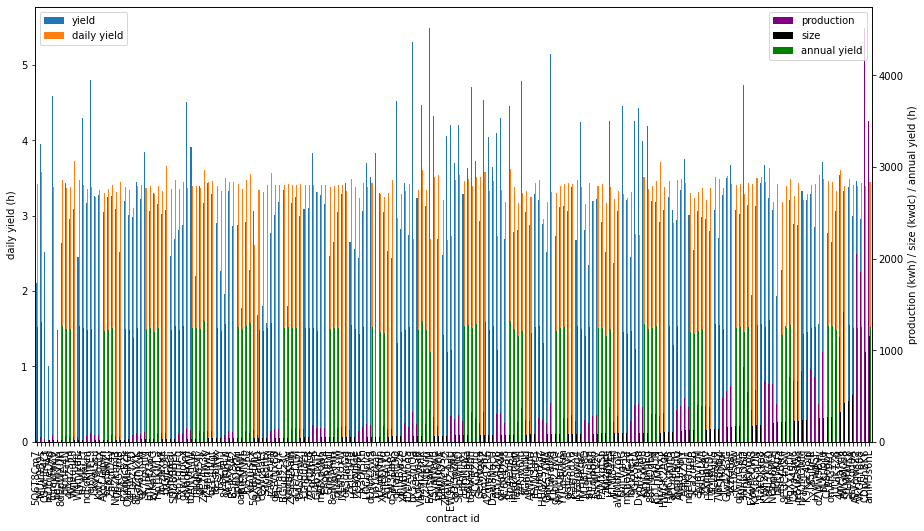

In [30]:
# bar plot sorted by system size

ax = df_size_production.sort_values(by = 'size')[['yield', 'daily yield']].plot(kind = 'bar', figsize = (15, 8))
ax.set_xlabel("contract id")
ax.set_ylabel("daily yield (h)")
ax.legend(loc='upper left')
ax2 = ax.twinx()
df_size_production.sort_values(by = 'size')[['production', 'size', 'annual yield']].plot(kind = 'bar', \
figsize = (15, 8), ax = ax2, color = ['purple', 'black', 'green'])
ax2.set_ylabel("production (kwh) / size (kwdc) / annual yield (h)")
ax2.legend(loc='upper right')
plt.show()

Just observing the series of graphs above, we can see that while size varies with production (they appear highly correlated), varying any measure of yield leads to a pretty random distribution of size and production. Varying size or production doesn't seem to produce any trend in yield. Thus, there doesn't seem to be much correlation, if any, between size / production and yield. We can also measure the exact correlations and see.

In [31]:
df_size_production.corr()

,production,size,yield,annual yield,daily yield
production,1.000000,0.969170,0.181828,0.090543,0.090543
size,0.969170,1.000000,0.043087,0.105240,0.105240
yield,0.181828,0.043087,1.000000,0.107064,0.107064
annual yield,0.090543,0.105240,0.107064,1.000000,1.000000
daily yield,0.090543,0.105240,0.107064,1.000000,1.000000


From the correlation matrix, we see that there is, indeed, a very high correlation between size and (average) production! However, as expected, there is relatively little correlation between either and yield (provided or calculated). There is perhaps some correlation between production and calculated yield, but, after all, this yield is calculated using average daily production divided by size. It's actually surprising how low the correlation is between calculated yield and size, given that it's in the denominator of our calculation. That said, again, none of these correlations between production or size and any measure of yield is high enough to assume a real relationship. Neither does calculated yield correspond very much with provided yield, which is interesting to note. It might be interesting to also check if any other factors do vary with yield, as we want yield to be as high as possible.

In [32]:
dict_yield = dict(df_size_production['yield'])
df['yield'] = df.apply(lambda row: dict_yield[row.contract_id], axis=1)
df.corr()['yield']

holding_company_id              -0.085650
project_company_id              -0.053759
size_kwdc                        0.076862
actual_kwh                       0.171354
expected_kwh                     0.089679
weather_adjusted_expected_kwh    0.092430
system_yield_as_built            0.216550
system_yield_finance             0.210979
annual_degradation_engr               NaN
annual_degradation_finance      -0.127373
yield                            1.000000
Name: yield, dtype: float64

In [33]:
df.corr()['system_yield_as_built']

holding_company_id              -0.116648
project_company_id              -0.103594
size_kwdc                        0.130345
actual_kwh                       0.099689
expected_kwh                     0.135918
weather_adjusted_expected_kwh    0.133491
system_yield_as_built            1.000000
system_yield_finance             0.955947
annual_degradation_engr               NaN
annual_degradation_finance      -0.243101
yield                            0.216550
Name: system_yield_as_built, dtype: float64

Looking at a more complete list of correlations, again, nothing seems to correlate strongly or even moderately with either measure of yield, provided or calculated.

#### 2.3.5 Performance

In [34]:
# define performance as a ratio of actual production divided by expected production

df['performance'] = df['actual_kwh']/df['expected_kwh']

First, we're interested in flagging any contracts with low performance (< 0.1), which engineering may want to look at. We can also check how many consecutive days of low performance we generally have and how many total for each contract.

In [35]:
# create a dataframe of only low performance contracts / days (e.g. < 10% performance)

df_low_performance = df[df['performance'] < 0.1]
df_low_performance.head()

,holding_company_id,project_company_id,contract_id,size_kwdc,production_date,ato_date,actual_kwh,expected_kwh,weather_adjusted_expected_kwh,in_service_date,...,interconnection_type,registry_facility_name,cref_short_name,subscriber_orginization,system_yield_as_built,system_yield_finance,annual_degradation_engr,annual_degradation_finance,yield,performance
2,28,71,5Q6T8Cm7,6.70,2019-01-01,2018-11-28,0.139945,12.643548,12.643548,2018-11-28,...,NEM,NON241642,NaN,NaN,1250.0,1250.000000,0.005,0.005,2.110441,0.011068
9,20,56,cQWc6aEf,42.84,2019-01-01,2018-11-19,0.000000,78.193172,78.193172,2018-12-31,...,NEM,NON241713,NaN,NaN,1208.1,1365.000000,0.005,NaN,1.795675,0.000000
11,20,56,dk7bTaMQ,42.10,2019-01-01,2018-07-12,0.000000,77.745330,77.745330,2018-12-08,...,NEM,NON242066,NaN,NaN,1219.5,1296.000000,0.005,NaN,1.682568,0.000000
12,15,44,ek6YqHFq,30.60,2019-01-01,2018-12-28,-6.066558,56.544062,56.544062,2019-02-19,...,CREF,NON242077,NCS09,CleanChoice,1224.0,1224.000000,0.005,NaN,2.814510,-0.107289
18,20,56,kndhjxQw,45.00,2019-01-01,2018-11-20,0.000000,80.803763,80.803763,2018-12-10,...,NEM,NON241675,NaN,NaN,1247.0,1274.300049,0.005,0.005,1.802971,0.000000


In [36]:
# group low performance days by contract

low_performance_dates = df_low_performance.groupby('contract_id').apply(lambda x: x['production_date'])

In [37]:
# convert grouped dates to a dictionary with {contract: dates}

low_performance_grouped = {}

contract_ids = df['contract_id'].unique()

for elem in contract_ids:
    try:
        len(list(low_performance_dates[elem])) > 1
        low_performance_grouped[elem] = list(low_performance_dates[elem])
    except:
        low_performance_grouped[elem] = list()

In [38]:
# count how many low production days per contract and add it as a new column to df

low_performance_total = {elem: len(low_performance_grouped[elem]) for elem in low_performance_grouped.keys()}
df['low_performance_total'] = df.apply(lambda row: low_performance_total[row.contract_id], axis = 1)

In [39]:
print(f'total low performance days: {sum(low_performance_total.values())}')
print(f'average low performance days per contract: {np.mean(list(low_performance_total.values()))}')

total low performance days: 6220
average low performance days per contract: 31.1


In [40]:
# count consecutive days of low production and add to df as a new column

low_performance_duration = {elem: 0 for elem in low_performance_grouped.keys()}

for elem in low_performance_grouped.keys():
    length = 0
    for i in range(len(low_performance_grouped[elem]) - 1):
        length += 1
        if length > low_performance_duration[elem]:
            low_performance_duration[elem] = length
        if low_performance_grouped[elem][i] + pd.DateOffset(1) != low_performance_grouped[elem][i + 1]:
            length = 0
            continue
            
df['low_performance_consecutive'] = df.apply(lambda row: low_performance_duration[row.contract_id], axis = 1)

In [41]:
print(f'max consecutive days of low performance: {max(low_performance_duration.values())}')
print(f'average consecutive days of low performance: {np.mean(list(low_performance_duration.values()))}')

max consecutive days of low performance: 364
average consecutive days of low performance: 21.04


Now that we have marked our low production days and added them to our dataframe, we can use them in further analysis! Looking at the numbers, an average of 21 low production days in a row seems pretty bad; there are probably some problems occuring for which fixes are heavily delayed. Further, two multiple contracts have a chain of at least 364 low production days in a row! What stopped this number from increasing was actually a gap at 12/31, which could've been due to a non-comm, missing data, etc. The problem evidently was not actually fixed if low production again started on 01/01 the next year. An average of a month of low production days per contract also seems less than ideal; we've only been collecting production data for 2.5 years, so a month of low performance could be about 3% of our profits gone! Further, both averages are calculated including systems which have had no low production at all, so the average length of consecutive low production days is probably higher if we only look among systems that have had low production in the first place.

Next, we will look into performance overall.

In [42]:
# bound performance between 0 and 2 (actual production shouldn't be less than 0% of expected or more than 200%)

df.loc[df['performance'] > 2, 'performance'] = 2
df.loc[df['performance'] < 0, 'performance'] = 0

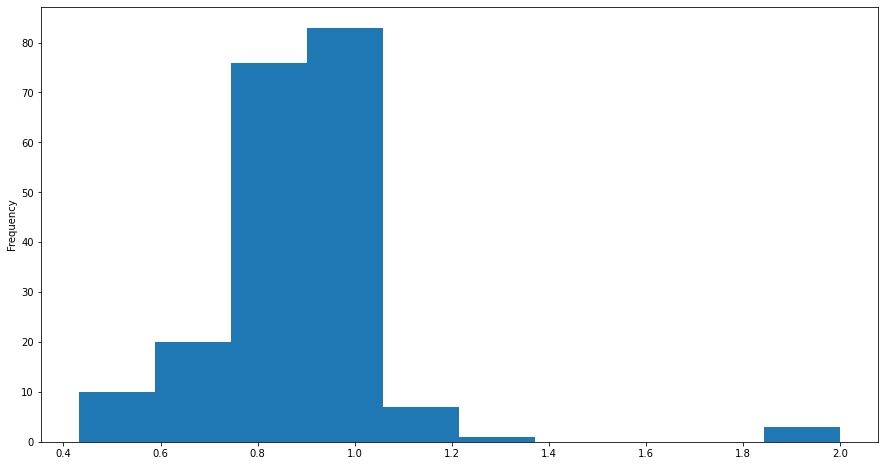

In [43]:
# plot a histogram of average performance by contract

group = df.groupby('contract_id') # update group since we added a new column
group.mean()['performance'].plot(kind = 'hist', figsize = (15, 8))

As we can see, performance does seem pretty normally distributed with a mean around 90%. However, there are a lot of potential outliers around 2. Remember, any performance values higher than 2 were cast to 2. Other than that, if we assume the values in the distribution to the left are accurate (and there is no reason to think they are not), a mean performance around 90% is pretty good! It might also be interesting to see if size or anything else varies with performance below.

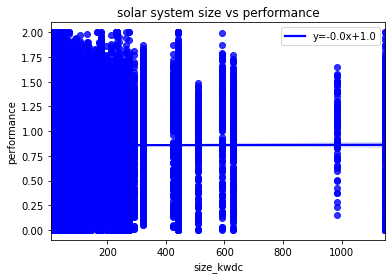

In [44]:
# plot performance against size

# get coefs of linear fit
s, i, r, p, se = stats.linregress(df.dropna()['size_kwdc'], df.dropna()['performance'])

# use line_kws to set line label for legend
sns.regplot(x = 'size_kwdc', y = 'performance', data = df, color='b', \
line_kws={'label':"y={0:.1f}x+{1:.1f}".format(s, i)}).legend()

plt.title('solar system size vs performance')
plt.show()

In [45]:
print(f'average performance: {i}')

average performance: 1.049948129735141


In [46]:
performance_correlations = dict(df.corr()['performance'])
performance_correlations = sorted(performance_correlations.items(), key = lambda performance_correlations: performance_correlations[1])
performance_correlations

[('system_yield_finance', -0.3498329846083777),
 ('system_yield_as_built', -0.32000583891172024),
 ('low_performance_total', -0.2444622453552902),
 ('low_performance_consecutive', -0.21298566348966383),
 ('holding_company_id', -0.03353760370507606),
 ('project_company_id', -0.01315886036745608),
 ('expected_kwh', -5.3376340048065205e-05),
 ('size_kwdc', 0.000932696803200759),
 ('weather_adjusted_expected_kwh', 0.011737209134310384),
 ('annual_degradation_finance', 0.10976040443070115),
 ('yield', 0.19609618280028948),
 ('actual_kwh', 0.2795248619489552),
 ('annual_degradation_engr', nan),
 ('performance', 1.0)]

We see no strong correlations in general, certainly not with size. Interestingly, provided yield correlates negatively with performance while our calculated yield correlates positively. We would perhaps expect higher yield systems to perform better, so our yield is likely more correct, but we will later perform anomaly detection on both dimensions. Other than that, there is a small positive correlation between performance and production (which makes sense since performance is a function of production and expected production) and a small negative correlation with low production days (total and consecutive; pretty self explanatory).

In [47]:
# start collecting predictors for modelling

predictors = list(dict(performance_correlations).keys())[:4] + list(dict(performance_correlations).keys())[9:12]
predictors

['system_yield_finance',
 'system_yield_as_built',
 'low_performance_total',
 'low_performance_consecutive',
 'annual_degradation_finance',
 'yield',
 'actual_kwh']

#### 2.3.6 Holding Company

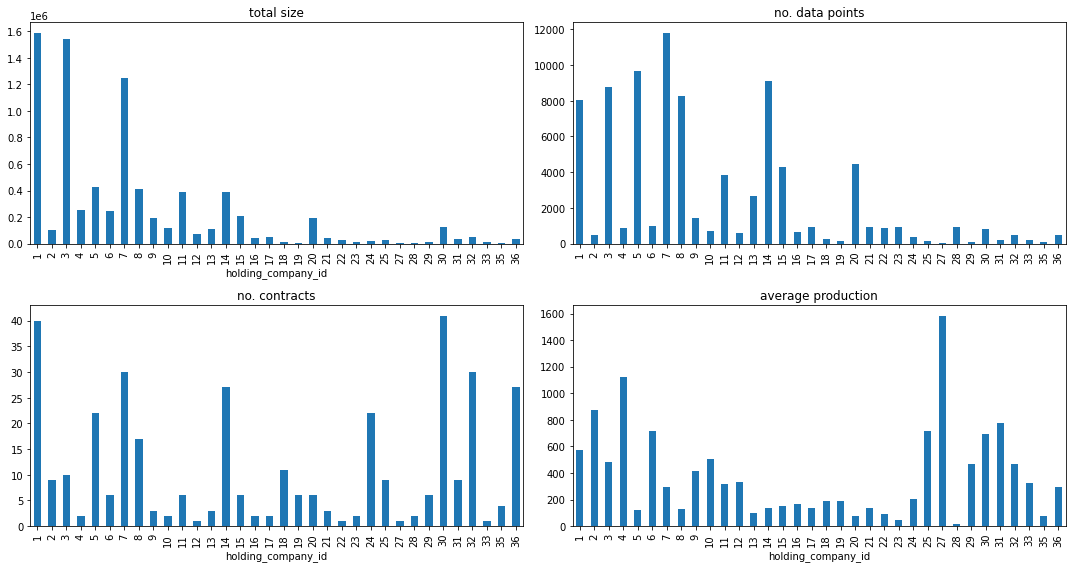

In [48]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)

# plot total solar system size under each holding company
df.groupby(['holding_company_id']).sum()['size_kwdc'].plot(kind = 'bar', figsize = (15, 8), ax = axes[0, 0], \
title = 'total size')

# plot number of datapoints per holding company
df['holding_company_id'].value_counts().sort_index().plot(kind = 'bar', figsize = (15, 8), ax = axes[0, 1], \
title = 'no. data points')

# plot number of contracts under each holding company
df.groupby('holding_company_id')['contract_id'].unique().str.len().plot(kind = 'bar', figsize = (15, 8), \
ax = axes[1, 0], title = 'no. contracts')

# plot average production under each holding company
df.groupby(['holding_company_id']).mean()['actual_kwh'].plot(kind = 'bar', figsize = (15, 8), ax = axes[1, 1], \
title = 'average production')

plt.tight_layout()

Examining the 'holding_company_id' column, we find that contracts, total system size, and amount of data are all pretty unevenly distributed between holding companies. So is average production. This finding, itself, is not surprising, but the discrepancy between the measures may be interesting to note.

For example, holding company 3 may not have many contracts, but they have a large mass of solar system which produces a lot of data. In terms of production, relatively middling. Company 1 has many large systems which collect a lot of data, but again, middling production. Companies 5, 7, 8, and 14, which, based on size, no. contracts, and no. data points, I would also call "bigger" companies, have relatively low average production.

Companies with relatively high average production, like 2, 4, 6, 25, 27, 30, 31 all have relatively little data and smaller aggregate system size. Among them, only 30 has many contracts (albeit still small ones). On the surface (in terms of size, no. contracts, amount of data), they look similar to company 21, which has net negative production. This may just mean that there's more variability among smaller companies, but the average production among smaller companies does appear potentially higher than among bigger companies.

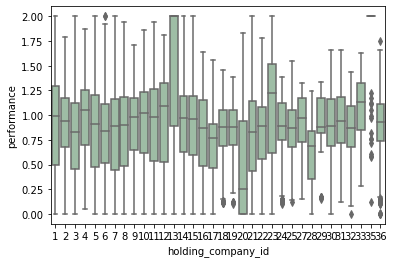

In [49]:
# boxplot of performance per contract

sns.boxplot(x = 'holding_company_id', y = 'performance', data = df, color = '#99c2a2')

We're also interested in how or whether performance varies with holding company. At a glance, in the box plot above, we can see that some of the distributions of performance by holding company do look different than others. To find out whether there is truly a significant or noticable difference in performance between holding companies, we can perform a series of statistical tests below.

In [50]:
# how many significance tests are we doing? (once for each category of each categorical variable we will analyze)
# this will be the divisor on our bonferroni correction for alpha below

cat_cols = [0, 1, 7, 12, 14, 15, 16, 17, 18]

c = 0
for i in cat_cols:
    c += len(df[df.columns[i]].unique())
    
c

3207

In [51]:
# define a function for difference of means / significance testing

def difference_of_means(data1, data2, tails):
    
    n1 = len(data1)
    n2 = len(data2)
    n = n1 + n2
    x1 = np.mean(data1)
    x2 = np.mean(data2)
    s1 = np.std(data1, ddof=1) # accounts for Bessel's correction w/ ddof=1
    s2 = np.std(data2, ddof=1)
    alpha = 0.05/3177
    
    se = np.sqrt(s1**2/n1 + s2**2/n2)
    t = (x1 - x2)/se
    dfreedom = min(n1, n2) - 1 # conservative estimate for degrees of freedom
    pvalue = tails*stats.t.cdf(-np.abs(t), dfreedom)

    SDpooled = np.sqrt((s1**2*(n1 - 1) + s2**2*(n2 - 1))/(n1 + n2 - 2))
    Cohensd = (x1 - x2)/SDpooled # general measure of effect size
    Glassd = (x1 - x2)/s2 # calculate effect size using only control sd if sds of the two groups are different
    Hedgesg = Cohensd*((n - 3)/(n - 2.25))*np.sqrt((n - 2)/n) # correction of cohen's d for small samples
    
    return t, pvalue, Cohensd, Hedgesg, Glassd, pvalue < alpha

In [52]:
# see if each holding company has a significant impact on performance

print(f'holding id \t t-value \t\t p-value \t\t\t Glass\' delta \t\t significant?')
for i in df['holding_company_id'].unique():
    company = df[df['holding_company_id'] == i]['performance']
    others = df[df['holding_company_id'] != i]['performance']
    if difference_of_means(company, others, 2)[1] == 0.0:
        print(f'{i} \t\t {difference_of_means(company, others, 2)[0]} \t {difference_of_means(company, others, 2)[1]} \
    \t\t\t {difference_of_means(company, others, 2)[4]} \t {difference_of_means(company, others, 2)[-1]}')
    else:
        print(f'{i} \t\t {difference_of_means(company, others, 2)[0]} \t {difference_of_means(company, others, 2)[1]} \
    \t {difference_of_means(company, others, 2)[4]} \t {difference_of_means(company, others, 2)[-1]}')

holding id 	 t-value 		 p-value 			 Glass' delta 		 significant?
15 		 7.001434158985172 	 2.9307967386845676e-12     	 0.09672053576015437 	 True
14 		 11.330579646995133 	 1.4595524985959366e-29     	 0.1085324512770651 	 True
28 		 -24.20136582566569 	 5.154106020682446e-100     	 -0.5566801777838215 	 True
3 		 -11.147769808648054 	 1.1434627142469848e-28     	 -0.11082410299440322 	 True
6 		 -4.36571846790963 	 1.404243083246953e-05     	 -0.11701715908337616 	 True
20 		 -53.72255371529197 	 0.0     			 -0.901362780107212 	 True
22 		 -2.781102825181941 	 0.005533999653182729     	 -0.07243832002188959 	 False
21 		 -3.0588567993717066 	 0.002287544129140872     	 -0.09384661907147535 	 False
23 		 10.337340163175192 	 9.625490012743656e-24     	 0.42603905788980806 	 True
9 		 4.294739856363426 	 1.868032929815267e-05     	 0.0897318656231551 	 False
13 		 49.97331109629568 	 0.0     			 1.479676597096202 	 True
17 		 -15.64977214298546 	 5.3787945048005084e-49     	 -0.3375221

In [53]:
# perform an anova test to see if holding company has a significant impact on performance overall

anova_holding = ols('performance ~ C(holding_company_id)', data = df).fit()
statsmodels.stats.anova_lm(anova_holding, typ = 2)

,sum_sq,df,F,PR(>F)
C(holding_company_id),2106.474730,33.0,317.015471,0.0
Residual,16286.578089,80885.0,NaN,NaN


As we can see, holding company does have a significant effect on performance - statistically, more than half of the holding companies have a performance distributions statistically different than the aggregate. Practically, holding company 20 performs significantly worse than average, while holding companies 13 and 35 perform far better. For an idea of what this difference looks like, we can calculate the exact numbers below.

In [54]:
# average performance overall (all holding companies)
print(f'average production: {np.mean(df["performance"])}')
      
# average production of companies with large effect size
holding_large_effect = [20, 13, 35]
for c in holding_large_effect:
      print(f'company {c} production: {np.mean(df[df["holding_company_id"] == c]["performance"])}')

average production: 0.8576715093668292
company 20 production: 0.4616528119097915
company 13 production: 1.5070729526253785
company 35 production: 1.8022949995337634


In [55]:
# add potentially significant predictors
for elem in holding_large_effect:
    predictors.append('hold_' + str(elem))

#### 2.3.7 Project Company

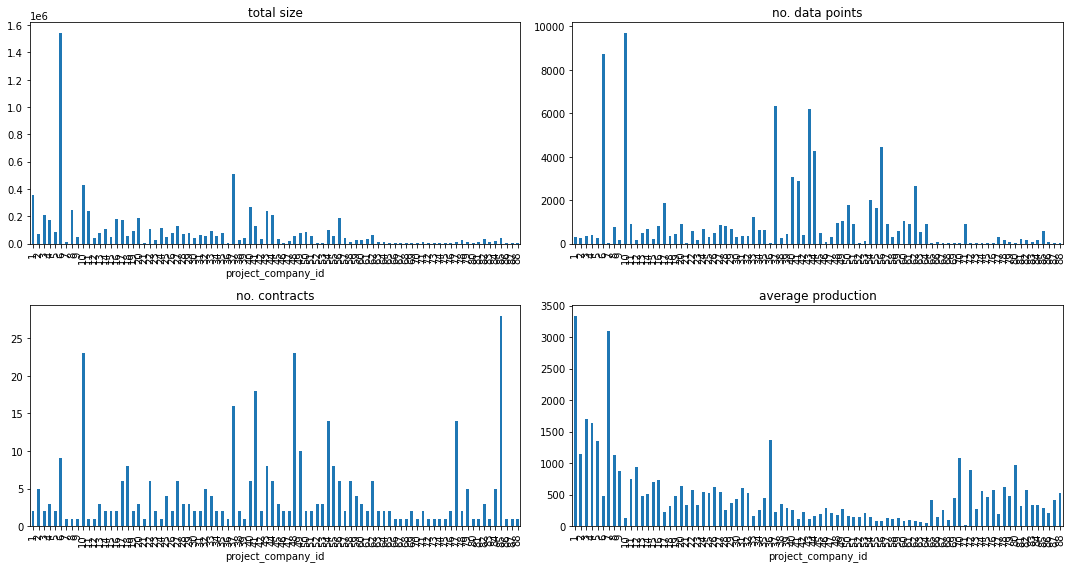

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=2)

# plot total solar system size under each project company
df.groupby(['project_company_id']).sum()['size_kwdc'].plot(kind = 'bar', figsize = (15, 8), ax = axes[0, 0], \
title = 'total size')

# plot number of datapoints per project company
df['project_company_id'].value_counts().sort_index().plot(kind = 'bar', figsize = (15, 8), ax = axes[0, 1], \
title = 'no. data points')

# plot number of contracts under each project company
df.groupby('project_company_id')['contract_id'].unique().str.len().plot(kind = 'bar', figsize = (15, 8), \
ax = axes[1, 0], title = 'no. contracts')

# plot average production under each project company
df.groupby(['project_company_id']).mean()['actual_kwh'].plot(kind = 'bar', figsize = (15, 8), ax = axes[1, 1], \
title = 'average production')

plt.tight_layout()

For project companies, company 1 has notably very high average production despite low aggregate size, number of contracts, and amount of data. Same for companies 3, 4, 5, 7 and 36. Company 57, with negative average production, is also small by all other metrics.

"Big" companies (by all metrics), like 6, 10, 37, etc., all have quite low production. 

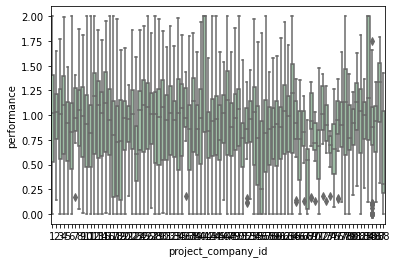

In [57]:
# boxplot of performance per contract

sns.boxplot(x = 'project_company_id', y = 'performance', data = df, color = '#99c2a2')

We're also interested in performance among project companies. From the plot above, again, like holding companies, distributions of performance among project companies appear pretty different. Statistical tests are included below.

In [58]:
print(f'project id \t t-value \t\t p-value \t\t\t Glass\' delta \t\t significant?')
for i in df['project_company_id'].unique():
    company = df[df['project_company_id'] == i]['performance']
    others = df[df['project_company_id'] != i]['performance']
    if difference_of_means(company, others, 2)[1] == 0.0:
        print(f'{i} \t\t {difference_of_means(company, others, 2)[0]} \t {difference_of_means(company, others, 2)[1]} \
    \t\t\t {difference_of_means(company, others, 2)[4]} \t {difference_of_means(company, others, 2)[-1]}')
    else:
        print(f'{i} \t\t {difference_of_means(company, others, 2)[0]} \t {difference_of_means(company, others, 2)[1]} \
    \t {difference_of_means(company, others, 2)[4]} \t {difference_of_means(company, others, 2)[-1]}')

project id 	 t-value 		 p-value 			 Glass' delta 		 significant?
44 		 7.031384518477739 	 2.3713745695222876e-12     	 0.0971307852945292 	 True
50 		 12.204431944399063 	 6.010622801596662e-33     	 0.24683235535192033 	 True
71 		 -23.467070619881678 	 2.3752917471310292e-95     	 -0.5481934303570438 	 True
43 		 5.221346516600106 	 1.834071863665258e-07     	 0.05996098433881057 	 True
6 		 -11.11728215050527 	 1.6068651334348543e-28     	 -0.1108911341114969 	 True
11 		 -4.9335758009212896 	 9.649620340516125e-07     	 -0.14005693595630359 	 True
56 		 -53.735332448363685 	 0.0     			 -0.9015226975666523 	 True
61 		 -2.952358901343583 	 0.0032364231783218985     	 -0.07653747236227457 	 False
57 		 -3.1798899741524376 	 0.001523979465569091     	 -0.09829171005525433 	 False
49 		 4.7280552758367325 	 2.5831111718438768e-06     	 0.12308146470133974 	 True
64 		 10.337340163175192 	 9.625490012743656e-24     	 0.42603905788980806 	 True
20 		 2.5875430992254027 	 0.009819623049

In [59]:
anova_project = ols('performance ~ C(project_company_id)', data = df).fit()
statsmodels.stats.anova_lm(anova_project, typ=2)

,sum_sq,df,F,PR(>F)
C(project_company_id),2214.199111,87.0,127.153296,0.0
Residual,16178.853708,80831.0,NaN,NaN


Again, doing both individual significance tests and an anova test, project company does have a statistically significant effect on solar system performance. Practically, project companies 56 and 58 do especially poorly, and companies 41 and 84 perform very well.

In [60]:
# average performance overall (all project companies)
print(f'average production: {np.mean(df["performance"])}')
      
project_large_effect = [56, 58, 41, 84]
for c in project_large_effect:
      print(f'company {c} production: {np.mean(df[df["project_company_id"] == c]["performance"])}')

average production: 0.8576715093668292
company 56 production: 0.4615838036853464
company 58 production: 0.7613263446072578
company 41 production: 1.452306681861243
company 84 production: 1.3570165206839773


In [61]:
# add potentially significant predictors
for elem in project_large_effect:
    predictors.append('proj_' + str(elem))

#### 2.3.8 Contract ID

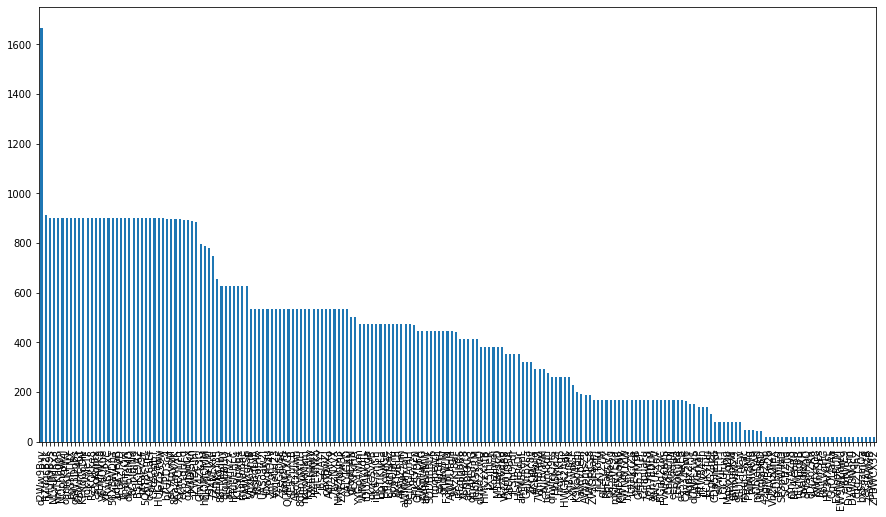

In [62]:
# plot how much data we have from each contract

contracts = df['contract_id'].value_counts() # count data points per contract and store it
contracts.plot(kind = 'bar', figsize = (15, 8))

Examining a simple count of contract IDs, we find many modes - 899 makes sense because data started being collected only on Jan 1, 2019 (899 days before this dataset was extracted), but others may be abnormal. And, since data was only collected from Jan 1, 2019, the contract with almost double that likely contains duplicates or faulty data. The same applies to the other contract with slightly more than 899 data points.

In [63]:
# frequency of number of data points (no. data points, no. contracts with that many data points)

contracts.value_counts()[contracts.value_counts() > 1]

899    28
18     27
169    22
535    22
475    12
444     9
79      7
626     7
383     6
414     5
261     4
353     4
49      3
291     3
138     3
322     3
898     3
186     2
44      2
891     2
534     2
153     2
504     2
Name: contract_id, dtype: int64

In [64]:
# use this cell to filter for common contract start dates vs ato dates vs service dates

for elem in contracts[contracts == 383].index:
    print(df[df['contract_id'] == elem][['production_date', 'ato_date', 'in_service_date']])

      production_date   ato_date in_service_date
29345      2020-06-01 2020-05-11      2020-05-11
29457      2020-06-02 2020-05-11      2020-05-11
29570      2020-06-03 2020-05-11      2020-05-11
29683      2020-06-04 2020-05-11      2020-05-11
29796      2020-06-05 2020-05-11      2020-05-11
...               ...        ...             ...
83272      2021-06-14 2020-05-11      2020-05-11
83472      2021-06-15 2020-05-11      2020-05-11
83672      2021-06-16 2020-05-11      2020-05-11
83872      2021-06-17 2020-05-11      2020-05-11
84072      2021-06-18 2020-05-11      2020-05-11

[383 rows x 3 columns]
      production_date   ato_date in_service_date
29356      2020-06-01 2020-05-14      2020-05-14
29469      2020-06-02 2020-05-14      2020-05-14
29582      2020-06-03 2020-05-14      2020-05-14
29695      2020-06-04 2020-05-14      2020-05-14
29808      2020-06-05 2020-05-14      2020-05-14
...               ...        ...             ...
83300      2021-06-14 2020-05-14      2020-05

As we can see, there are a number of contracts which only started collecting data on 6/1/2021, 1/1/2021, 1/1/2021, 3/1/2020, 4/1/2020, 4/1/2021, 10/1/2019, 6/1/2020, etc. (in order of frequency) regardless of their ato or in service dates. This likely means they are missing data (there is a gap between the in service date and the actual first production date when we started collecting data). Further, some in-service dates seem to be after our first production date, which shouldn't be the case. Likely these in-service dates are inaccurate.

In [65]:
# find exact discrepancies between in service dates and ato dates

group = df.groupby('contract_id') # group data by contract
ato_unique = group.apply(lambda x: x['ato_date'].unique()[0]) # get a series of ato dates for each contract
inservice_unique = group.apply(lambda x: x['in_service_date'].unique()[0]) # and in-service dates
first_production = group.apply(lambda x: x['production_date'].unique()[0]) # get first registered production date

diff = pd.DataFrame() # dataframe to store differences and spot discrepancies
diff['inservice - ato'] = inservice_unique - ato_unique
diff['production - ato'] = first_production - ato_unique
diff['production - inservice'] = first_production - inservice_unique
with pd.option_context('display.max_rows', None, 'display.max_columns', None): print(diff)

            inservice - ato production - ato production - inservice
contract_id                                                        
3NnJsDBD             0 days          78 days                78 days
42gm9ZRb             0 days          18 days                18 days
4CLfAuJq             1 days          21 days                20 days
4FbAzTVD             5 days          33 days                28 days
4qv9aTyM             0 days          28 days                28 days
4rAgZ5Jm            12 days           7 days                -5 days
56XBWDhT          -146 days          95 days               241 days
5Q6T8Cm7             0 days          34 days                34 days
6bjLVgHG             0 days          18 days                18 days
724NEKrh           -16 days          29 days                45 days
7SyafWwB             0 days          15 days                15 days
7WFfBRbZ             0 days           1 days                 1 days
7ZDKyY35            -1 days          12 days    

As we can see, indeed, in-service dates are a bit inconsistent. We should not see negative values in the dataframe above, but we do, meaning some in-service dates are listed as earlier than the ato dates (which would be illegal if not impossible as you can't turn the system on before you've built it and gotten it approved), and some in-service dates are listed as after the first production day for which we have data (meaning we have 'ghost' data from before the system was turned on). However, there are no negatives in the second column above, meaning ato dates are consistently earlier than starting production dates. As such, ato dates are likely accurate and can be used to replace any negative (e.g. wrong) in-service dates.

Further, there are some contracts where the in-service date is long after the ato date, which might be interesting to flag and look into.

In [66]:
# find any problematic contracts w/ wrong in-service dates

problematic = []
for contract in contracts.index:
    if diff['production - inservice'][contract].days < 0 or diff['inservice - ato'][contract].days < 0:
        problematic.append(contract)
        
print(problematic)

['d2Ww9Bvv', 'oamkKPWL', 'KPKdCoDN', 'S3cKontx', '56XBWDhT', 'btGiEv9F', 'ek6YqHFq', 'hFjQMQMM', '724NEKrh', '7ZDKyY35', 'VfjxGsmB', 'ShsBqLxA', 'UASoaw2J', 'Uxvgi5su', 'ZnPofD4v', 'Zeic9Vf8', 'QUMMnXGf', 'AkoCuuwn', '8dEpWXUH', 'KwY7q8rx', 'jZznhuwV', 'JAjENNkb', 'cexfBwZJ', 'Nh8Zkhm3', 'qfodEj4N', 'HpTiKwLa', 'HdxwiJGe', 'ETumf2az', '9p6Q6tTu', '4rAgZ5Jm', '8ejNGAmH', 'F3THFVUN']


In [67]:
# replace problematic in service dates

for i in df.index:
    if df['contract_id'][i] in problematic:
        df['in_service_date'][i] = df['ato_date'][i]

/Users/katherineli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [68]:
# flag any contracts for which in-service date is way after ato date (perhaps unreasonably so)

late_inservice = list(diff[diff['inservice - ato'].apply(lambda x: x.days) > 30].index)
print(late_inservice)

['8dEpWXUH', 'HUGZ57wv', 'HpTiKwLa', 'LCuKYfun', 'QUMMnXGf', 'RzKQkke8', 'S3cKontx', 'UASoaw2J', 'VfjxGsmB', 'XRwBvPxC', 'cQWc6aEf', 'dk7bTaMQ', 'ek6YqHFq', 'gXwfgdGx', 'hFjQMQMM', 'oamkKPWL', 'qfodEj4N']


Now that we have (most likely) accurate in-service dates, we can start to flag and deal with discrepancies in data collection, e.g. differences between age and number of production days.

In [69]:
# find any discrepancies between recorded ages of each contract (from in service date to today) and data points
# (there should be one data point per day, but most don't match)

group = df.groupby('contract_id') # update grouped dataframe since we changed the main one
inservice_fixed = group.apply(lambda x: x['in_service_date'].unique()[0]) # update in service dates
system_age = pd.to_datetime(datetime.date.today()) - inservice_fixed # age = difference from today
pseudo_age = pd.Series() # psuedo ages bc some older contracts only started collecting data on Jan 1 2019
for contract in contracts.index: # set any contracts w/ ato date before Jan 1 2019 to 899 days old
    if inservice_fixed[contract] < pd.to_datetime(datetime.date(2019, 1, 1)):
        pseudo_age[contract] = pd.to_datetime(datetime.date(2021, 6, 18)) - pd.to_datetime(datetime.date(2019, 1, 1))
    else:
        pseudo_age[contract] = system_age[contract]
        
differences = {} # create a dictionary to store differences between age and datapoints per contract (above)

print("Contract \t Age \t Count \t Difference")
for i in range(len(pseudo_age)):
    print(f"{pseudo_age.index[i]} \t {pseudo_age[i].days} \t {contracts[pseudo_age.index[i]]} \t \
{contracts[pseudo_age.index[i]] - pseudo_age[i].days}")
    differences[pseudo_age.index[i]] = contracts[pseudo_age.index[i]] - pseudo_age[i].days

Contract 	 Age 	 Count 	 Difference
d2Ww9Bvv 	 899 	 1668 	 769
RZdqcB2k 	 899 	 912 	 13
MUir9B9s 	 899 	 899 	 0
NLvUMRx3 	 899 	 899 	 0
nmTKhgg5 	 899 	 899 	 0
NQpn6W2J 	 899 	 899 	 0
oamkKPWL 	 899 	 899 	 0
pgSHiTNX 	 899 	 899 	 0
q5W3DpBs 	 899 	 899 	 0
Q5wHE4Ct 	 899 	 899 	 0
KPKdCoDN 	 899 	 899 	 0
rokVNeTF 	 899 	 899 	 0
RzKQkke8 	 899 	 899 	 0
S3cKontx 	 899 	 899 	 0
SfLMfWK8 	 899 	 899 	 0
Vp76QKue 	 899 	 899 	 0
XRwBvPxC 	 899 	 899 	 0
56XBWDhT 	 899 	 899 	 0
LdsFVeaB 	 899 	 899 	 0
4FbAzTVD 	 899 	 899 	 0
kndhjxQw 	 899 	 899 	 0
dk7bTaMQ 	 899 	 899 	 0
8GniqiNd 	 899 	 899 	 0
B5JKY9A2 	 899 	 899 	 0
btGiEv9F 	 899 	 899 	 0
5Q6T8Cm7 	 899 	 899 	 0
cQWc6aEf 	 899 	 899 	 0
CPoSogbT 	 899 	 899 	 0
HUGZ57wv 	 899 	 899 	 0
JeTiz59w 	 899 	 899 	 0
bTUPD3c4 	 899 	 898 	 -1
sK7fpynM 	 899 	 898 	 -1
8EaZmYXK 	 899 	 898 	 -1
XVnEQY7q 	 899 	 897 	 -2
ek6YqHFq 	 899 	 891 	 -8
gXwfgdGx 	 899 	 891 	 -8
Jx3DJ5Kn 	 899 	 887 	 -12
jZWEeuhJ 	 899 	 886 	 -13


/Users/katherineli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


In [70]:
# count how many contracts have no discrepancies (difference of 0 days between in service and production)

sum(d == 0 for d in differences.values())

28

After counting the number of data points per contract, we want to compare to the number we expect based on the age of each solar system. We calculate this by subtracting the in service date from the date on which this dataset was extracted. As we see above, there are many discrepancies - only 35 out of 200 contracts have the expected number of datapoints! However, most of these values are negative, meaning we have a lot of missing data (as opposed to extra / likely duplicated data). It might be interesting to see just how much data we're missing.

In [71]:
# sum the total number of days for which data seems to be missing

missingtotal = sum(sorted(differences.values())[:157])
print(missingtotal)
np.abs(missingtotal/(len(df.index) + missingtotal)) # as a percentage

-15048


0.2177555893205991

As we can see, we're missing a hefty portion of our data. For now, we will leave the missing data be. Later, in the data cleaning section, we may discuss methods to best approximate this data or just leave it out.

Next, we're also interested in the contracts with too much data, because we might have duplicates there.

In [72]:
# find any contracts with too much data (more than one per day since it went into service)

pd.Series(differences)[pd.Series(differences) > 0]

d2Ww9Bvv    769
RZdqcB2k     13
hFjQMQMM    177
t6Pwm8dh     39
dtype: int64

In [73]:
# use this cell to examine contracts with potential duplicates listed above

df[df['contract_id'] == 't6Pwm8dh']['production_date'][df[df['contract_id'] == 't6Pwm8dh']\
['production_date'].duplicated()]

60696   2021-02-01
60857   2021-02-02
61018   2021-02-03
61179   2021-02-04
61340   2021-02-05
           ...    
77645   2021-05-14
77819   2021-05-15
77993   2021-05-16
78167   2021-05-17
78341   2021-05-18
Name: production_date, Length: 107, dtype: datetime64[ns]

Indeed, all of the contracts with too much data do have duplicates. Interestingly, some of them are also missing data - the latter two. There might be other contracts with both duplicates and missing data that just cancel to 0, so we'll check all contracts for duplicate production dates. We'll also check some of the general characteristics of these contracts (those with duplicates).

In [74]:
for contract in contracts.index:
    if group.apply(lambda x: x['production_date'])[contract].duplicated().any():
        print(contract)

d2Ww9Bvv
RZdqcB2k
Giw4Zk3G
hFjQMQMM
t6Pwm8dh


In [75]:
# use this cell to filter dataframe for problematic contracts and examine them individually

df[df['contract_id'] == 'd2Ww9Bvv']

,holding_company_id,project_company_id,contract_id,size_kwdc,production_date,ato_date,actual_kwh,expected_kwh,weather_adjusted_expected_kwh,in_service_date,...,cref_short_name,subscriber_orginization,system_yield_as_built,system_yield_finance,annual_degradation_engr,annual_degradation_finance,yield,performance,low_performance_total,low_performance_consecutive
10,3,6,d2Ww9Bvv,259.8,2019-01-01,2018-08-01,216.092,486.384821,486.384821,2018-08-01,...,NaN,NaN,1291.8,1240.1,0.005,NaN,1.563873,0.444282,109,4
48,3,6,d2Ww9Bvv,259.8,2019-01-02,2018-08-01,104.560,486.384821,486.384821,2018-08-01,...,NaN,NaN,1291.8,1240.1,0.005,NaN,1.563873,0.214974,109,4
49,3,6,d2Ww9Bvv,259.8,2019-01-02,2018-08-01,52.417,486.384821,486.384821,2018-08-01,...,NaN,NaN,1291.8,1240.1,0.005,NaN,1.563873,0.107769,109,4
87,3,6,d2Ww9Bvv,259.8,2019-01-03,2018-08-01,171.890,486.384821,486.384821,2018-08-01,...,NaN,NaN,1291.8,1240.1,0.005,NaN,1.563873,0.353403,109,4
88,3,6,d2Ww9Bvv,259.8,2019-01-03,2018-08-01,87.335,486.384821,486.384821,2018-08-01,...,NaN,NaN,1291.8,1240.1,0.005,NaN,1.563873,0.179559,109,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83268,25,49,d2Ww9Bvv,259.8,2021-06-14,2018-08-01,1243.604,1233.297307,1233.297307,2018-08-01,...,NaN,NaN,1291.8,1240.1,0.005,NaN,1.563873,1.008357,109,4
83468,25,49,d2Ww9Bvv,259.8,2021-06-15,2018-08-01,1235.754,1233.297307,1233.297307,2018-08-01,...,NaN,NaN,1291.8,1240.1,0.005,NaN,1.563873,1.001992,109,4
83668,25,49,d2Ww9Bvv,259.8,2021-06-16,2018-08-01,1421.949,1233.297307,1233.297307,2018-08-01,...,NaN,NaN,1291.8,1240.1,0.005,NaN,1.563873,1.152965,109,4
83868,25,49,d2Ww9Bvv,259.8,2021-06-17,2018-08-01,1497.225,1233.297307,1233.297307,2018-08-01,...,NaN,NaN,1291.8,1240.1,0.005,NaN,1.563873,1.214002,109,4


Next, rows with duplicated production dates should be removed. With duplicated production dates, they seem to be mismatched on created_on and actual_kwh, with earlier (presumably non-updated) created_on dates corresponding to higher actual_kwh readings. These earlier readings will be deleted and only more recent created_on data will be maintained.

In [76]:
# delete duplicated data
duplicated = ['RZdqcB2k', 'Giw4Zk3G', 't6Pwm8dh', 'hFjQMQMM', 'd2Ww9Bvv']

for contract in duplicated:
    duplicates = df[df['contract_id'] == contract]['production_date']
    df.drop(duplicates[duplicates.duplicated(keep = 'last')].index, inplace = True)
    
group = df.groupby('contract_id') # re-group data by contract since some rows were deleted

#### 2.3.9 ATO Date

In [77]:
# new dataframe for grouped / integer ato dates to make analysis easier

df_ato = pd.DataFrame()
df_ato['year'] = group.apply(lambda x: x['ato_date'].dt.year.unique()[0])
df_ato['month'] = group.apply(lambda x: x['ato_date'].dt.month.unique()[0])
df_ato['production'] = group.apply(lambda x: x['actual_kwh'].mean())
df_ato['yield'] = group.apply(lambda x: x['yield'].mean())
df_ato['performance'] = group.apply(lambda x: x['performance'].mean())
df_ato['count'] = 1

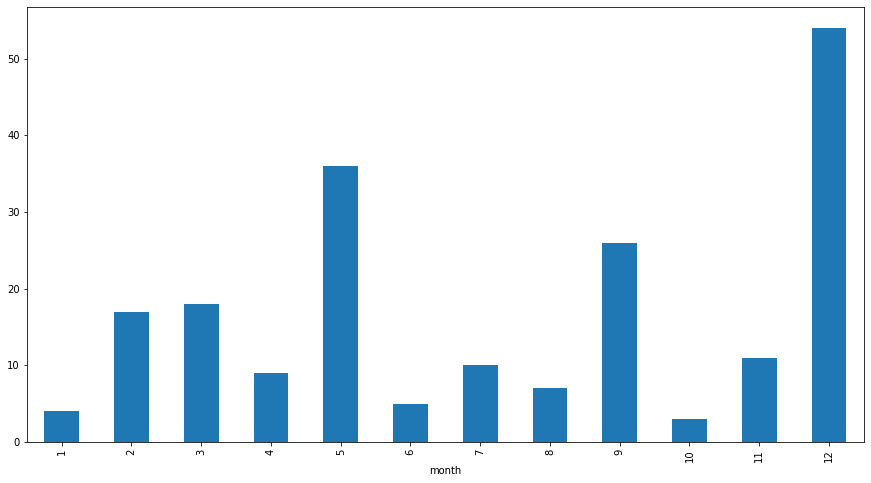

In [78]:
# plot how many systems have been allowed to open each month (total) - to get an idea of monthly trends

ato_month = df_ato.groupby('month')
ato_month.sum()['count'].plot(kind = 'bar', figsize = (15, 8))

First, we can plot a histogram of ato dates to see if there is a trend in the month a solar system tends to be created. As we can see, most are created in December as companies rush to meet year-end quotas, and not many are opened in January following. The peak seen in May is likely due to an influx of new contracts this year, May 2021, with our data for 2021 only leading up to mid-June.

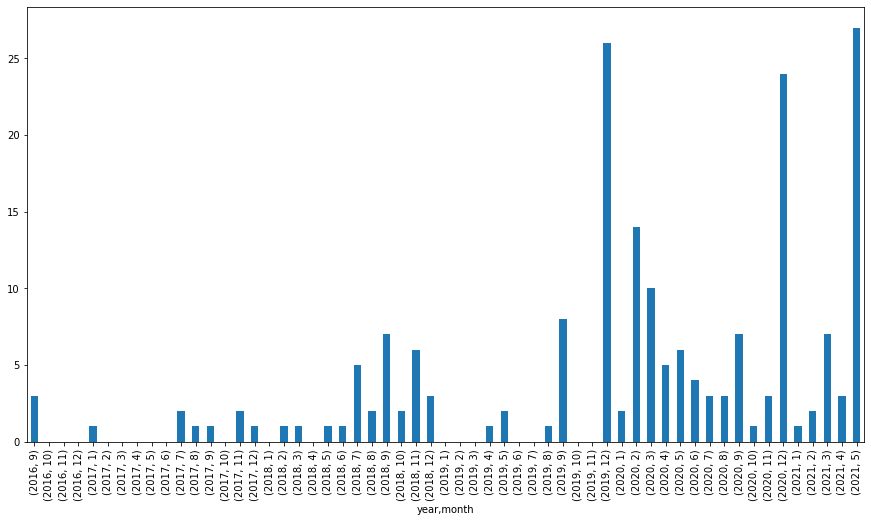

In [79]:
# plot how many systems were approved / completed / ready to open each month since Sep 2016

ato_groups = df_ato.groupby([df_ato['year'], df_ato['month']])
ato_count = ato_groups.count()['count'] # count occurrences of date groups

# for dates with 0 occurences, still add them as indices with values/counts of 0 for the bar plot
year = 2016
month = 9
while year < 2021:
    try:
        ato_count[(year, month)]
        if month == 12: 
            year += 1
            month = 1
        else: month += 1
    except:
        ato_count[(year, month)] = 0
        if month == 12: 
            year += 1
            month = 1
        else: month += 1
ato_count.sort_index(inplace = True)

ato_count.plot(kind = 'bar', figsize = (15, 8))

Breaking down our ato plot by year as well, we can see that more systems tend to be created each year as the company grows. Systems tend to peak in December, as observed before, and drop significantly for January. The fact that we only have data from September of 2016 may have also inflated the number in the month-only histogram above, causing the peak there. Interestingly, there are some months where no systems are created. Others, very few. However, evident by the peaks, the company must have the capacity to produce new systems quite quickly, making the lows potentially concerning in terms of demand. The peak this May may be due to the big deal with Franklin Park Infrastructure closed earlier this year. Below shows a cumulative plot of total systems over time (as opposed to only new systems created).

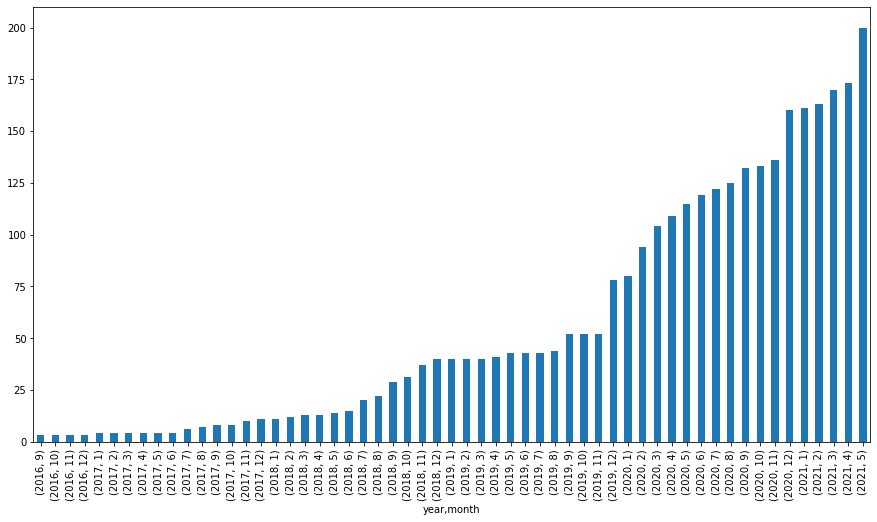

In [80]:
# cumulative number of systems since Sep 2016

ato_count.cumsum().plot(kind = 'bar', figsize = (15, 8))

We can also try plotting performance (a more standardized metric of production) by ato date to see if systems build or approved at different times yield different results (e.g. if, since so many systems are built in December, they perform better or worse).

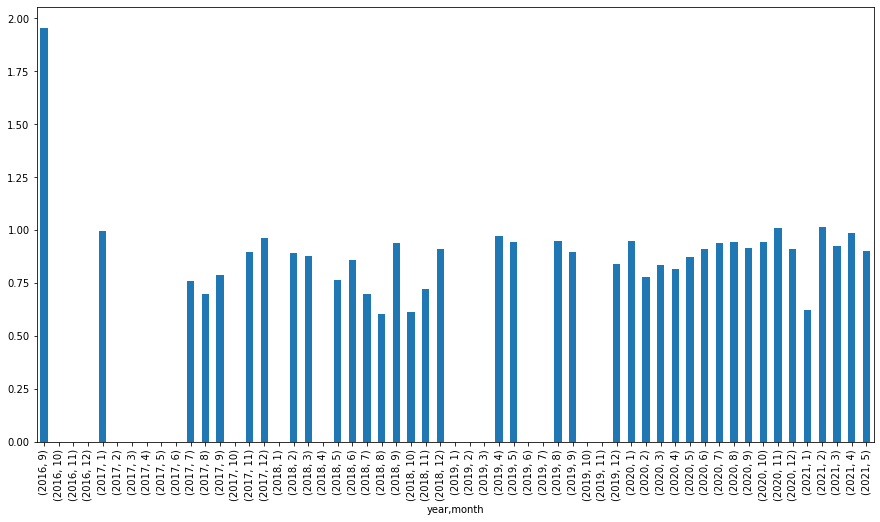

In [81]:
# plot average performance of systems built / licensed to open in each month since Sep 2016

ato_plot = ato_groups.mean()['performance']

year = 2016
month = 9
while year < 2021:
    try:
        ato_plot[(year, month)]
        if month == 12: 
            year += 1
            month = 1
        else: month += 1
    except:
        ato_plot[(year, month)] = 0
        if month == 12: 
            year += 1
            month = 1
        else: month += 1
ato_plot.sort_index(inplace = True)

ato_plot.plot(kind = 'bar', figsize = (15, 8))

Here, as we can see, systems built in September 2016 have an average performance of almost 200%! This is almost definitely an anomaly, and we should probably remove or fix those. They also might be interesting to look into, to find out why that happens. Other than that, performance looks pretty normal over time (e.g. doesn't vary too much with ato date, no obvious trends in earlier vs later systems).

In [82]:
# set these super-high performances to the average

df_ato.loc[df_ato[df_ato['year'] == 2016].index, ['performance']] = np.mean(df_ato['performance'])

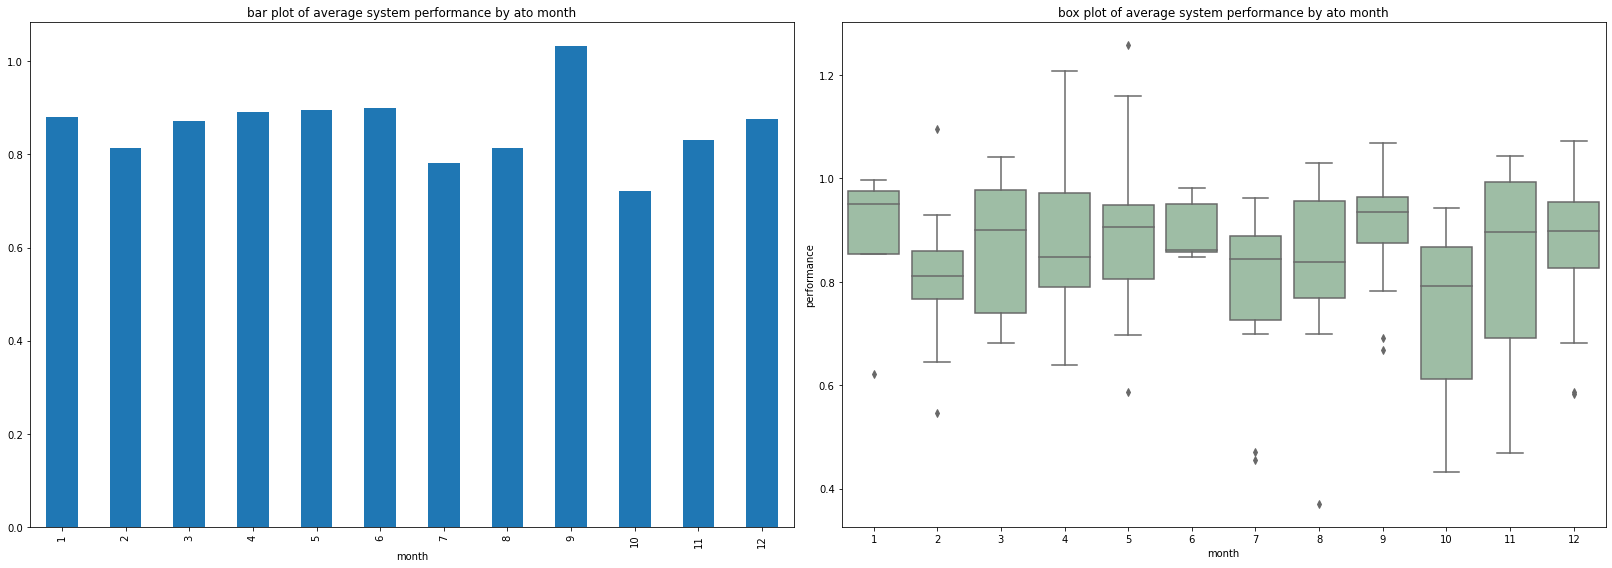

In [83]:
fig, axes = plt.subplots(nrows = 1, ncols = 2)

# average performance of systems valid to open each month (ato month)

ato_month.mean()['performance'].plot(kind = 'bar', figsize = (15, 8), ax = axes[0], \
title = 'bar plot of average system performance by ato month')

# boxplot of performance by ato month

sns.boxplot(x = 'month', y = 'performance', data = df_ato, color = '#99c2a2', ax = axes[1])\
.set_title('box plot of average system performance by ato month')

plt.tight_layout(rect = (0, 0, 1.5, 1))

Now, we can check to see the effect of ato date (or month) has a significant effect on a system's performance. It does look like systems made in October perform worse than the others, and some of the distributions do look like they have different means or ranges than others. However, doing a more detailed statistical analysis below, we can see that actually, none of the ato months is statistically significantly different than the others in terms of performance. It does appear from the extremely low Hedge's g that Octobor systems do perform worse than others, but our sample size is really too small to say, given that only 2 systems have ato dates in October (see histogram at the start of this section). So, ato date doesn't seem to affect performance too much.

In [84]:
print(f'month \t t-value \t\t p-value \t\t\t Hedge\'s g \t\t significant?')
for i in df_ato['month'].unique():
    month = df_ato[df_ato['month'] == i]['performance']
    others = df_ato[df_ato['month'] != i]['performance']
    print(f'{i} \t {difference_of_means(month, others, 2)[0]} \t {difference_of_means(month, others, 2)[1]} \
    \t {difference_of_means(month, others, 2)[3]} \t {difference_of_means(month, others, 2)[-1]}')

month 	 t-value 		 p-value 			 Hedge's g 		 significant?
2 	 -1.9272611818159564 	 0.07189446425527213     	 -0.4305777517477502 	 False
5 	 1.485153416984579 	 0.14645517875455666     	 0.24179422428984457 	 False
8 	 -0.6714046623465284 	 0.5269521394553325     	 -0.4102314643984987 	 False
11 	 -0.5945523263332311 	 0.5653512890722379     	 -0.27891463349653595 	 False
4 	 0.3922937736164591 	 0.7050855775392448     	 0.1711344342103114 	 False
9 	 2.08687395545478 	 0.04725430691986851     	 0.33434441189972564 	 False
12 	 0.6248416464816439 	 0.5347559441775607     	 0.08682448041365352 	 False
3 	 0.16801579507319234 	 0.8685534973679588     	 0.039102262817514215 	 False
7 	 -1.5422592920729876 	 0.15740278490088505     	 -0.6596709308767902 	 False
10 	 -0.9770101920917926 	 0.4316007424243805     	 -1.0729663102848461 	 False
6 	 1.1173304754789197 	 0.32643168862859523     	 0.23648085262124782 	 False
1 	 0.14047403737425648 	 0.8971869611171863     	 0.08840580316285507 	 

#### 2.3.10 In-Service Date

In [85]:
# new dataframe for grouped / integer ato dates to make analysis easier

df_inservice = pd.DataFrame()
df_inservice['year'] = group.apply(lambda x: x['in_service_date'].dt.year.unique()[0])
df_inservice['month'] = group.apply(lambda x: x['in_service_date'].dt.month.unique()[0])
df_inservice['production'] = group.apply(lambda x: x['actual_kwh'].mean())
df_inservice['yield'] = group.apply(lambda x: x['yield'].mean())
df_inservice['performance'] = group.apply(lambda x: x['performance'].mean())
df_inservice['count'] = 1

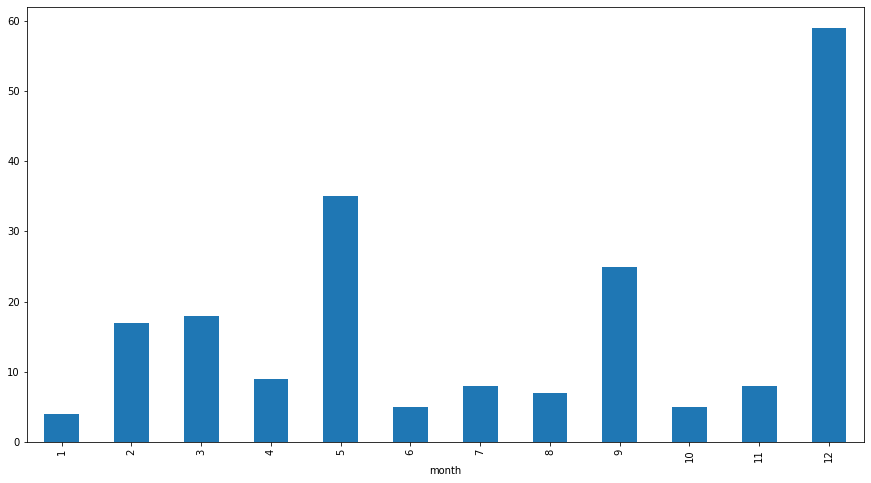

In [86]:
# plot how many systems have actually been opened each month

in_service_month = df_inservice.groupby('month')
in_service_month.sum()['count'].plot(kind = 'bar', figsize = (15, 8))

As we can see, the histogram above looks very similar to the one for ATO date and leads to the same conclusions. The same goes for the graphs below.

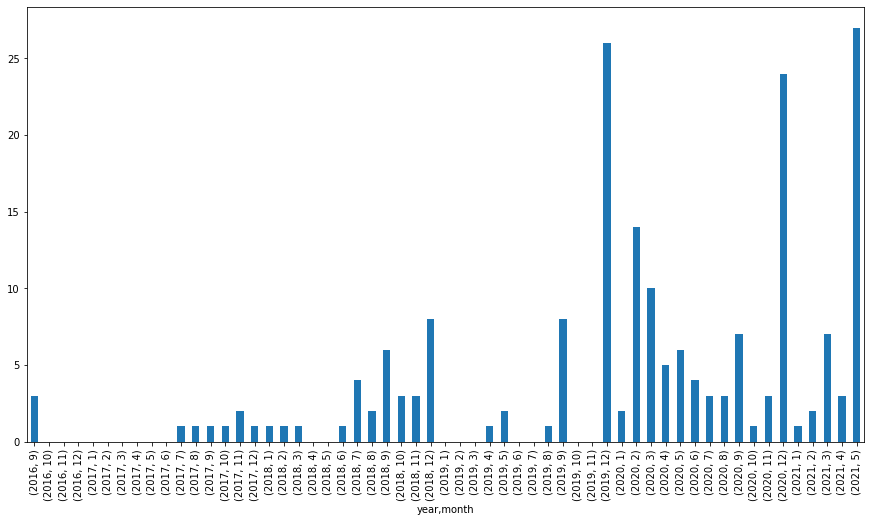

In [87]:
# plot how many systems were actually opened each month since Sep 2016

in_service_groups = df_inservice.groupby([df_inservice['year'], df_inservice['month']])
in_service_count = in_service_groups.count()['count'] # count occurrences of date groups

# for dates with 0 occurences, still add them as indices with values/counts of 0 for the bar plot
year = 2016
month = 9
while year < 2021:
    try:
        in_service_count[(year, month)]
        if month == 12: 
            year += 1
            month = 1
        else: month += 1
    except:
        in_service_count[(year, month)] = 0
        if month == 12: 
            year += 1
            month = 1
        else: month += 1
in_service_count.sort_index(inplace = True)

in_service_count.plot(kind = 'bar', figsize = (15, 8))

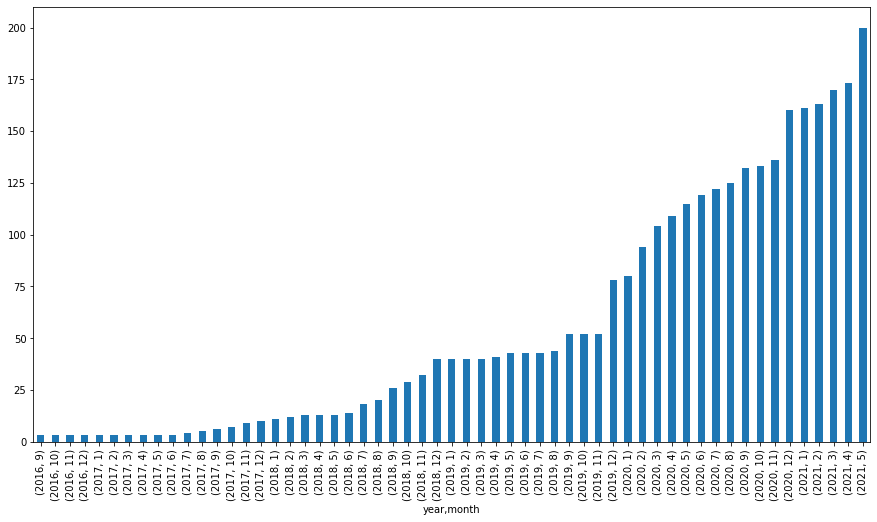

In [88]:
# cumulative number of systems since Sep 2016

in_service_count.cumsum().plot(kind = 'bar', figsize = (15, 8))

Plotting performance by in-service dates below (year/month), again, it looks similar to the plots we generated using ato dates and yields similar conclusions.

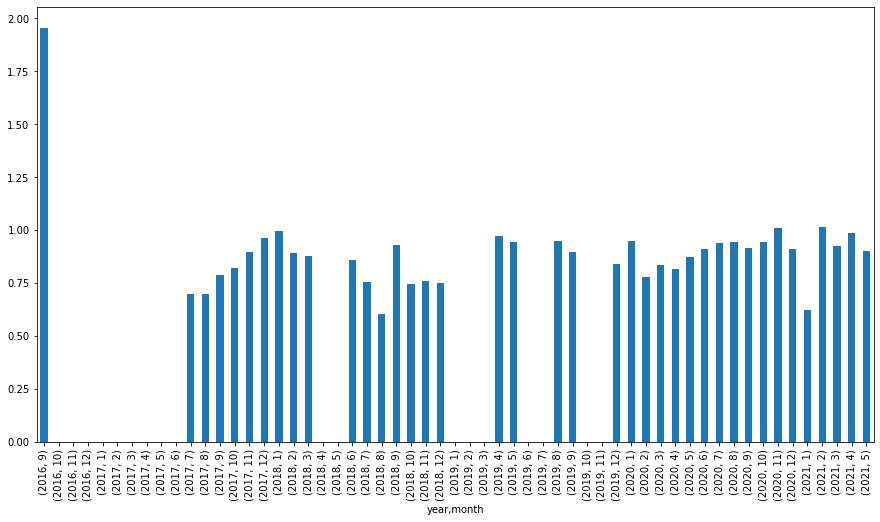

In [89]:
# plot average production of systems actually opened in each month since Sep 2016

in_service_plot = in_service_groups.mean()['performance']

year = 2016
month = 9
while year < 2021:
    try:
        in_service_plot[(year, month)]
        if month == 12: 
            year += 1
            month = 1
        else: month += 1
    except:
        in_service_plot[(year, month)] = 0
        if month == 12: 
            year += 1
            month = 1
        else: month += 1
in_service_plot.sort_index(inplace = True)

in_service_plot.plot(kind = 'bar', figsize = (15, 8))

Here, again, systems built in September 2016 have an average performance of ~200%, likely inaccurate. Other than that, performance, again, doesn't seem to show a clear trend in variation with system age.

In [90]:
# set super-high performances to the average

df_inservice.loc[df_inservice[df_inservice['year'] == 2016].index, ['performance']] = \
np.mean(df_inservice['performance'])

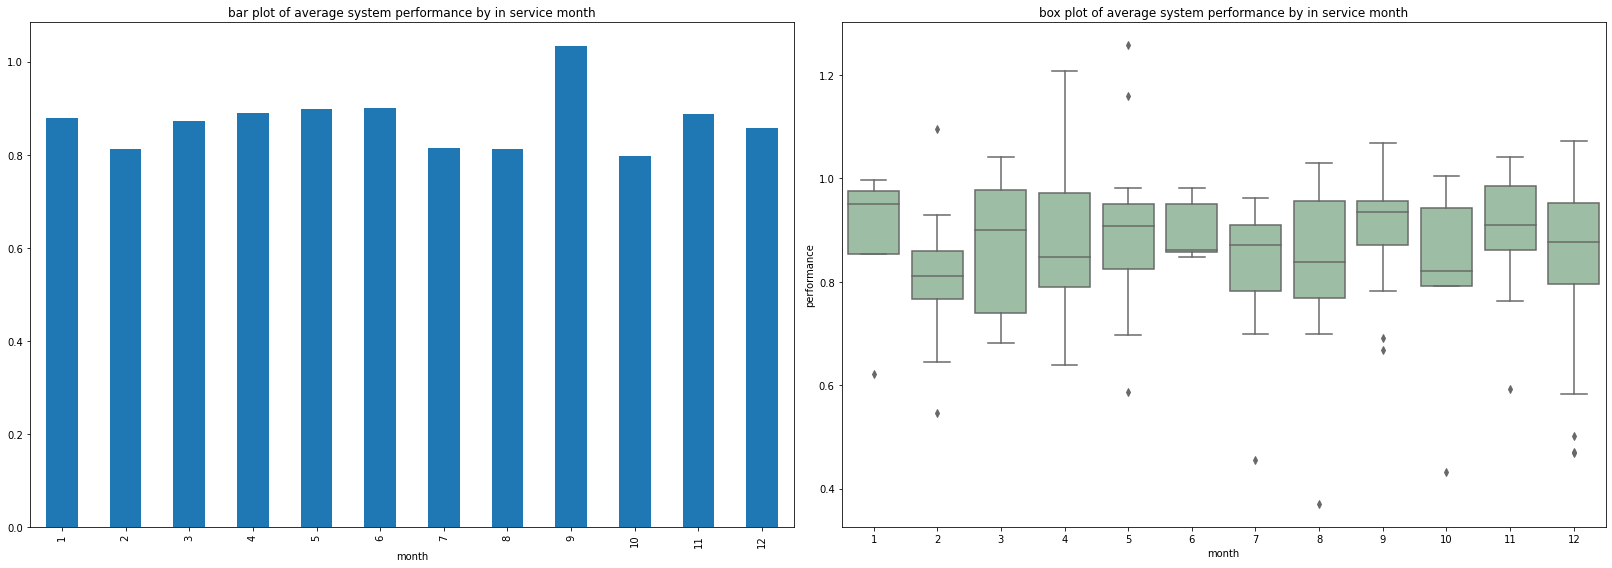

In [91]:
fig, axes = plt.subplots(nrows = 1, ncols = 2)

# average performance of systems opened (in-service) each month

in_service_month.mean()['performance'].plot(kind = 'bar', figsize = (15, 8), ax = axes[0], \
title = 'bar plot of average system performance by in service month')

# boxplot of average performance per in service month

sns.boxplot(x = 'month', y = 'performance', data = df_inservice, color = '#99c2a2', ax = axes[1])\
.set_title('box plot of average system performance by in service month')

plt.tight_layout(rect = (0, 0, 1.5, 1))

Here, too, approximately the same results as before - no significant effect of in service date on performance. One thing that could be interesting to note is that the effect size on november in service dates went from a small negative effect to a moderate positive effect. However, again, the sample size of November systems is less than 10, so not really enough to tell whether the difference is truly significant (e.g. we conclude it's not).

In [92]:
print(f'month \t t-value \t\t p-value \t\t\t Hedge\'s g \t\t significant?')
for i in df_inservice['month'].unique():
    month = df_inservice[df_inservice['month'] == i]['performance']
    others = df_inservice[df_inservice['month'] != i]['performance']
    print(f'{i} \t {difference_of_means(month, others, 2)[0]} \t {difference_of_means(month, others, 2)[1]} \
    \t {difference_of_means(month, others, 2)[3]} \t {difference_of_means(month, others, 2)[-1]}')

month 	 t-value 		 p-value 			 Hedge's g 		 significant?
2 	 -1.9272611818159564 	 0.07189446425527213     	 -0.4305777517477502 	 False
5 	 1.668141170627364 	 0.10447321277879107     	 0.2736443810519391 	 False
8 	 -0.6714046623465284 	 0.5269521394553325     	 -0.4102314643984987 	 False
12 	 -0.652375756493071 	 0.5167360963878646     	 -0.10107851227071127 	 False
4 	 0.3922937736164591 	 0.7050855775392448     	 0.1711344342103114 	 False
9 	 1.8473654313708943 	 0.07705833544159116     	 0.2997846942692656 	 False
11 	 0.3849255935190684 	 0.7117208321635704     	 0.14620775792996626 	 False
3 	 0.16801579507319234 	 0.8685534973679588     	 0.039102262817514215 	 False
7 	 -0.9101562709283137 	 0.39300048887225403     	 -0.39392146785443066 	 False
10 	 -0.7099054956391032 	 0.516956591758204     	 -0.5117726031148601 	 False
6 	 1.1173304754789197 	 0.32643168862859523     	 0.23648085262124782 	 False
1 	 0.14047403737425648 	 0.8971869611171863     	 0.08840580316285507 	 F

#### 2.3.11 (Production) Date

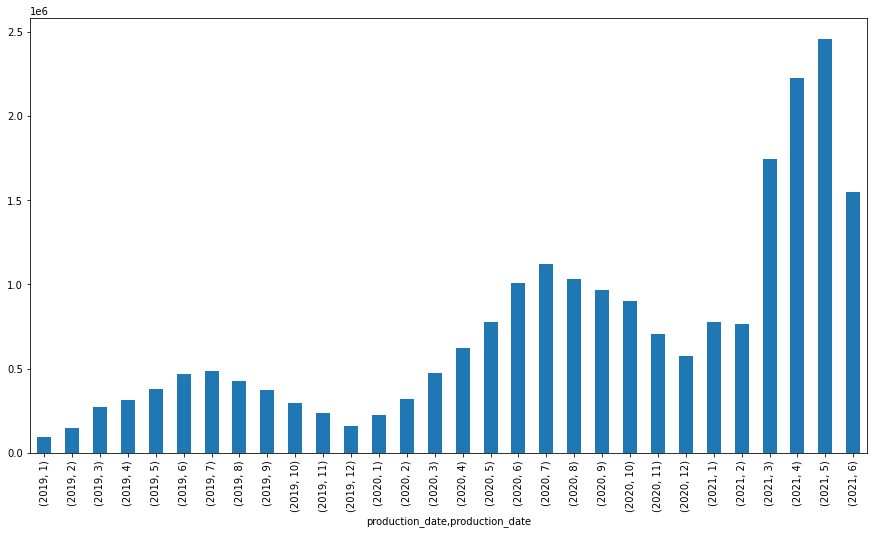

In [93]:
# plot TOTAL solar energy production as a function of time

production_date_grouped = df.groupby([df['production_date'].dt.year, df['production_date'].dt.month])

production_date_grouped.sum()['actual_kwh'].plot(kind = 'bar', figsize = (15, 8))

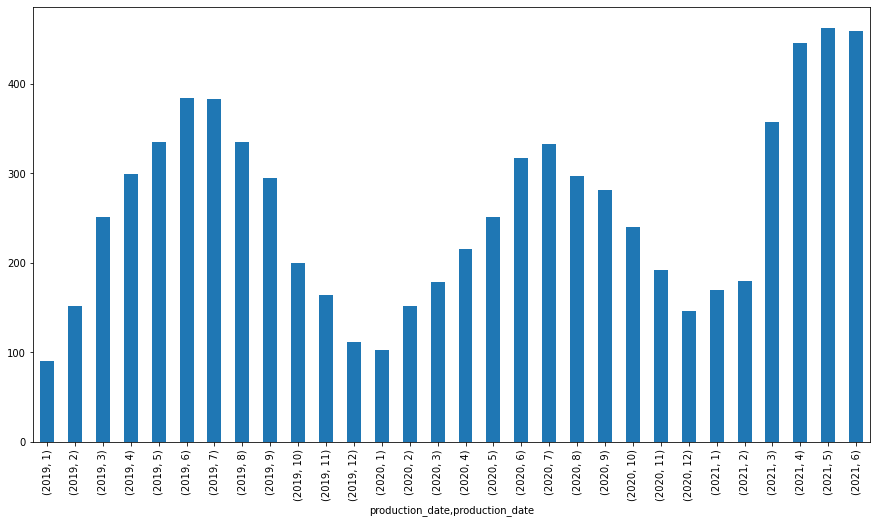

In [94]:
# plot average production of systems each month since Jan 2019 (when we started collecting production data)

production_plot = production_date_grouped.mean()['actual_kwh']

year = 2019
month = 1
while year < 2021:
    try:
        production_plot[(year, month)]
        if month == 12: 
            year += 1
            month = 1
        else: month += 1
    except:
        production_plot[(year, month)] = 0
        if month == 12: 
            year += 1
            month = 1
        else: month += 1
production_plot.sort_index(inplace = True)

production_plot.plot(kind = 'bar', figsize = (15, 8))

Here, the peaks have reached a more similar height and there isn't a clear upwards trend over the 3 years we have data for (3 years is also a very small sample to draw conclusions from, but the trend was pretty clear above in the plot of total production, plus it had a practical explanation). The slightly higher production in 2021 could be due to a number of factors, whether hotter weather or bigger average system size. Plotting average size over time, we do see a dip in size in 2020 and an increase in 2021, which matches the plot of average production above.

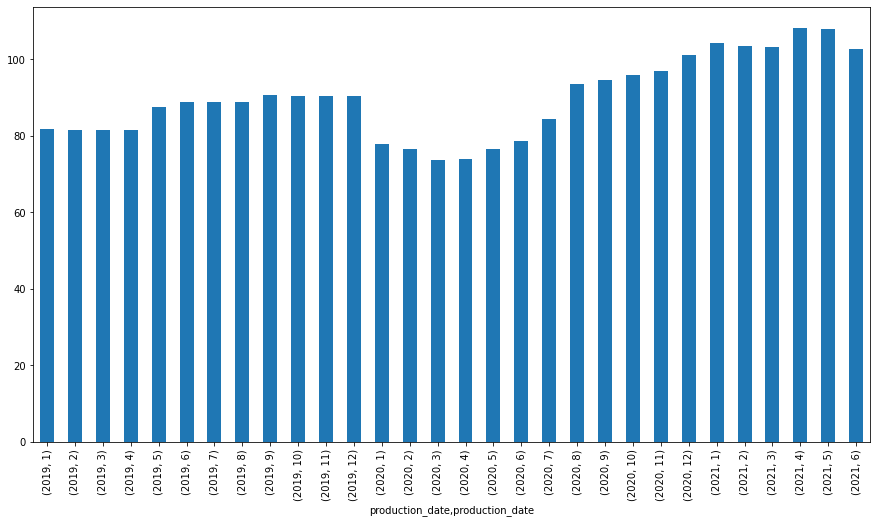

In [95]:
# average system size every month since 2019/01 (fluctuates as new systems are added)

production_date_grouped.mean()['size_kwdc'].plot(kind = 'bar', figsize = (15, 8))

Breaking down production into average per month (regardless or year, e.g. aggregating all years' data together), we see a peak in summer months and a dip in winter months with sunlight variation. This makes sense.

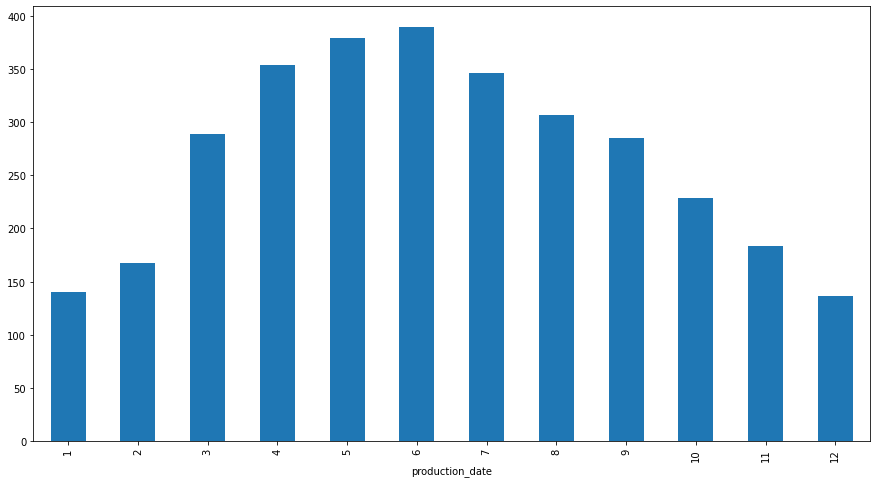

In [96]:
# average production per month disregarding year (over all years we have data for)

production_month = df.groupby(df['production_date'].dt.month)
production_month.mean()['actual_kwh'].plot(kind = 'bar', figsize = (15, 8))

Average performance, however, appears moderately constant, and there is no reason to think it wouldn't be.

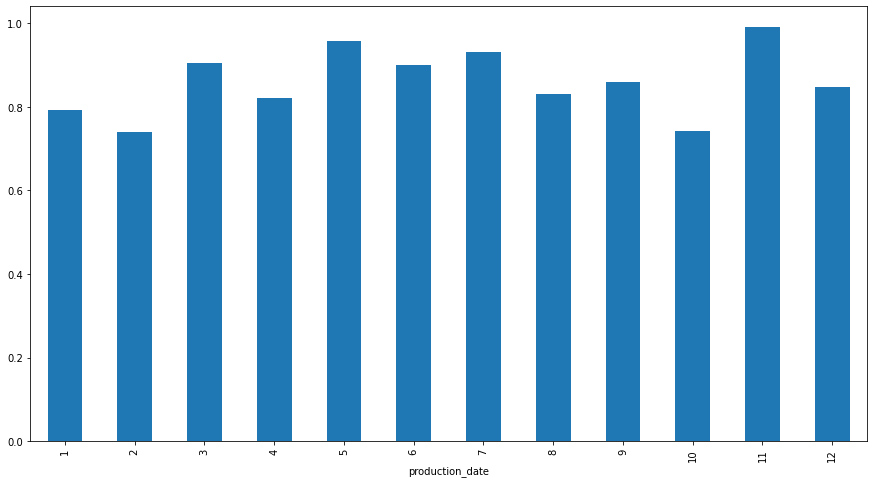

In [97]:
# average performance per month disregarding year (over all years we have data for)

production_month.mean()['performance'].plot(kind = 'bar', figsize = (15, 8))

#### 2.3.12 Host Type

In [98]:
# count unique contracts and type breakdowns for original data and supplementary data (slightly different)

id_unique = group.apply(lambda x: x['host_type'].unique()[0])
print(id_unique.value_counts())
print(df_contracts['host_type'].value_counts())

C&I            199
Residential      1
dtype: int64
C&I            217
Residential    168
Name: host_type, dtype: int64


As we can see, the supplementary data contains more contracts than the original. However, since we are focused on production, which is only found in the first dataframe, we will only be able to use those contracts in the main data. Further, since there is only one residential contract, we can consider it an anomaly or outlier and remove it.

In [99]:
# get rid of the singular residential contract

df.drop(df[df['host_type'] == 'Residential'].index, inplace = True)
group = df.groupby('contract_id') # re-group again by contract since some rows were deleted

#### 2.3.13 Revenue Type

In [100]:
# get a summary of what types of revenue types exist and how many of each there are

df['revenue_type'].value_counts()

CREF                 21110
NEM                   9114
SFA                   3571
Ethos Prepaid PPA     2674
PPA                   1299
NEM PPA               1262
Name: revenue_type, dtype: int64

First, just getting an idea of what this column contains, most contracts have a revenue type called "CREF." However, there are far more missing values than any category; of ~84k data points, less than half have revenue types filled in. So, it might be useful to mark those missing values as "missing," a new category that we can keep track of for further analysis.

In [101]:
# since there seem to be many missing values, insert "missing" to those slots

df['revenue_type'].fillna('missing', inplace = True)

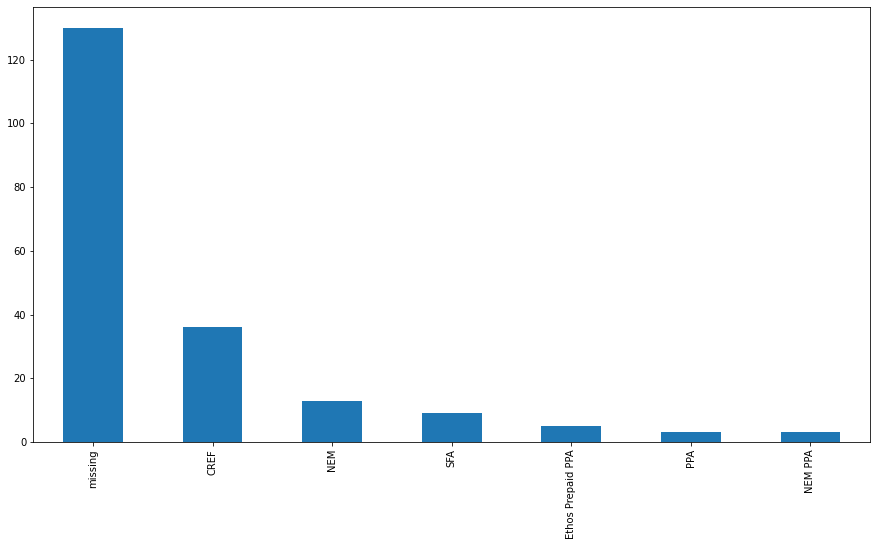

In [102]:
# plot consolidated categories and their counts by contract

revenue_type_unique = group.apply(lambda x: x['revenue_type'].unique()[0])
revenue_type_unique.value_counts().plot(kind = 'bar', figsize = (15, 8))

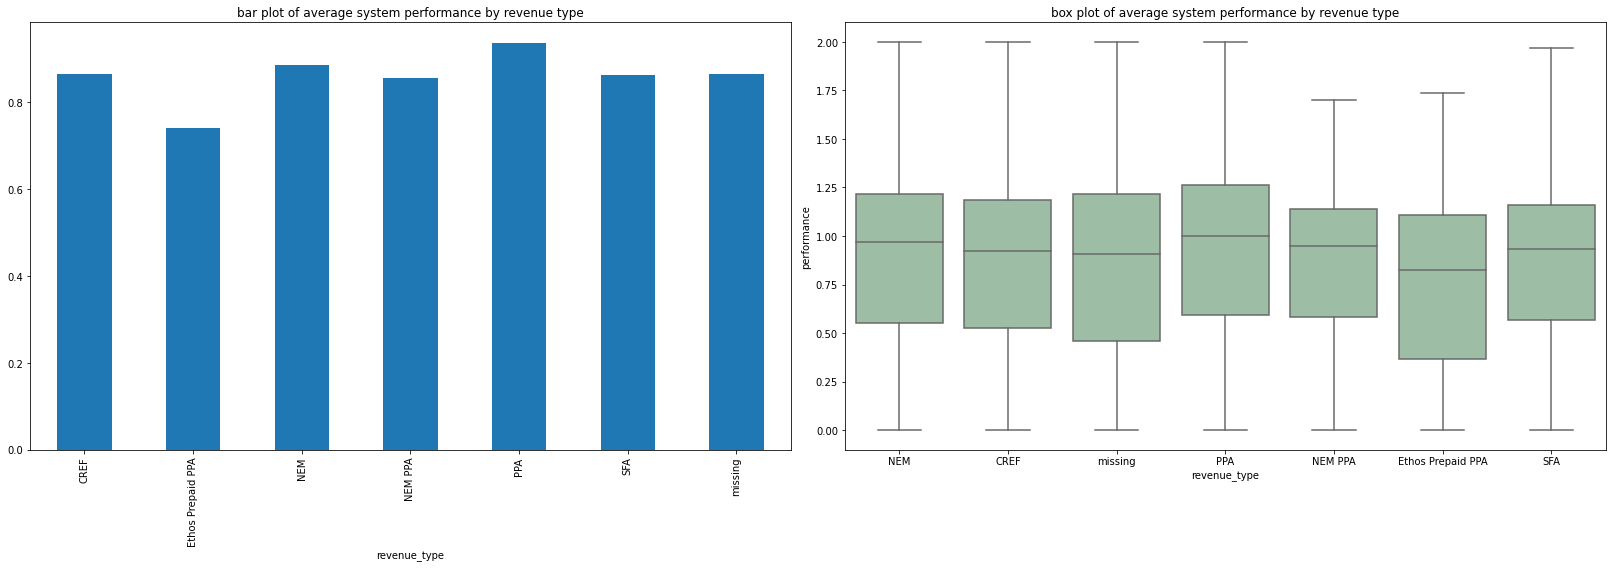

In [103]:
fig, axes = plt.subplots(nrows = 1, ncols = 2)

# average performance of systems by revenue type

df.groupby('revenue_type').mean()['performance'].plot(kind = 'bar', figsize = (15, 8), ax = axes[0], \
title = 'bar plot of average system performance by revenue type')

# boxplot of performance per revenue type

sns.boxplot(x = 'revenue_type', y = 'performance', data = df, color = '#99c2a2', ax = axes[1])\
.set_title('box plot of average system performance by revenue type')

plt.tight_layout(rect = (0, 0, 1.5, 1))

Next, plotting average production by revenue type, the distributions of performance do look like they could be slightly different, but not very much so. The means hover around 0.8 or 0.9 and vary pretty much across the entire limited range of 0 to 2. Calculating significance values, almost half are statistically significant, but none are practically significant. In particular, it may be interesting to note that missing values are neither practically nor significantly different than the aggregate. That means missing values in this column do not correspond with variations in performance. Still, doing an anova test also reveals a statistically significant result. It is potentially plausible that revenue type has some small effect on performance, with PPA performing best and Ethos Prepaid PPA performing worst. However, there more likely is not a strong relationship between revenue type and performance, as there doesn't seem to exist a reasonable explanation for why this difference might occur (unless there is?). To get an idea of the difference:

In [104]:
print(f'revenue type \t\t t-value \t\t p-value \t\t\t Hedge\'s g \t\t significant?')
for i in df['revenue_type'].unique():
    rev = df[df['revenue_type'] == i]['performance']
    others = df[df['revenue_type'] != i]['performance']
    h_test = difference_of_means(rev, others, 2)
    if i == "missing" or i == "NEM PPA":
        print(f'{i} \t\t {h_test[0]} \t {h_test[1]} \
    \t {h_test[3]} \t {h_test[-1]}')
    elif i == "Ethos Prepaid PPA":
        print(f'{i} \t {h_test[0]} \t {h_test[1]} \
    \t {h_test[3]} \t {difference_of_means(rev, others, 2)[-1]}')
    else:
        print(f'{i} \t\t\t {h_test[0]} \t {h_test[1]} \
    \t {h_test[3]} \t {h_test[-1]}')

revenue type 		 t-value 		 p-value 			 Hedge's g 		 significant?
NEM 			 4.552877949423986 	 5.360327858117064e-06     	 0.049110813101959645 	 True
CREF 			 0.4547977500362304 	 0.6492594260360629     	 0.00339729080810012 	 False
missing 		 0.6752478789686769 	 0.49952229239336143     	 0.004683192005989574 	 False
PPA 			 6.012939058984856 	 2.364701744832636e-09     	 0.1557591286459038 	 True
NEM PPA 		 -0.6663386374256148 	 0.5053165598966163     	 -0.01500285177853044 	 False
Ethos Prepaid PPA 	 -14.492600958354183 	 7.075165673144895e-46     	 -0.26839027984606917 	 True
SFA 			 -0.1999591832653465 	 0.8415238923225467     	 -0.0028480637932383865 	 False


In [105]:
print(f'average production: {np.mean(df["performance"])}')
      
revenue_effect = ['PPA', 'Ethos Prepaid PPA']
for r in revenue_effect:
      print(f'company {r} production: {np.mean(df[df["revenue_type"] == r]["performance"])}')

average production: 0.8635885637232005
company PPA production: 0.9368345610437817
company Ethos Prepaid PPA production: 0.7397447670689983


In [106]:
anova_revenue = ols('performance ~ C(revenue_type)', data=df).fit()
statsmodels.stats.anova_lm(anova_revenue, typ=2)

,sum_sq,df,F,PR(>F)
C(revenue_type),51.551766,6.0,37.703238,5.733908e-46
Residual,18008.525628,79025.0,NaN,NaN


In [107]:
# add potentially significant predictors
for elem in revenue_effect:
    predictors.append('reve_' + elem)

#### 2.3.14 Interconnection Type

In [108]:
# get a summary of what types of interconnection types exist and how many of each there are

df['interconnection_type'].value_counts()

NEM     38697
CREF    38605
Name: interconnection_type, dtype: int64

Looking at the breakdown of interconnection types, we see that the values in this column are the same as some of the values in the last 'revenue type' column. However, there are many more filled values here (still some missing).

In [109]:
# still some many missing values, so insert "missing" to those slots

df['interconnection_type'].fillna('missing', inplace = True)

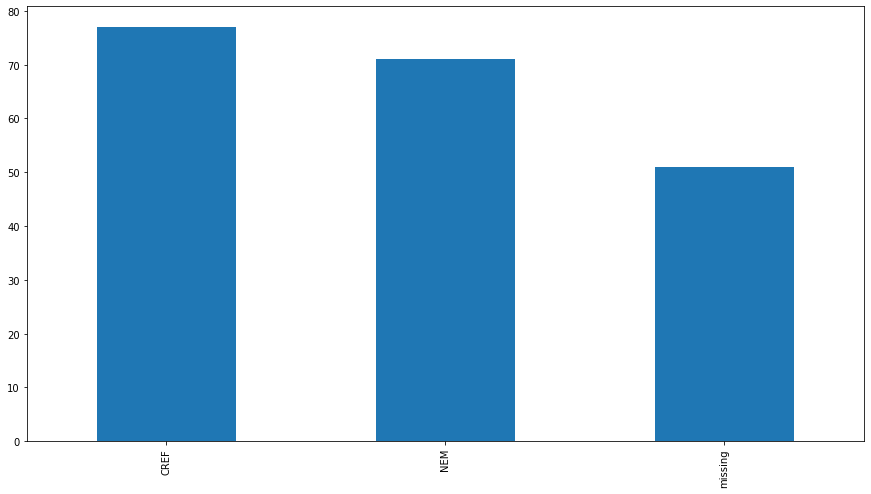

In [110]:
# plot consolidated categories and their counts by contract

interconnection_type_unique = group.apply(lambda x: x['interconnection_type'].unique()[0])
interconnection_type_unique.value_counts().plot(kind = 'bar', figsize = (15, 8))

Plotting a histogram of interconnection types and their counts, missing values actually take up the smallest share! It might also be interesting to see a breakdown of revenue type for each interconnection type.

In [111]:
# breakdown of revenue types for contracts with interconnection type 'CREF'

df[df['interconnection_type'] == 'CREF']['revenue_type'].value_counts()

CREF                 20497
missing              12398
SFA                   3571
Ethos Prepaid PPA     2139
Name: revenue_type, dtype: int64

In [112]:
# breakdown of revenue types for contracts with interconnection type 'NEM'

df[df['interconnection_type'] == 'NEM']['revenue_type'].value_counts()

missing    26409
NEM         9114
PPA         1299
NEM PPA     1262
CREF         613
Name: revenue_type, dtype: int64

In [113]:
# breakdown of revenue types for contracts with missing interconnection type 

df[df['interconnection_type'] == 'missing']['revenue_type'].value_counts()

missing              4225
Ethos Prepaid PPA     535
Name: revenue_type, dtype: int64

Here, it looks like contracts with missing interconnection types have significantly less data points than those with filled-in interconnection types. It might be interesting to get the average sizes or ages of these contracts to compare (general descriptive stats of numeric columns for each type).

In [114]:
# add a column to dataframe for (system) age

df['system_age'] = df.apply(lambda x: system_age[x['contract_id']].days, axis=1)

In [115]:
# get some grouped statistics for each interconnection type

df.groupby('interconnection_type').mean()[['size_kwdc', 'actual_kwh', 'expected_kwh', \
'weather_adjusted_expected_kwh', 'system_yield_as_built', 'yield', 'performance', 'system_age']]

,size_kwdc,actual_kwh,expected_kwh,weather_adjusted_expected_kwh,system_yield_as_built,yield,performance,system_age
interconnection_type,,,,,,,,
CREF,75.530299,227.142585,261.01432,255.874759,1230.633670,3.022783,0.861904,653.108173
NEM,106.580874,305.772840,362.49452,356.186998,1175.158909,2.805300,0.865631,991.591493
missing,141.406227,480.641869,504.51895,513.042618,1228.600084,3.198133,0.860994,357.994328


As we can see, actually, while performance between the three interconnection types is almost exactly the same (both in terms of mean and sd, as seen in the box plots below), pretty much every other metric differs between the groups. We won't do significance testing here, because our dependent variable of interest is primarily performance, but it does seem that systems with missing values tend to be biggest (\~140 kwdc) and youngest (1 yr) with higher expected and actual production (\~480 kwh / day), while CREF systems are smallest (\~75 kwdc) and produce the least (\~225 kwh per day / and 2 yrs old). The NEM systems are, on average, oldest (3 yr), mid-sized (\~105 kwdc) and mid-producing (\~305 kwh / day). However, again, distributions of performance don't seem to vary with interconnection type at all, so we will not explore this column further.

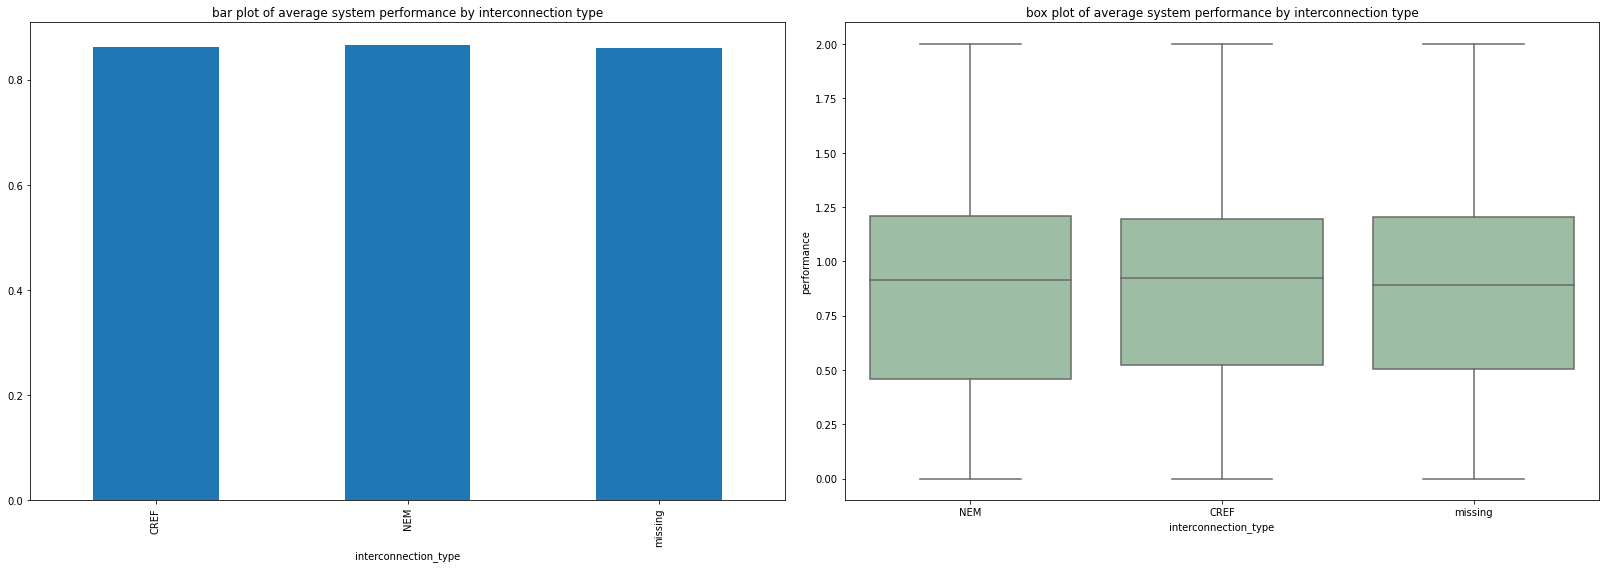

In [116]:
fig, axes = plt.subplots(nrows = 1, ncols = 2)

# average performance of systems of each interconnection type

df.groupby('interconnection_type').mean()['performance'].plot(kind = 'bar', figsize = (15, 8), ax = axes[0], \
title = 'bar plot of average system performance by interconnection type')

# boxplot of performance by interconnection type

sns.boxplot(x = 'interconnection_type', y = 'performance', data = df, color = '#99c2a2', ax = axes[1])\
.set_title('box plot of average system performance by interconnection type')

plt.tight_layout(rect = (0, 0, 1.5, 1))

#### 2.3.15 Registry Facility

In [117]:
# get a summary of what types of registry facilities exist and how many of each there are

df['registry_facility_name'].value_counts()

NON241648           899
NON241348           899
NON241700           899
NON241371           899
NON242065           899
                   ... 
Unassigned 12/16    169
NON313489           153
NON313490           153
NON241602           138
NON280635           138
Name: registry_facility_name, Length: 121, dtype: int64

In [118]:
# check how many rows are filled in so we can see if there are any missing values

sum(df['registry_facility_name'].value_counts())

65020

In [119]:
# since there are missing values, mark them

df['registry_facility_name'].fillna('missing', inplace = True)

Here, the value and counts of registry facilities seem similar to contract IDs, a unique identifier rather than categorization. However, we're still interested in how many missing values there are and whether or not there may be a difference in production based on whether or not values are filled in.

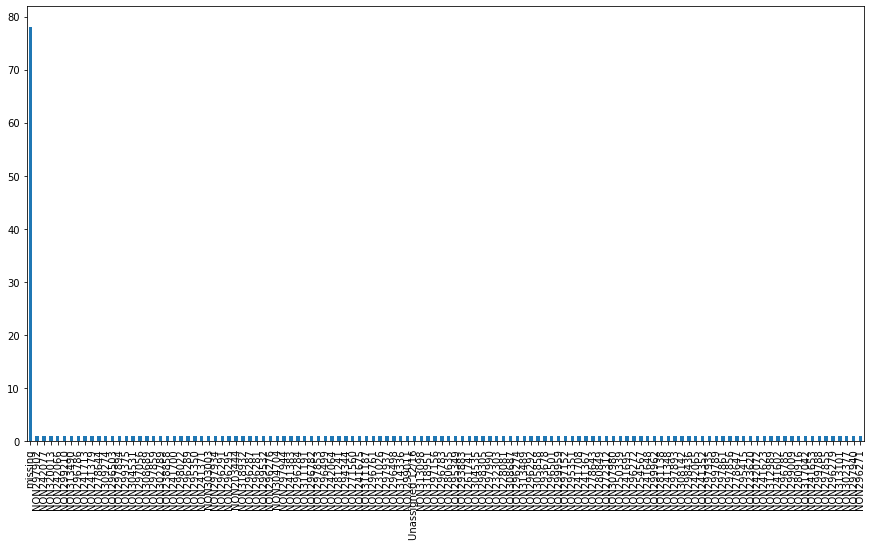

In [120]:
# plot consolidated categories and counts by contract

registry_facility_unique = group.apply(lambda x: x['registry_facility_name'].unique()[0])
registry_facility_unique.value_counts().plot(kind = 'bar', figsize = (15, 8))

In [121]:
# create a new column that keeps track of only whether or not registry facility is filled in
# disregards specific registry facility names

df['rf_missing'] = df.registry_facility_name.apply(lambda x: 'True' if x == 'missing' else 'False')

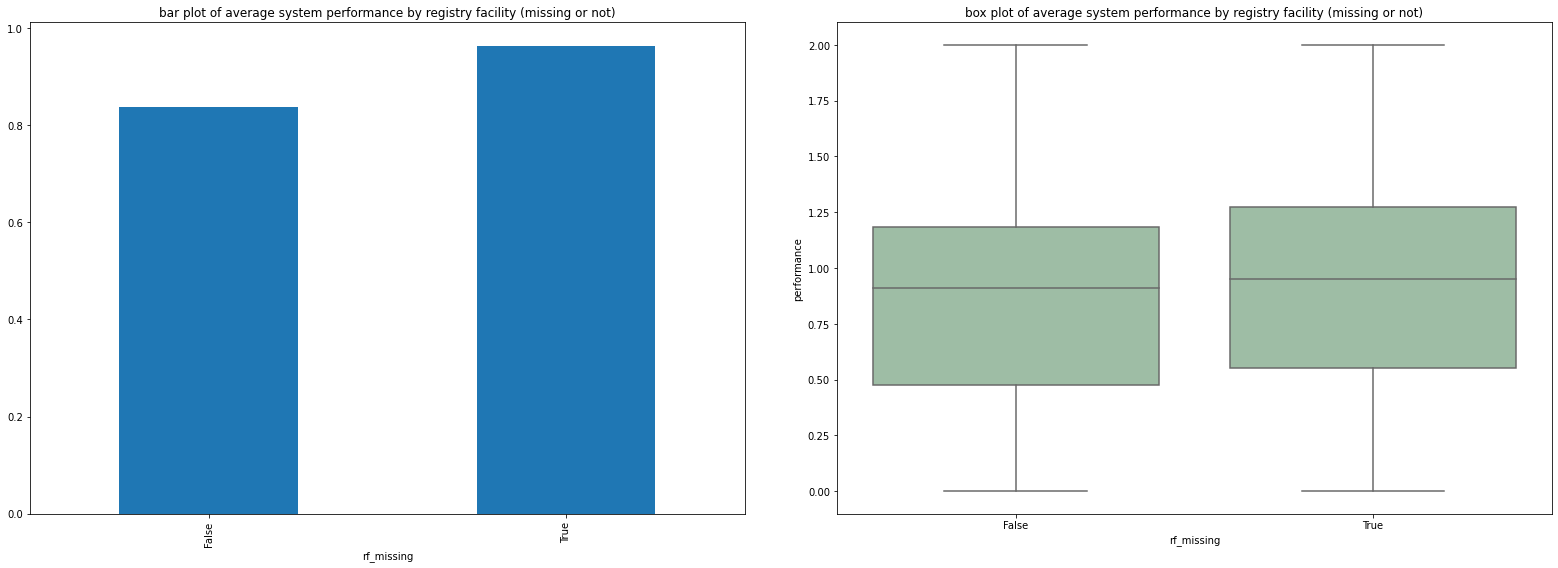

In [122]:
fig, axes = plt.subplots(nrows = 1, ncols = 2)

# average performance of systems by registry facility missing or filled

df.groupby('rf_missing').mean()['performance'].plot(kind = 'bar', figsize = (15, 8), ax = axes[0], \
title = 'bar plot of average system performance by registry facility (missing or not)')

# boxplot of performance - registry facility missing or filled

sns.boxplot(x = 'rf_missing', y = 'performance', data = df, color = '#99c2a2', ax = axes[1])\
.set_title('box plot of average system performance by registry facility (missing or not)')

plt.tight_layout(rect = (0, 0, 1.5, 1))

Evidently, there is a bit of difference in performance between contracts with filled-in registry facilities and those without, but the difference is actually in the opposite direction that we would expect. In fact, while we might expect contracts without registry facilities to perform worse as maybe the company doesn't pay as much attention to them or care as much about them, they perform significantly better (statistically). Practically, this difference isn't really significant, but some difference is apparent, whether it indicates a true relationship or not.

In [123]:
print(f'rf missing? \t t-value \t\t p-value \t\t\t Hedge\'s g \t\t significant?')
for i in df['rf_missing'].unique():
    rt = df[df['rf_missing'] == i]['performance']
    others = df[df['rf_missing'] != i]['performance']
    print(f'{i} \t\t {difference_of_means(rt, others, 2)[0]} \t {difference_of_means(rt, others, 2)[1]} \
    \t {difference_of_means(rt, others, 2)[3]} \t {difference_of_means(rt, others, 2)[-1]}')

rf missing? 	 t-value 		 p-value 			 Hedge's g 		 significant?
False 		 -27.902213228126012 	 1.435670539854837e-167     	 -0.2645059132184005 	 True
True 		 27.902213228126012 	 1.435670539854837e-167     	 0.2645059132184005 	 True


In [124]:
df.groupby('rf_missing').mean()['performance']

rf_missing
False    0.837910
True     0.963726
Name: performance, dtype: float64

#### 2.3.16 CREF

In [125]:
# get a summary of what CREF types exist and how many of each there are

df['cref_short_name'].value_counts()

NCS05    899
NCS06    899
NCS04    899
NCS02    899
NCS07    898
NCS01    898
NCS03    898
NCS09    891
NCS11    748
NCS10    626
NCS13    626
NCS18    626
NCS16    626
NCS14    626
NCS15    626
NCS17    444
NCS19    444
NCS08    138
Name: cref_short_name, dtype: int64

In [126]:
# again, there seem to be a lot of missing values, so mark them "missing"

df['cref_short_name'].fillna('missing', inplace = True)

This column, like the one above, seems to contain unique identifiers, this time for 'CREF names'. However, it has FAR more missing values than does the registry facility column. As we can see below, more than 180 of our 200 contracts are missing this data! We don't even have 30 contracts with filled-in CREF names, so it's probably not worth it to do any analysis on breakdowns in this column.

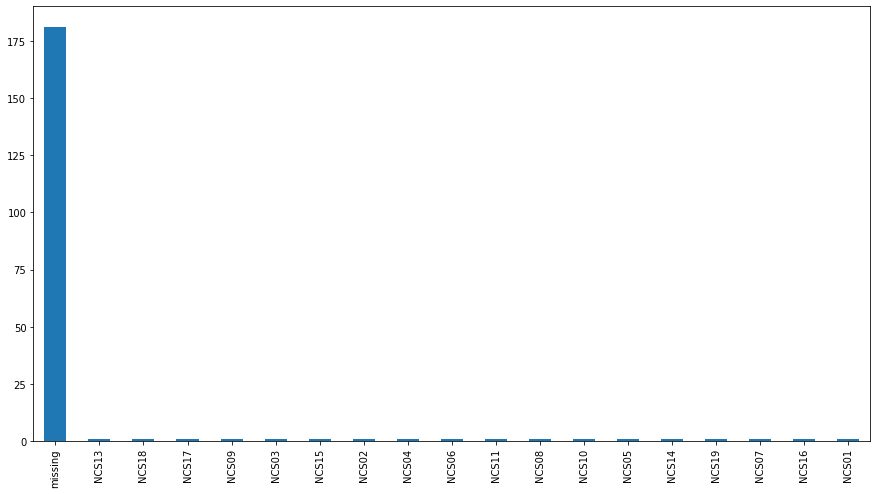

In [127]:
# plot consolidated categories and counts by contract

cref_unique = group.apply(lambda x: x['cref_short_name'].unique()[0])
cref_unique.value_counts().plot(kind = 'bar', figsize = (15, 8))

#### 2.3.17 Subscriber Organization

In [128]:
# get a summary of what subscriber organizations exist and how many of each there are

df['subscriber_orginization'].value_counts()

Arcadia        6428
CleanChoice    6283
Name: subscriber_orginization, dtype: int64

In [129]:
# mark missing values

df['subscriber_orginization'].fillna('missing', inplace = True)

Here, too, we have too many missing values to really make anything of this column.

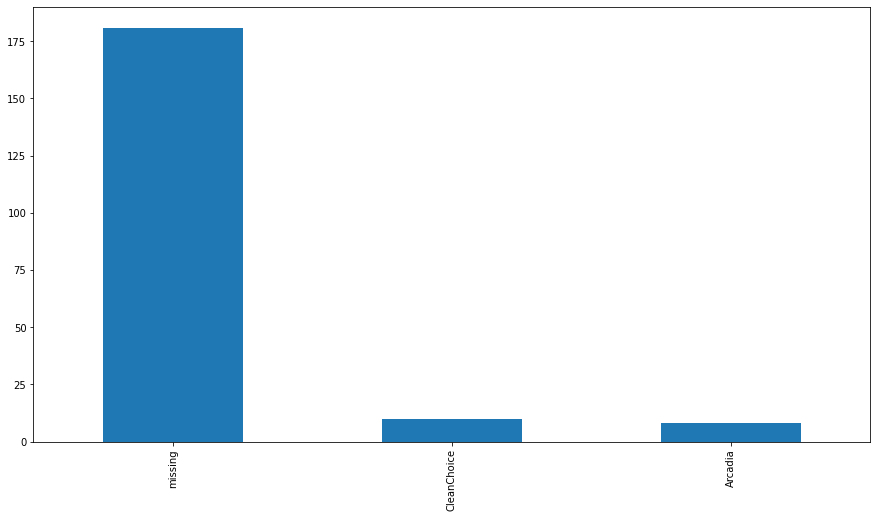

In [130]:
# plot counts by contract

subscriber_organization_unique = group.apply(lambda x: x['subscriber_orginization'].unique()[0])
subscriber_organization_unique.value_counts().plot(kind = 'bar', figsize = (15, 8))

In [131]:
subscriber_organization_unique.value_counts()

missing        181
CleanChoice     10
Arcadia          8
dtype: int64

#### 2.3.18 Degradation

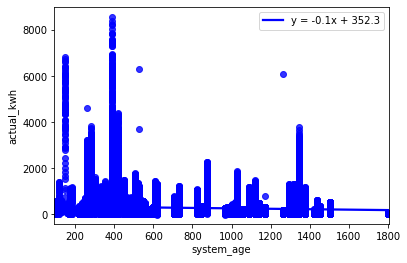

In [132]:
# plot system age versus degradation for an overall idea of degradation across systems

degradation = df[['system_age', 'actual_kwh']].dropna()

# get coefs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(degradation['system_age'], degradation['actual_kwh'])

# use line_kws to set line label for legend
ax = sns.regplot(x = 'system_age', y = 'actual_kwh', data = degradation, color = 'b', \
line_kws = {'label':"y = {0:.1f}x + {1:.1f}".format(slope,intercept)})

ax.legend()
plt.show() # slope on this graph = daily degradation in kwh

In [133]:
# next, create a column for individual ages (for each data point, what's the age of the system at that point?)

df['ages'] = (df['production_date'] - df['in_service_date']).dt.days

In [134]:
# as a percentage

slope/np.mean(df['actual_kwh'].dropna())

-0.00034082130564098187

In [135]:
# regression to find degradation per contract / system

degradations = {}

for contract in contracts.index:
    df_degradation = df[df['contract_id'] == contract][['ages', 'actual_kwh']].dropna()
    if not df_degradation.empty:
        degradations[contract] = stats.linregress(df_degradation['ages'], df_degradation['actual_kwh'])

In [136]:
# convert degradation to percentages

degradation_percent = {}
for elem in degradations.items():
    degradation_percent[elem[0]] = elem[1][0]/(group.mean()['actual_kwh'][elem[0]])

In [137]:
# average degradation after breaking down by contract

np.mean(list(degradation_percent.values()))

0.0016005102896113391

In [138]:
# add a new column for degradation by contract

df['degradation'] = df.apply(lambda row: degradation_percent[row.contract_id], axis=1)

In [139]:
# what correlates with degradation?

df.corr()['degradation']

holding_company_id              -0.120622
project_company_id               0.056594
size_kwdc                        0.128478
actual_kwh                       0.080106
expected_kwh                     0.115909
weather_adjusted_expected_kwh    0.121702
system_yield_as_built            0.098229
system_yield_finance             0.096151
annual_degradation_engr               NaN
annual_degradation_finance      -0.050389
yield                           -0.113953
performance                     -0.070760
low_performance_total            0.151480
low_performance_consecutive      0.165108
system_age                      -0.357562
ages                            -0.252651
degradation                      1.000000
Name: degradation, dtype: float64

#### 2.3.19 Non-comms

In [140]:
# create a dataframe of only potential non-comm dates

df_non_comm = df[pd.isna(df['actual_kwh'])]
df_non_comm.head()

,holding_company_id,project_company_id,contract_id,size_kwdc,production_date,ato_date,actual_kwh,expected_kwh,weather_adjusted_expected_kwh,in_service_date,...,annual_degradation_engr,annual_degradation_finance,yield,performance,low_performance_total,low_performance_consecutive,system_age,rf_missing,ages,degradation
0,15,44,4FbAzTVD,25.13,2019-01-01,2018-11-29,NaN,42.908097,42.908097,2018-12-04,...,0.005,NaN,2.987373,NaN,11,3,993,False,28,-0.000142
1,14,50,56XBWDhT,40.00,2019-01-01,2018-09-28,NaN,71.340590,71.340590,2018-09-28,...,0.005,0.005,3.058828,NaN,10,3,1060,False,95,-0.000198
4,15,44,8GniqiNd,77.52,2019-01-01,2018-07-12,NaN,142.074655,142.074655,2018-07-12,...,0.005,NaN,3.046205,NaN,21,4,1138,False,173,-0.000089
7,14,43,bTUPD3c4,26.20,2019-01-01,2018-09-28,NaN,49.671516,49.671516,2018-09-28,...,0.005,NaN,3.060663,NaN,34,13,1060,False,95,-0.000092
16,15,44,Jx3DJ5Kn,51.59,2019-01-01,2018-07-12,NaN,97.900512,97.900512,2018-07-12,...,0.005,NaN,3.063699,NaN,23,3,1138,False,173,-0.000269


In [141]:
# group potential non-comm days by contract

non_comm_dates = df_non_comm.groupby('contract_id').apply(lambda x: x['production_date'])

In [142]:
# convert grouped dates to a dictionary with {contract: dates}

non_comms_grouped = {}

for elem in contract_ids:
    try:
        len(list(non_comm_dates[elem])) > 1
        non_comms_grouped[elem] = list(non_comm_dates[elem])
    except:
        non_comms_grouped[elem] = list()

In [143]:
# count how many low production days per contract and add it as a new column to df

non_comm_total = {elem: len(non_comms_grouped[elem]) for elem in non_comms_grouped.keys()}
df['non_comm_total'] = df.apply(lambda row: non_comm_total[row.contract_id], axis = 1)

In [144]:
print(f'total non-comm days: {sum(non_comm_total.values())}')
print(f'average non-comm days per contract: {np.mean(list(non_comm_total.values()))}')

total non-comm days: 3030
average non-comm days per contract: 15.15


In [145]:
# count consecutive days of low production and add to df as a new column

non_comm_duration = {elem: 0 for elem in non_comms_grouped.keys()}

for elem in non_comms_grouped.keys():
    length = 0
    for i in range(len(non_comms_grouped[elem]) - 1):
        length += 1
        if length > non_comm_duration[elem]:
            non_comm_duration[elem] = length
        if non_comms_grouped[elem][i] + pd.DateOffset(1) != non_comms_grouped[elem][i + 1]:
            length = 0
            continue
            
df['non_comm_consecutive'] = df.apply(lambda row: non_comm_duration[row.contract_id], axis = 1)

In [146]:
print(f'max consecutive days of non-comms: {max(non_comm_duration.values())}')
print(f'average consecutive days of non-comms: {np.mean(list(non_comm_duration.values()))}')

max consecutive days of non-comms: 397
average consecutive days of non-comms: 11.87


#### 2.3.20 Weather

In [147]:
# create a dataframe of only potential dates of weather loss

df_weather_loss = df[df['expected_kwh'] < df['weather_adjusted_expected_kwh']]
df_weather_loss.head()

,holding_company_id,project_company_id,contract_id,size_kwdc,production_date,ato_date,actual_kwh,expected_kwh,weather_adjusted_expected_kwh,in_service_date,...,yield,performance,low_performance_total,low_performance_consecutive,system_age,rf_missing,ages,degradation,non_comm_total,non_comm_consecutive
29313,15,44,4FbAzTVD,25.13,2020-06-01,2018-11-29,NaN,109.349023,110.223816,2018-12-04,...,2.987373,NaN,11,3,993,False,545,-0.000142,300,156
29314,4,8,4qv9aTyM,322.90,2020-06-01,2019-04-03,2179.220000,1712.115132,1725.812053,2019-04-03,...,3.540029,1.272823,4,3,873,False,425,-0.000112,10,6
29315,5,10,4rAgZ5Jm,17.28,2020-06-01,2020-02-23,112.605611,86.247141,86.937118,2020-02-23,...,2.958811,1.305616,16,6,547,False,99,-0.000537,1,0
29316,14,50,56XBWDhT,40.00,2020-06-01,2018-09-28,236.606000,177.181273,178.598723,2018-09-28,...,3.058828,1.335389,10,3,1060,False,612,-0.000198,142,113
29318,15,44,724NEKrh,61.60,2020-06-01,2019-05-03,365.096697,291.452957,293.784581,2019-05-03,...,3.128075,1.252678,12,3,843,False,395,-0.000055,4,3


In [148]:
# group potential non-comm days by contract

weather_loss_dates = df_weather_loss.groupby('contract_id').apply(lambda x: x['production_date'])

In [149]:
# convert grouped dates to a dictionary with {contract: dates}

weather_loss_grouped = {}

for elem in contract_ids:
    try:
        len(list(weather_loss_dates[elem])) > 1
        weather_loss_grouped[elem] = list(weather_loss_dates[elem])
    except:
        weather_loss_grouped[elem] = list()

In [150]:
# count how many low production days per contract and add it as a new column to df

weather_loss_total = {elem: len(weather_loss_grouped[elem]) for elem in weather_loss_grouped.keys()}
df['weather_loss_total'] = df.apply(lambda row: weather_loss_total[row.contract_id], axis = 1)

In [151]:
print(f'total contract-days of weather-related performance loss: {sum(weather_loss_total.values())}')
print(f'average days of weather-related performance loss per contract: {np.mean(list(weather_loss_total.values()))}')

total contract-days of weather-related performance loss: 25286
average days of weather-related performance loss per contract: 126.43


In [152]:
# count consecutive days of low production and add to df as a new column

weather_loss_duration = {elem: 0 for elem in weather_loss_grouped.keys()}

for elem in weather_loss_grouped.keys():
    length = 0
    for i in range(len(weather_loss_grouped[elem]) - 1):
        length += 1
        if length > weather_loss_duration[elem]:
            weather_loss_duration[elem] = length
        if weather_loss_grouped[elem][i] + pd.DateOffset(1) != weather_loss_grouped[elem][i + 1]:
            length = 0
            continue
            
df['weather_loss_consecutive'] = df.apply(lambda row: weather_loss_duration[row.contract_id], axis = 1)

In [153]:
print(f'max consecutive days of weather-related performance loss: {max(weather_loss_duration.values())}')
print(f'average consecutive days of weather loss: {np.mean(list(weather_loss_duration.values()))}')

max consecutive days of weather-related performance loss: 61
average consecutive days of weather loss: 42.3


### 2.4 Summary on Data Quality
In this section, I'll examine the quality of the data, e.g. completeness, consistency, formatting, and report any potential problems and solutions.

## 3 Data Preparation
### 3.1 Feature Selection
Determine which data will be used (selection of attributes/columns and observations/rows) and document reasons for inclusion or exclusion. 
### 3.2 Data Cleaning
Clean the data and describe actions taken. Techniques could include selection of subsets for examination, insertion of defaults or estimations using modelling for missing values. Note outliers/anomalies and potential impacts of these transformations on analysis results. 
### 3.3 Feature Engineering
It may be useful to derive new attributes from the data as combinations of existing attributes, and describe their creation. It may also be useful to merge or aggregate datasets, in which case you should be careful of duplicate values. 
### 3.4 Data Reformating
Finally, re-format the data as necessary (e.g. shuffling the order of inputs to a neural network or making syntactic changes like trimming field lengths).

Based on the analysis above, we already know which features individually have a significant association with performance, statistically and practically. Below, we will conduct a simple feature analysis to try to automate the process and see if we get similar predictors. We will also convert categorical variables to dummy variables and perhaps engineer a few new features (some have already been created earlier, like yield and performance).

In [154]:
# convert datetime columns to integer days (since the earliest date)

df['production_year'] = df['production_date'].dt.year
df['ato_year'] = df['ato_date'].dt.year
df['in_service_year'] = df['in_service_date'].dt.year
df['production_month'] = df['production_date'].dt.month
df['ato_month'] = df['ato_date'].dt.month
df['in_service_month'] = df['in_service_date'].dt.month
df['production_day'] = df['production_date'].dt.day
df['ato_day'] = df['ato_date'].dt.day
df['in_service_day'] = df['in_service_date'].dt.day

In [155]:
# convert categorical columns to dummy columns

categorical = ['holding_company_id', 'project_company_id', 'contract_id', 'host_type', 'interconnection_type', \
'registry_facility_name', 'cref_short_name', 'subscriber_orginization', 'revenue_type']
for column in categorical:
    dummies = pd.get_dummies(df[column]).drop(pd.get_dummies(df[column]).columns[0], axis = 1)
    dummies.columns = [column[:4] + '_' + str(name) for name in dummies]
    df = pd.concat([df, dummies], axis = 1)

In [156]:
# add other columns to be deleted to the list of categoricals

categorical += ['rf_missing', 'production_date', 'ato_date', 'in_service_date']

In [157]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

X = df.dropna().drop(categorical + ['performance'], axis=1) # define a matrix of x values (numeric predictors)
y = df.dropna()['performance'] # define a response variable (performance)

ss = StandardScaler()
X_scaled = ss.fit_transform(X) # normalize predictors

# build a model to sort importances
model = LinearRegression()
model.fit(X_scaled, y)
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': model.coef_
})

# sort importances by coefficient (not necessarily the best metric, but should be accurate + simple)
importances = importances.sort_values(by='Importance', ascending=False)

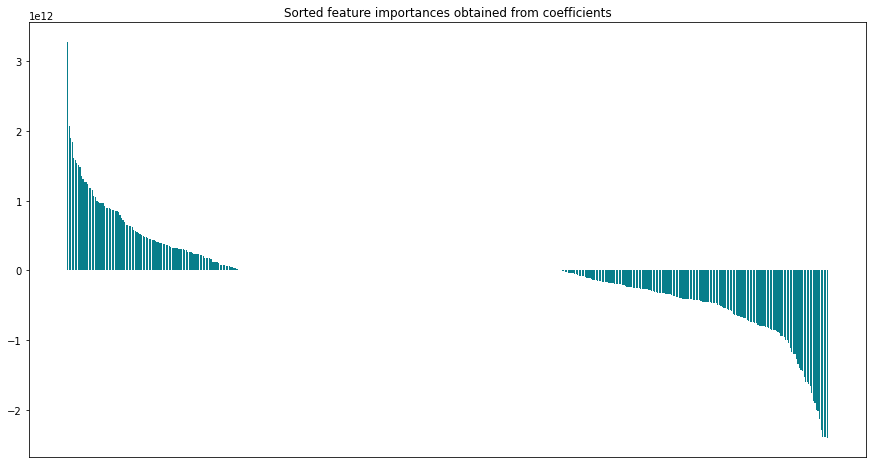

In [158]:
# plot sorted importances to get an idea of the distribution

rcParams['figure.figsize'] = 15, 8
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Sorted feature importances obtained from coefficients')
plt.xticks([])
plt.show()

Based on the graph above, we can see that some of the coefficients on the regression generated using all variables (albeit normalized) are unreasonable large. The table below confirms the same. Including all variables unsurprisingly leads to extreme overfitting, so this is likely also not a great way of determining feature importance. Thus, we will use the manual feature selection obtained from earlier analyses in model construction later.

In [159]:
importances.head()

,Attribute,Importance
85,proj_27,3.275237e+12
47,hold_22,2.068524e+12
122,proj_64,1.897496e+12
170,cont_9p6Q6tTu,1.843488e+12
30,hold_5,1.613631e+12


## 4 Modelling
### 4.1 Model Selection
Select and document any modeling techniques to be used (regression, decision tree, neural network) along with assumptions made (uniform distribution, data type). 
### 4.2 Test Design
Before building the model, generate test design - will you need to split your data (e.g. into training, test, and validation sets), and if so, how? 
### 4.3 Parameter tuning
Next, run the selected modeling tool(s) on your data, list parameters used with justifications, and describe and interpret resulting models. 
### 4.4 Model Evaluation
Generally, you want to run different models with different parameters, then compare the results across the evaluation criteria established in earlier steps. Assess the quality or accuracy of each model, revise and tune iteratively.


## Anomaly Detection

This model can be used to predict clear anomalies in any future data collected. Since we have already manually labeled anomalies in this dataset, we will not be using the anomaly detection algorithm on these data. However, constructing this model should be useful for future data.

### 0. Create hypothesis
Can we assume that our 2 features fit a gaussian distribution? Why or why not? What can we use to determine this (computer science, statistics, domain knowledge)

Our hypothesis is anything with probility density below 1e-05  is abnormal.

### 1. Prepare the data

In [160]:
# make a new dataframe for this test with columns actual_kwh and performance
df_anomaly = df_production[['expected_kwh', 'actual_kwh']]
df_anomaly['performance'] = df_anomaly['actual_kwh']/df_anomaly['expected_kwh']
df_anomaly = df_anomaly[df_anomaly.columns[1:]]

df_anomaly.head()

/Users/katherineli/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,actual_kwh,performance
0,NaN,NaN
1,NaN,NaN
2,0.139945,0.011068
3,23.113000,0.459112
4,NaN,NaN


### 2. Clean the data

In [161]:
df_anomaly.replace([np.inf, -np.inf], np.nan, inplace=True) # remove inf
df_anomaly.dropna(inplace = True) # drop empty values
df_anomaly.head()

,actual_kwh,performance
2,0.139945,0.011068
3,23.113000,0.459112
5,32.874202,0.469362
6,38.108877,0.626208
8,112.495198,0.234449


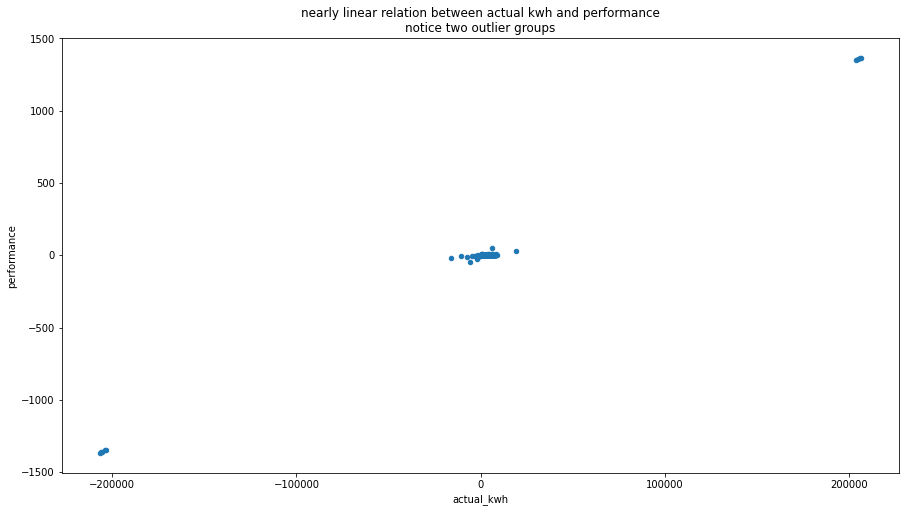

In [162]:
df_anomaly[['actual_kwh','performance']].plot.scatter(x = 'actual_kwh',y = 'performance', \
title = 'nearly linear relation between actual kwh and performance\nnotice two outlier groups')
plt.show()

### 3. Descriptive statistics

In [163]:
df_anomaly.describe()

,actual_kwh,performance
count,79250.000000,79250.000000
mean,279.290636,0.815772
std,2235.428864,14.476634
min,-206639.162217,-1368.683750
25%,65.857084,0.477143
50%,146.628556,0.893310
75%,321.412188,1.176437
max,206151.445053,1365.453334


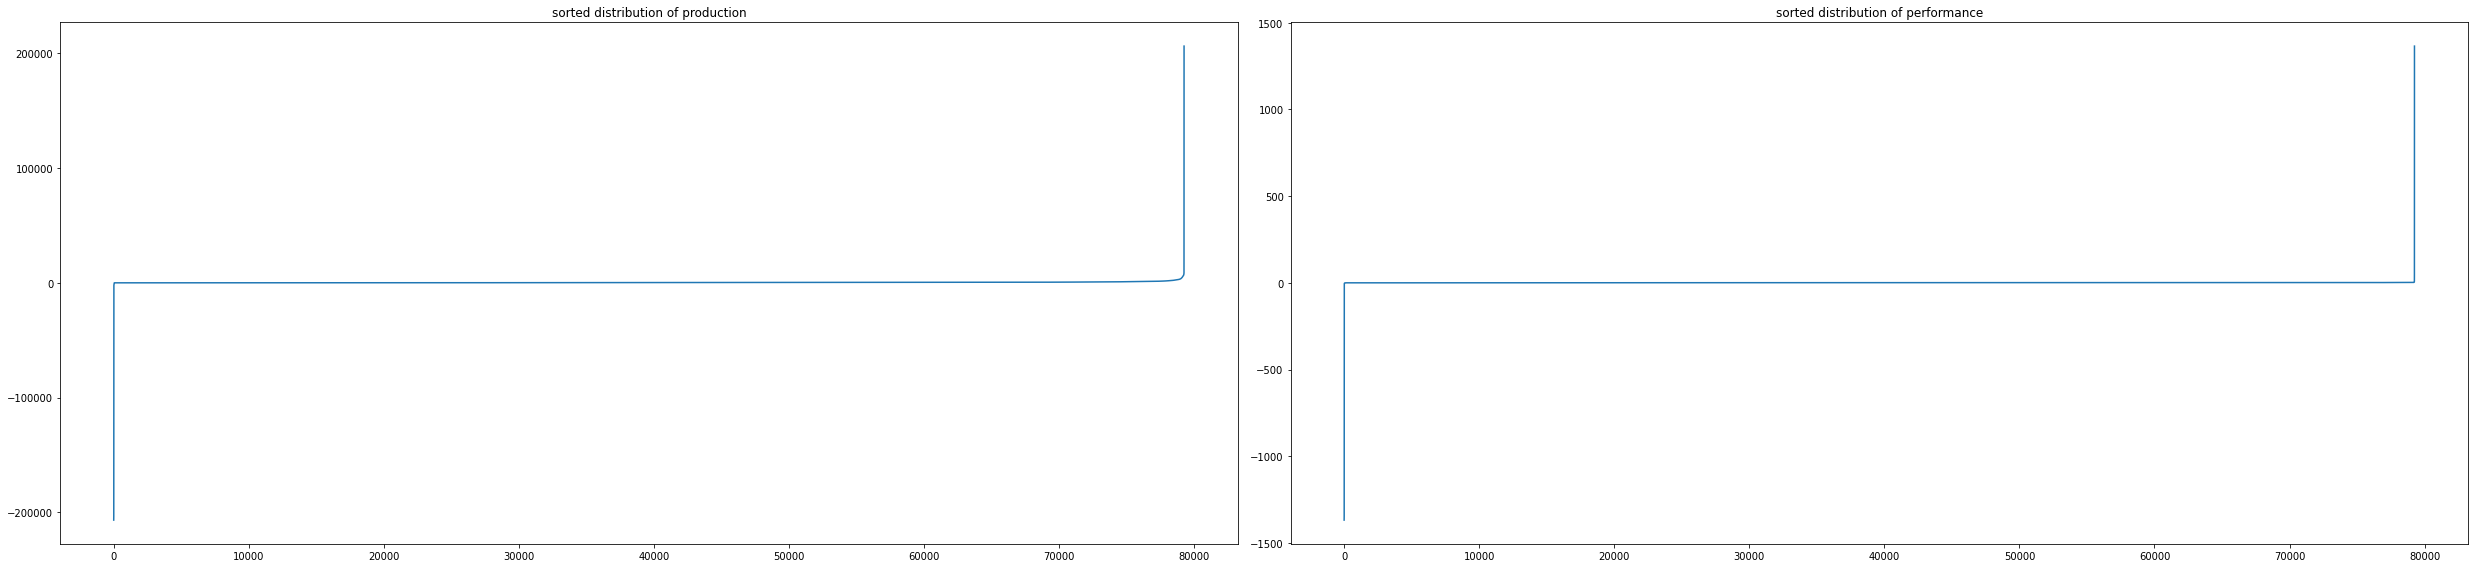

In [164]:
# show what the ordered distribution looks like
fig, axs = plt.subplots(1, 2)
axs[0].plot(df_anomaly['actual_kwh'].sort_values().reset_index().drop(columns='index'))
axs[0].set_title('sorted distribution of production')
axs[1].plot(df_anomaly['performance'].sort_values().reset_index().drop(columns='index'))
axs[1].set_title('sorted distribution of performance')
plt.tight_layout(rect = (0, 0, 2.3, 1))

### 4. Create a normal distribution probability function to check for anomalies

In order to find anomalies, we will need to calculate the p values of each data point in our data set. That is, we want to know how likely it is that this data truly occured, given a random sample of data with the given mean and standard deviation. In order to find these p values, we will need to first fit the data to an appropriate normal distribution function based on mean and standard deviation.

In [165]:
# https://en.wikipedia.org/wiki/Normal_distribution
def normal_dist(x , mean , sd):
    prob_density = ((np.pi*sd)**-.5) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

In [166]:
# test single value for normal distribution probability density
x = df_anomaly['actual_kwh'].to_numpy()
print('kwh actual mean: ', x.mean(), '\nkwh actual std: ', x.std())
print('kwh actual value: ', x[10], '\np-value is :', normal_dist(x[10], x.mean(), x.std()))

kwh actual mean:  279.29063600718985 
kwh actual std:  2235.414760050485
kwh actual value:  62.20324861111112 
p-value is : 0.011876763636585817


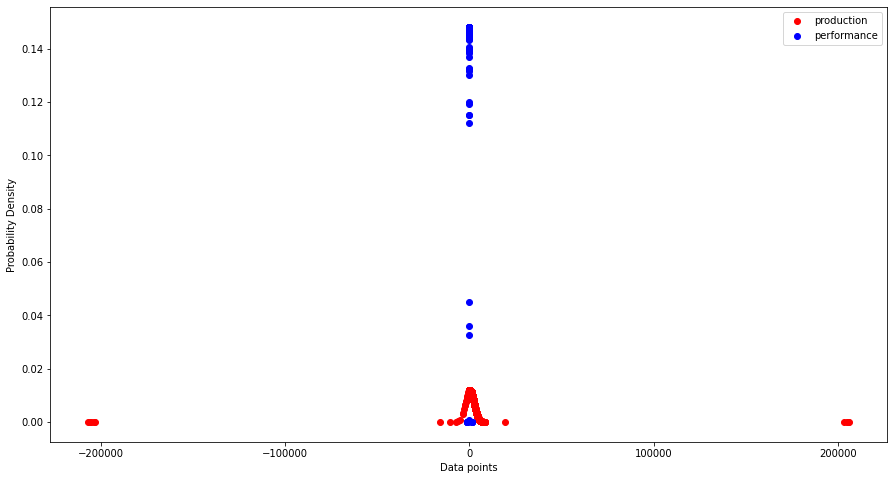

In [167]:
# show both probability functions
pdf1 = normal_dist(df_anomaly['actual_kwh'], df_anomaly['actual_kwh'].mean(), df_anomaly['actual_kwh'].std())
pdf2 = normal_dist(df_anomaly['performance'], df_anomaly['performance'].mean(), df_anomaly['performance'].std())
plt.scatter(df_anomaly['actual_kwh'], pdf1, color='red')
plt.scatter(df_anomaly['performance'], pdf2, color='blue')
plt.legend(['production','performance'])
plt.xlabel('Data points')
plt.ylabel('Probability Density')
plt.show()

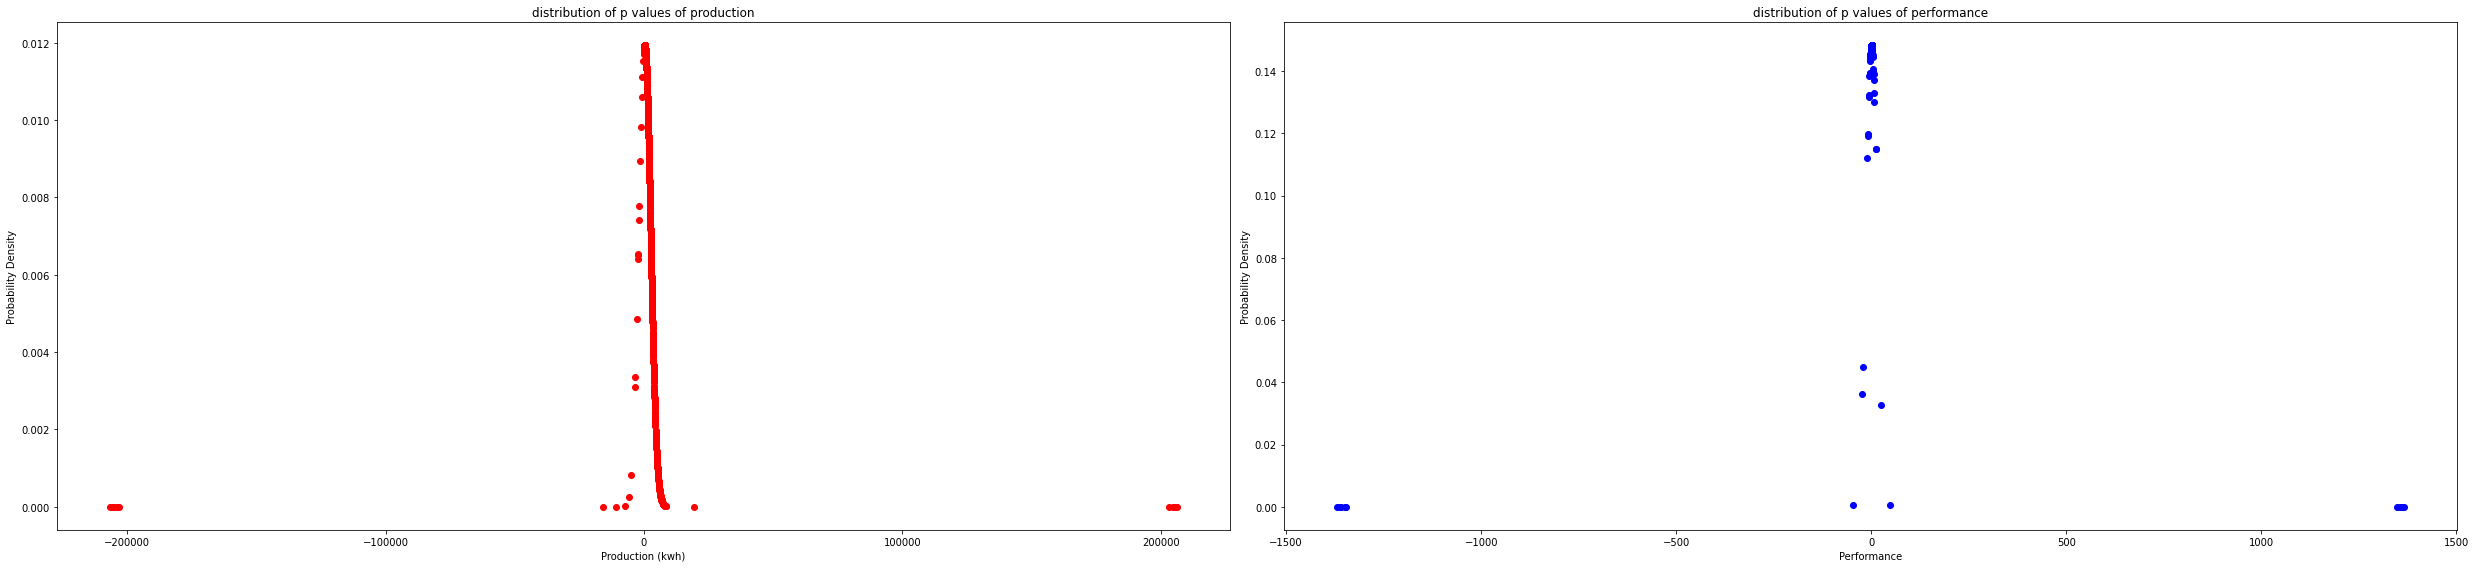

In [168]:
# plot all probability densities vs actual_kwh  
fig, axs = plt.subplots(1, 2)
axs[0].scatter(df_anomaly['actual_kwh'], pdf1, color='red')
axs[0].set_title('distribution of p values of production')
axs[1].scatter(df_anomaly['performance'], pdf2, color='blue')
axs[1].set_title('distribution of p values of performance')
axs[0].set(xlabel = 'Production (kwh)', ylabel = 'Probability Density')
axs[1].set(xlabel = 'Performance', ylabel = 'Probability Density')
plt.tight_layout(rect = (0, 0, 2.3, 1))

In [169]:
# combine both distributions
df_p = normal_dist(df_anomaly, df_anomaly.mean(), df_anomaly.std())
df_p['p'] = df_p.prod(axis = 1)
df_p.describe()

,actual_kwh,performance,p
count,79250.000000,79250.000000,79250.000000
mean,0.011755,0.148181,0.001742
std,0.000801,0.001897,0.000119
min,0.000000,0.000000,0.000000
25%,0.011855,0.148176,0.001757
50%,0.011892,0.148239,0.001763
75%,0.011918,0.148272,0.001767
max,0.011933,0.148283,0.001769


In order to determine whether a data point is anomalous, we can use 2 methods. 

First, we can use standard deviations, or z-scores: for example, if a data point is 3 standard deviations from the mean, we might consider it anomalous as it is pretty unlikely to occur in nature. 

Otherwise, we can also set a threshold value epsilon below which any p values will be considered anomalous. Epsilon can be set using domain knowledge or, below, we can train a model to find the optimal epsilon (by comparing model accuracy or f1 score against labeled anomalies).

In [170]:
def get_anomalies(method = 2, num_stds = 2, epsilon = 1e-5):
    # choose one of many ways to identify outliers
    if method == 1:
        # z-score method
        # create the anomaly column. true if the value is +/- num_stds of stds away from the mean
        df_p['anom'] = (df_p.p  < df_p.p.mean() - num_stds * df_p['p'].std()) | (df_p.p  > df_p.p.mean() + num_stds * df_p['p'].std())
        print('using z-scores. number of standard deviations away from mean to id outliers is', num_stds)
        print(df_p['anom'].value_counts())
    if method == 2:
        # epsilon method
        df_p['anom'] = df_p.p < epsilon # create anomaly column. true if the value is less than epsilon
        print('using epsilon to find outliers with a value of ',epsilon)
        print(df_p['anom'].value_counts())

In [171]:
# using z-scores w/ 3 stds away from the mean

get_anomalies(1, 3)

using z-scores. number of standard deviations away from mean to id outliers is 3
False    78107
True      1143
Name: anom, dtype: int64


In [172]:
# find the cutoff below which data are considered outliers

df_p[df_p.anom==True]['p'].max()

0.0013841201088895657

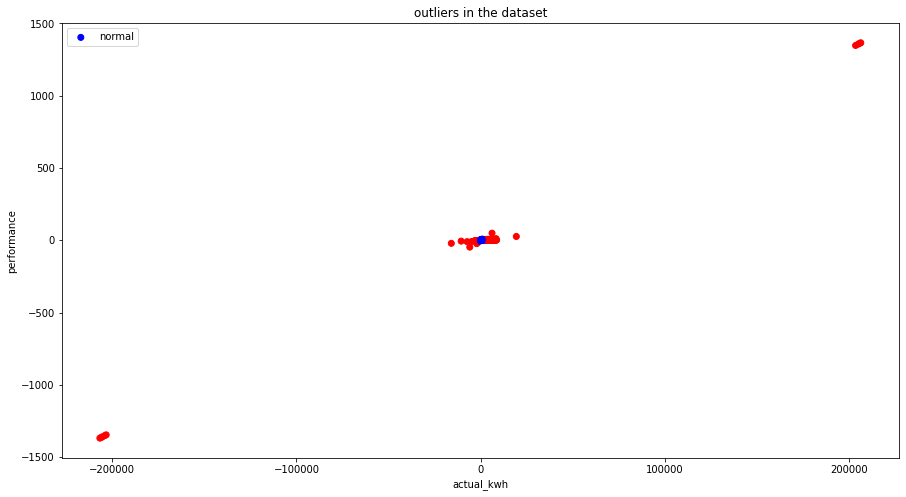

In [173]:
# plot outliers

df_outliers = df_anomaly.merge(df_p, left_index=True, right_index=True, suffixes=['_raw','_p']) 
plt.scatter(df_outliers['actual_kwh_raw'], df_outliers['performance_raw'], color = np.where(df_outliers['anom'],'r','b'))
plt.title('outliers in the dataset')
plt.legend(['normal','outlier'])
plt.xlabel('actual_kwh')
plt.ylabel('performance')
plt.show()

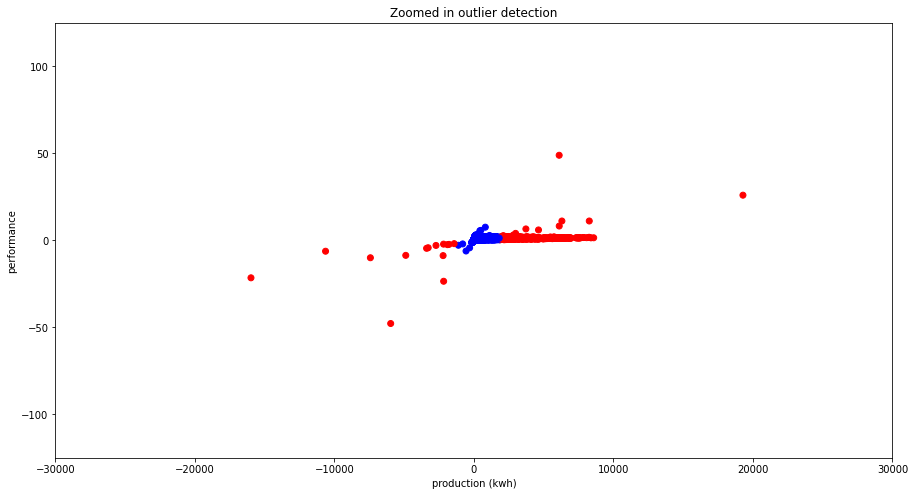

In [174]:
plt.scatter(df_outliers['actual_kwh_raw'], df_outliers['performance_raw'], color = np.where(df_outliers['anom'],'r','b'))
plt.ylim(bottom=-125, top=125)
plt.xlim(left=-30000,right=30000)
plt.xlabel('production (kwh)')
plt.ylabel('performance')
plt.title('Zoomed in outlier detection')
plt.show()

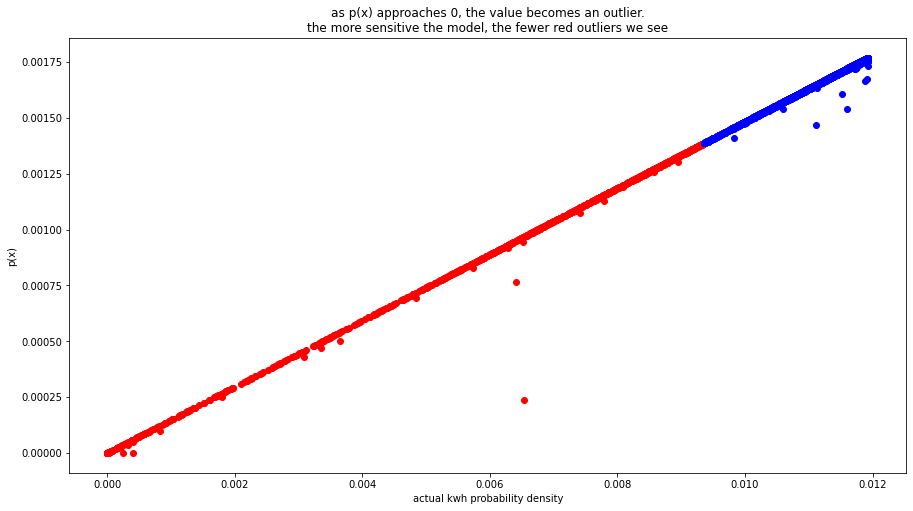

In [175]:
fig, ax = plt.subplots()
color = ['r' for x in df_p['anom'] if True]
ax.scatter(df_p[df_p['anom'] == True]['actual_kwh'], df_p[df_p['anom'] == True]['p'], c='red')
ax.scatter(df_p[df_p['anom'] == False]['actual_kwh'], df_p[df_p['anom'] == False]['p'], c='blue')
plt.xlabel('actual kwh probability density')
plt.ylabel('p(x)')
plt.title('as p(x) approaches 0, the value becomes an outlier.\nthe more sensitive the model, \
the fewer red outliers we see')
plt.show()

First, let's try plotting some outliers using the z-score methods and compare how many outliers we get using a different number of z-scores as the cutoff.

using z-scores. number of standard deviations away from mean to id outliers is 3
False    78107
True      1143
Name: anom, dtype: int64
using z-scores. number of standard deviations away from mean to id outliers is 6
False    78678
True       572
Name: anom, dtype: int64
using z-scores. number of standard deviations away from mean to id outliers is 14
False    79162
True        88
Name: anom, dtype: int64


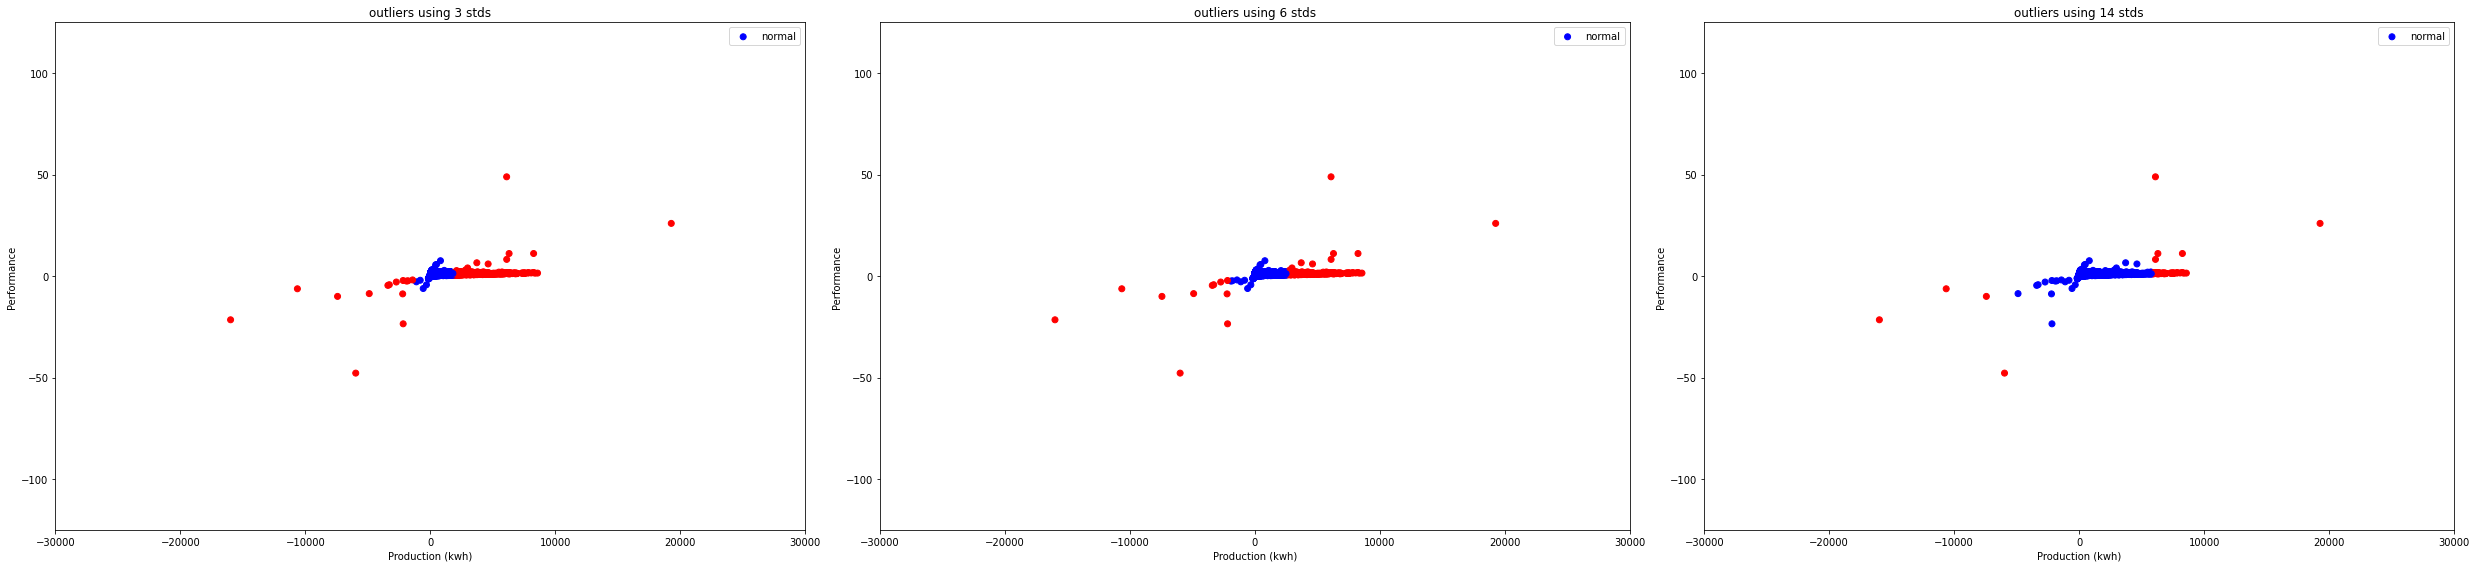

In [176]:
# 3 graphs with 3 different values of num_std [3,6,14]

fig, axs = plt.subplots(1, 3)
stds = [3, 6, 14]
get_anomalies(method = 1, num_stds = stds[0])
temp = df_anomaly.merge(df_p, left_index=True, right_index=True, suffixes=['_raw','_p']) 
axs[0].scatter(temp['actual_kwh_raw'], temp['performance_raw'], color = np.where(temp['anom'],'r','b'))
axs[0].set_title(f'outliers using {stds[0]} stds')
axs[0].legend(['normal','outlier'])
axs[0].set_xlim([-30000, 30000])
axs[0].set_ylim([-125, 125])
get_anomalies(method = 1, num_stds = stds[1])
temp = df_anomaly.merge(df_p, left_index=True, right_index=True, suffixes=['_raw','_p']) 
axs[1].scatter(temp['actual_kwh_raw'], temp['performance_raw'], color = np.where(temp['anom'],'r','b'))
axs[1].set_title(f'outliers using {stds[1]} stds')
axs[1].legend(['normal','outlier'])
axs[1].set_xlim([-30000, 30000])
axs[1].set_ylim([-125, 125])
get_anomalies(method = 1, num_stds = stds[2])
temp = df_anomaly.merge(df_p, left_index=True, right_index=True, suffixes=['_raw','_p']) 
axs[2].scatter(temp['actual_kwh_raw'], temp['performance_raw'], color = np.where(temp['anom'],'r','b'))
axs[2].set_title(f'outliers using {stds[2]} stds')
axs[2].legend(['normal','outlier'])
axs[2].set_xlim([-30000, 30000])
axs[2].set_ylim([-125, 125])
axs[0].set(xlabel = 'Production (kwh)', ylabel = 'Performance')
axs[1].set(xlabel = 'Production (kwh)', ylabel = 'Performance')
axs[2].set(xlabel = 'Production (kwh)', ylabel = 'Performance')
plt.tight_layout(rect = (0, 0, 2.3, 1))

Next, we can do the same comparison plots with different values of epsilon.

In [177]:
# 3 graphs with 3 different values of epsilon [0.0001, 0.00003, 0.00001]

eps = [0.0001, 0.00003, 0.00001]
get_anomalies(epsilon = eps[0])
temp = df_anomaly.merge(df_p, left_index=True, right_index=True, suffixes=['_raw','_p']) 
axs[0].scatter(temp['actual_kwh_raw'], temp['performance_raw'], color = np.where(temp['anom'],'r','b'))
axs[0].set_title(f'outliers w/ \u03B5 = {eps[0]}')
axs[0].legend(['normal','outlier'])
axs[0].set_xlim([-30000, 30000])
axs[0].set_ylim([-125, 125])
get_anomalies(epsilon = eps[1])
temp = df_anomaly.merge(df_p, left_index=True, right_index=True, suffixes=['_raw','_p']) 
axs[1].scatter(temp['actual_kwh_raw'], temp['performance_raw'], color = np.where(temp['anom'],'r','b'))
axs[1].set_title(f'outliers w/ \u03B5 = {eps[1]}')
axs[1].legend(['normal','outlier'])
axs[1].set_xlim([-30000, 30000])
axs[1].set_ylim([-125, 125])
get_anomalies(epsilon = eps[2])
temp = df_anomaly.merge(df_p, left_index=True, right_index=True, suffixes=['_raw','_p']) 
axs[2].scatter(temp['actual_kwh_raw'], temp['performance_raw'], color = np.where(temp['anom'],'r','b'))
axs[2].set_title(f'outliers w/ \u03B5 = {eps[2]}')
axs[2].legend(['normal','outlier'])
axs[2].set_xlim([-30000, 30000])
axs[2].set_ylim([-125, 125])
axs[0].set(xlabel = 'Production (kwh)', ylabel = 'Performance')
axs[1].set(xlabel = 'Production (kwh)', ylabel = 'Performance')
axs[2].set(xlabel = 'Production (kwh)', ylabel = 'Performance')
plt.tight_layout(rect = (0, 0, 2.3, 1))

using epsilon to find outliers with a value of  0.0001
False    79144
True       106
Name: anom, dtype: int64
using epsilon to find outliers with a value of  3e-05
False    79204
True        46
Name: anom, dtype: int64
using epsilon to find outliers with a value of  1e-05
False    79221
True        29
Name: anom, dtype: int64


<Figure size 1080x576 with 0 Axes>

### 5. Build a labeled dataset for supervised learning

In [178]:
# values less than -10 are anomalies
df_outliers['anom_label'] = df_outliers['actual_kwh_raw'] < -10
# values greater than 10000 are probably anomalies
df_outliers.loc[df_outliers['actual_kwh_raw'] > 10000, 'anom_label'] = True
# values greater than 200% performance are anomalies
df_outliers.loc[df_outliers['performance_raw'] > 2, 'anom_label'] = True
df_outliers[df_outliers['anom_label'] == True]

,actual_kwh_raw,performance_raw,actual_kwh_p,performance_p,p,anom,anom_label
207,-41.992394,-0.742649,1.181025e-02,0.147426,1.741141e-03,False,True
285,-17.999271,-0.318323,1.182780e-02,0.147829,1.748488e-03,False,True
363,-48.036116,-0.849534,1.180562e-02,0.147305,1.739028e-03,False,True
402,-47.594317,-0.841721,1.180596e-02,0.147314,1.739186e-03,False,True
597,-16.598121,-0.293543,1.182879e-02,0.147848,1.748866e-03,False,True
...,...,...,...,...,...,...,...
75383,3778.822418,2.109002,3.504064e-03,0.147692,5.175239e-04,True,True
76318,2813.558359,3.019073,6.275653e-03,0.146575,9.198568e-04,True,True
77362,-2721.440107,-2.920226,4.846916e-03,0.143426,6.951758e-04,True,True
78058,2182.493146,2.341912,8.305110e-03,0.147461,1.224682e-03,True,True


### 6. Use supervised learning to find the optimal epsilon to find outliers

In [179]:
# predict which data points are anomalous (using epsilon method)

def anomaly_detection(X, y, epsilon):
    p_vals = normal_dist(X, np.mean(X), np.std(X)) # generate the probability density of each record
    p_vals = np.prod(p_vals, axis=1) # multiply the probability densities of all features together to get the total probability 
    detection = p_vals < epsilon
    return detection

In [180]:
# generate precision, recall, accuracy, and f1 score based on predicted vs labeled anomalies

def score_model(y, pred, epsilon):
    c_mat = confusion_matrix(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    print(epsilon)
    print(c_mat)
    print(f'precision: {prec}\nrecall   : {rec}\naccuracy: {acc}\nf1 score : {f1}')
    return prec, rec, acc, f1

In [181]:
# find epsilon to optimize score (default f1)

def approximate_epsilon(lr, e, X = df_anomaly, y = df_outliers['anom_label'], by = 3):
    epsilon = e
    prediction = anomaly_detection(X, y, epsilon)
    score = score_model(y, prediction, epsilon)[3]
    left = epsilon - lr
    left_prediction = anomaly_detection(X, y, left)
    left_score = score_model(y, left_prediction, left)[3]
    right = epsilon + lr
    right_prediction = anomaly_detection(X, y, right)
    right_score = score_model(y, right_prediction, right)[3]
    if left_score > score:
        while left_score > score:
            epsilon = left
            prediction = left_prediction
            score = left_score
            left = epsilon - lr
            left_prediction = anomaly_detection(X, y, left)
            left_score = score_model(y, left_prediction, left)[3]
    elif right_score > score:
        while right_score > score:
            epsilon = right
            prediction = right_prediction
            score = right_score
            right = epsilon + lr
            right_prediction = anomaly_detection(X, y, right)
            right_score = score_model(y, right_prediction, right)[3]
    return epsilon, score

Now that we've defined some functions to help approximate epsilon, we can test out some values and find the optimal epsilon that yields the maximal f1 score for anomaly detection.

In [182]:
learning_rate = 1e-6
starting_epsilon = 1e-5

approximate_epsilon(learning_rate, starting_epsilon)

1e-05
[[79030    13]
 [  191    16]]
precision: 0.5517241379310345
recall   : 0.07729468599033816
accuracy: 0.9974258675078864
f1 score : 0.13559322033898305
9e-06
[[79033    10]
 [  191    16]]
precision: 0.6153846153846154
recall   : 0.07729468599033816
accuracy: 0.9974637223974764
f1 score : 0.13733905579399142
1.1000000000000001e-05
[[79027    16]
 [  191    16]]
precision: 0.5
recall   : 0.07729468599033816
accuracy: 0.9973880126182966
f1 score : 0.13389121338912133
8e-06
[[79035     8]
 [  191    16]]
precision: 0.6666666666666666
recall   : 0.07729468599033816
accuracy: 0.9974889589905362
f1 score : 0.1385281385281385
7e-06
[[79035     8]
 [  191    16]]
precision: 0.6666666666666666
recall   : 0.07729468599033816
accuracy: 0.9974889589905362
f1 score : 0.1385281385281385


(8e-06, 0.1385281385281385)

In [183]:
learning_rate = 1e-6
starting_epsilon = 1e-6

approximate_epsilon(learning_rate, starting_epsilon)

1e-06
[[79043     0]
 [  193    14]]
precision: 1.0
recall   : 0.06763285024154589
accuracy: 0.9975646687697161
f1 score : 0.12669683257918551
0.0
[[79043     0]
 [  207     0]]
precision: 0.0
recall   : 0.0
accuracy: 0.9973880126182966
f1 score : 0.0
2e-06
[[79042     1]
 [  193    14]]
precision: 0.9333333333333333
recall   : 0.06763285024154589
accuracy: 0.9975520504731861
f1 score : 0.12612612612612611


/Users/katherineli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/katherineli/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(1e-06, 0.12669683257918551)

In [184]:
learning_rate = 1e-6
starting_epsilon = 5e-6

approximate_epsilon(learning_rate, starting_epsilon)

5e-06
[[79038     5]
 [  191    16]]
precision: 0.7619047619047619
recall   : 0.07729468599033816
accuracy: 0.9975268138801262
f1 score : 0.14035087719298245
4.000000000000001e-06
[[79039     4]
 [  191    16]]
precision: 0.8
recall   : 0.07729468599033816
accuracy: 0.9975394321766562
f1 score : 0.1409691629955947
6e-06
[[79035     8]
 [  191    16]]
precision: 0.6666666666666666
recall   : 0.07729468599033816
accuracy: 0.9974889589905362
f1 score : 0.1385281385281385
3.000000000000001e-06
[[79040     3]
 [  192    15]]
precision: 0.8333333333333334
recall   : 0.07246376811594203
accuracy: 0.9975394321766562
f1 score : 0.13333333333333333


(4.000000000000001e-06, 0.1409691629955947)

In [185]:
learning_rate = 5e-7
starting_epsilon = 4e-6

approximate_epsilon(learning_rate, starting_epsilon)

4e-06
[[79039     4]
 [  191    16]]
precision: 0.8
recall   : 0.07729468599033816
accuracy: 0.9975394321766562
f1 score : 0.1409691629955947
3.5e-06
[[79039     4]
 [  192    15]]
precision: 0.7894736842105263
recall   : 0.07246376811594203
accuracy: 0.9975268138801262
f1 score : 0.13274336283185842
4.5e-06
[[79038     5]
 [  191    16]]
precision: 0.7619047619047619
recall   : 0.07729468599033816
accuracy: 0.9975268138801262
f1 score : 0.14035087719298245


(4e-06, 0.1409691629955947)

Doing some test runs, it seems like the optimal epsilon is around 4e-6. We can confirm by graphing scores by epsilon below.

In [186]:
def get_threshold_scores(X, y, scorers=(accuracy_score, precision_score, recall_score, f1_score),
                         min_thr=0, max_thr=1e-5, step=5e-7):
    """
    Iterates through all possible thresholds and returns their respective accuracies within the model
    :return:  tuple of (thresholds, scores)
    """
    thresholds = np.arange(min_thr, max_thr + step, step)
    scores = []

    for scorer in scorers:
        scorer_scores = []
        for threshold in thresholds:
            y_pred = anomaly_detection(X, y, threshold)
            scorer_scores.append(scorer(y, y_pred))
        scores.append(scorer_scores)
    return thresholds, np.array(scores)


def plot_thresholds(pred, y, scorers=(accuracy_score, precision_score, recall_score, f1_score), **kwargs):
    thresholds, scores = get_threshold_scores(pred, y, scorers=scorers, **kwargs)
    for i in range(len(scorers)):
        plt.plot(thresholds, scores[i], label=scorers[i].__name__)

    plt.xticks(thresholds)
    plt.yticks(np.linspace(scores.min(), scores.max(), 11))
    plt.grid()

    plt.legend()

    plt.xlabel('Epsilon')
    plt.ylabel('Score')

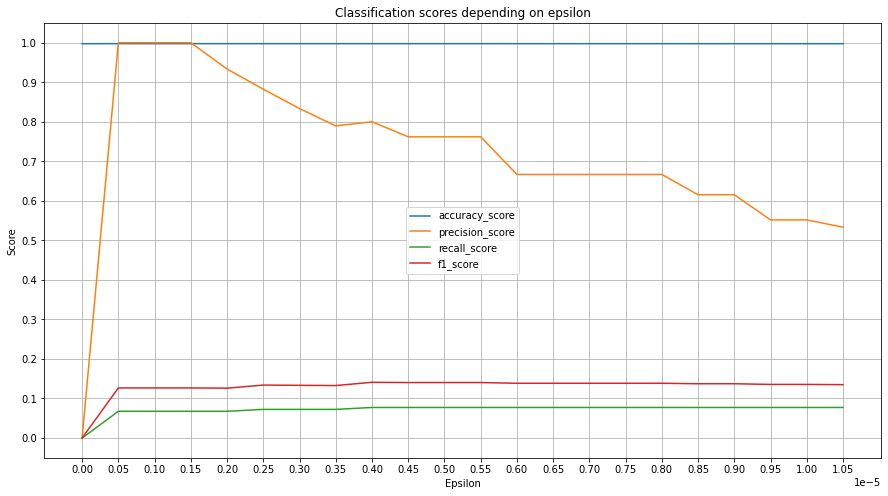

In [187]:
X = df_anomaly
y = df_outliers['anom_label']
plot_thresholds(X, y)
plt.title('Classification scores depending on epsilon')
plt.show()

Again, an epsilon of 4e-6 appears to be a reasonable estimate for maximizing f1 score. It is the maximum over the range from 0 to 1e-5, and other scores also appear reasonable at that threshold. Below, we will proceed with anomaly detection using epsilon = 4e-6.

In [188]:
get_anomalies(method = 2, epsilon = 4e-6)

using epsilon to find outliers with a value of  4e-06
False    79230
True        20
Name: anom, dtype: int64


As we can see, the algorithm only detects 20 anomalies using the optimal threshold epsilon! However, there must be many more anomalies in our data set. In fact, there are 10 times as many labelled anomalies. Still, we don't want epsilon to be too large and capture non-anomalous data. For now, we prefer to just catch the obvious anomalies. We can also change epsilon as needed if we plan to manually check categorized anomalies (in which case we may want epsilon to cast a larger net and potentially be wrong). We can later change the f1 score to be biased towards precision or recall as we desire.

In [189]:
sum(df_p['anom']), sum(df_outliers['anom_label'])

(20, 207)

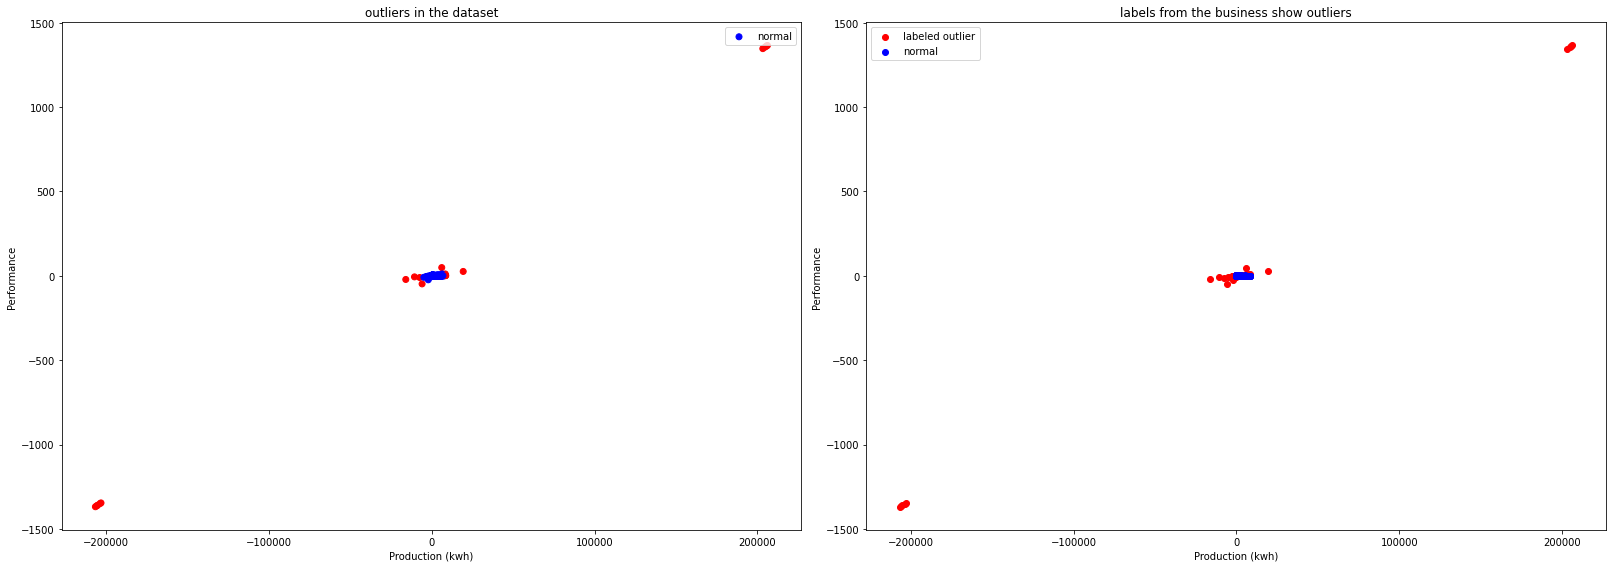

In [190]:
# plot detected vs labeled outliers

fig, axs = plt.subplots(1, 2)

df_detected = df_anomaly.merge(df_p, left_index=True, right_index=True, suffixes=['_raw','_p']) 
axs[0].scatter(df_detected['actual_kwh_raw'], df_detected['performance_raw'], color = np.where(df_detected['anom'],'r','b'))
axs[0].set_title('outliers in the dataset')
axs[0].set(xlabel = 'Production (kwh)', ylabel = 'Performance')
axs[0].legend(['normal','outlier'])

axs[1].scatter(df_outliers[df_outliers['anom_label'] == True]['actual_kwh_raw'], \
df_outliers[df_outliers['anom_label'] == True]['performance_raw'], c='red')
axs[1].scatter(df_outliers[df_outliers['anom_label'] == False]['actual_kwh_raw'], \
df_outliers[df_outliers['anom_label'] == False]['performance_raw'], c='blue')
axs[1].set_title('labels from the business show outliers')
axs[1].set(xlabel = 'Production (kwh)', ylabel = 'Performance')
axs[1].legend(['labeled outlier','normal'])

plt.tight_layout(rect = (0, 0, 1.5, 1))

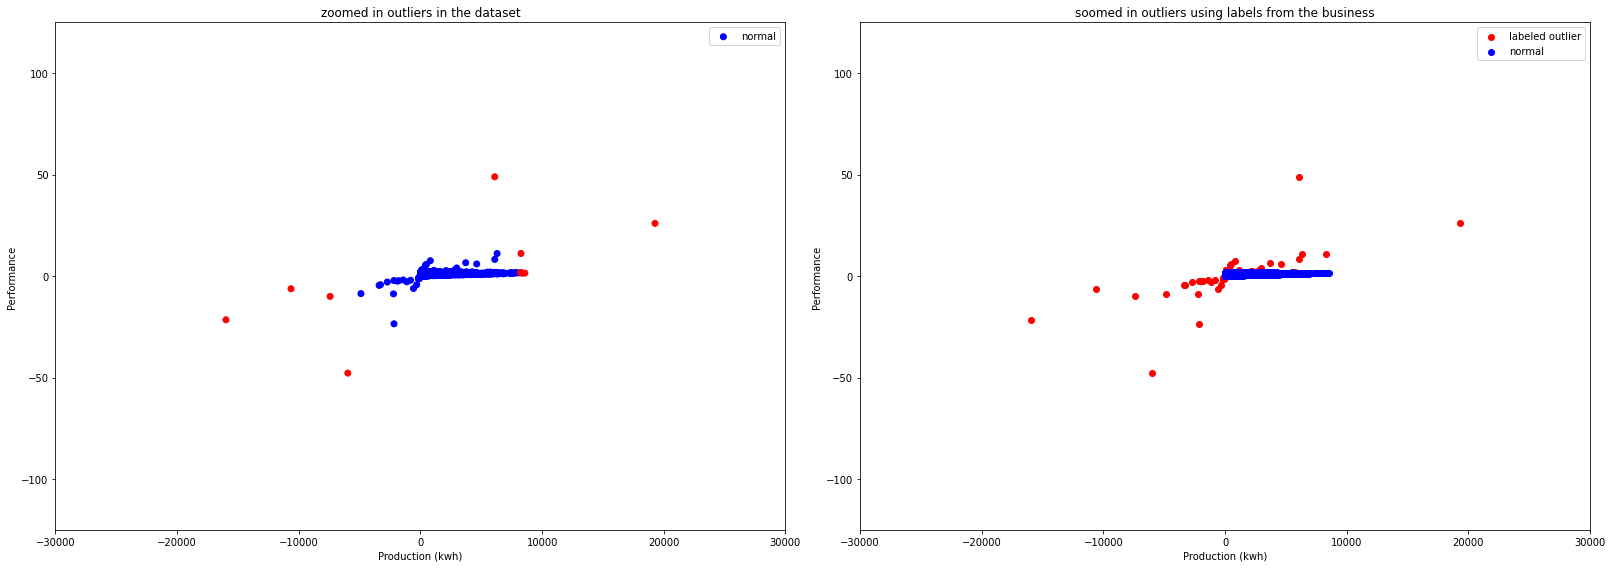

In [191]:
# plot detected vs labeled outliers (zoomed in)

fig, axs = plt.subplots(1, 2)

df_detected = df_anomaly.merge(df_p, left_index=True, right_index=True, suffixes=['_raw','_p']) 
axs[0].scatter(df_detected['actual_kwh_raw'], df_detected['performance_raw'], color = np.where(df_detected['anom'],'r','b'))
axs[0].set_title('zoomed in outliers in the dataset')
axs[0].set(xlabel = 'Production (kwh)', ylabel = 'Performance')
axs[0].legend(['normal','outlier'])
axs[0].set_xlim([-30000, 30000])
axs[0].set_ylim([-125, 125])

axs[1].scatter(df_outliers[df_outliers['anom_label'] == True]['actual_kwh_raw'], \
df_outliers[df_outliers['anom_label'] == True]['performance_raw'], c='red')
axs[1].scatter(df_outliers[df_outliers['anom_label'] == False]['actual_kwh_raw'], \
df_outliers[df_outliers['anom_label'] == False]['performance_raw'], c='blue')
axs[1].set_title('soomed in outliers using labels from the business')
axs[1].set(xlabel = 'Production (kwh)', ylabel = 'Performance')
axs[1].legend(['labeled outlier','normal'])
axs[1].set_xlim([-30000, 30000])
axs[1].set_ylim([-125, 125])

plt.tight_layout(rect = (0, 0, 1.5, 1))

### 7. Use an isolation forest to find anomalies

We can also use an isolation forest to find anomalies, where we conduct a more automated anomaly detection.

/Users/katherineli/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/katherineli/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/katherineli/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


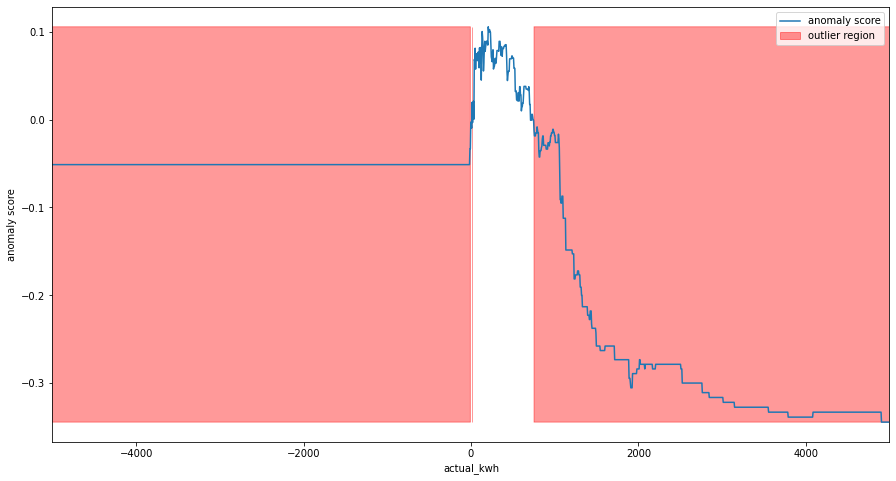

In [192]:
# One dimensional Isolation forest
# https://dzone.com/articles/spotting-outliers-with-isolation-forest-using-skle
# returns the anomaly score of each sample usint the isolation forest algorithm.
# Convert data to numpy arrays and resize to columnar format
# train the model with n_estimators which counts are 

X = df_anomaly['actual_kwh'].to_numpy()
clf = IsolationForest(n_estimators=10, warm_start=True)
clf.fit(X.reshape(-1,1))
xx = np.linspace(np.min(X),np.max(X),len(X)).reshape(-1,1)
anomaly_score = clf.decision_function(xx)
outlier = clf.predict(xx)

plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('actual_kwh')
plt.xlim([-5000, 5000])
plt.show()

In [193]:
# Isolation forest
# Multivariate model to find outliers in a 2-D array (actual_kwh, performance)

X = df_anomaly[['actual_kwh','performance']].to_numpy()
clf = IsolationForest(n_estimators=10, warm_start=True)
clf.fit(X)
# X
xx = np.linspace((np.min(X[:,0]),np.min(X[:,1])),(np.max(X[:,0]),np.max(X[:,1])),len(X))
anomaly_score = clf.decision_function(xx)
outlier = clf.predict(X)

/Users/katherineli/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/katherineli/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/katherineli/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


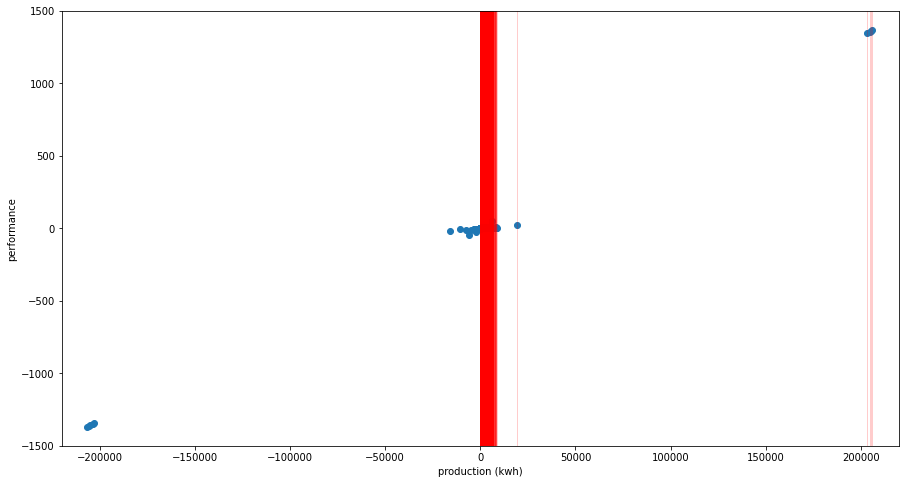

In [194]:
plt.scatter(X[:,0],X[:,1])
plt.fill_between(X[:,0], np.min(X[:,0]),np.max(X[:,0]),
                 where=outlier==-1,color ='r', alpha=.2, label='outlier region')
plt.xlim(left=-220000, right=220000)
plt.ylim(top=1500,bottom=-1500)
plt.xlabel('production (kwh)')
plt.ylabel('performance')
plt.show()

In [195]:
sum(outlier == -1), outlier

(7861, array([-1,  1,  1, ...,  1,  1,  1]))

As we can see here, the isolation forest algorithm is detecting way too many outliers - 7893, more than 30 times as many as the labeled dataset contains. Thus, this is likely not the best method for detecting outliers. It cute off far too many reasonably production values in the plots below.

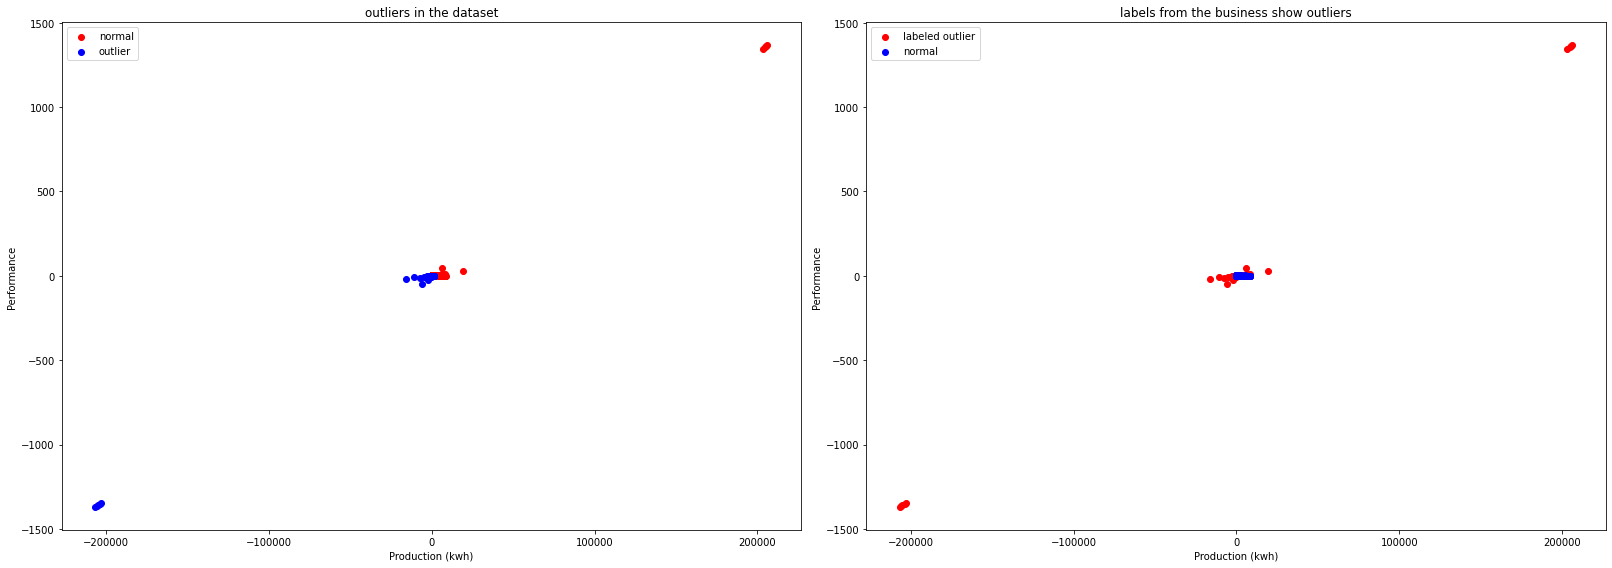

In [196]:
# plot detected vs labeled outliers

fig, axs = plt.subplots(1, 2)

axs[0].scatter(X[outlier==-1][:,0],X[outlier==-1][:,1],c='red')
axs[0].scatter(X[outlier!=-1][:,0],X[outlier!=-1][:,1],c='blue')
axs[0].set_title('outliers in the dataset')
axs[0].set(xlabel = 'Production (kwh)', ylabel = 'Performance')
axs[0].legend(['normal','outlier'])

axs[1].scatter(df_outliers[df_outliers['anom_label'] == True]['actual_kwh_raw'], \
df_outliers[df_outliers['anom_label'] == True]['performance_raw'], c='red')
axs[1].scatter(df_outliers[df_outliers['anom_label'] == False]['actual_kwh_raw'], \
df_outliers[df_outliers['anom_label'] == False]['performance_raw'], c='blue')
axs[1].set_title('labels from the business show outliers')
axs[1].set(xlabel = 'Production (kwh)', ylabel = 'Performance')
axs[1].legend(['labeled outlier','normal'])

plt.tight_layout(rect = (0, 0, 1.5, 1))

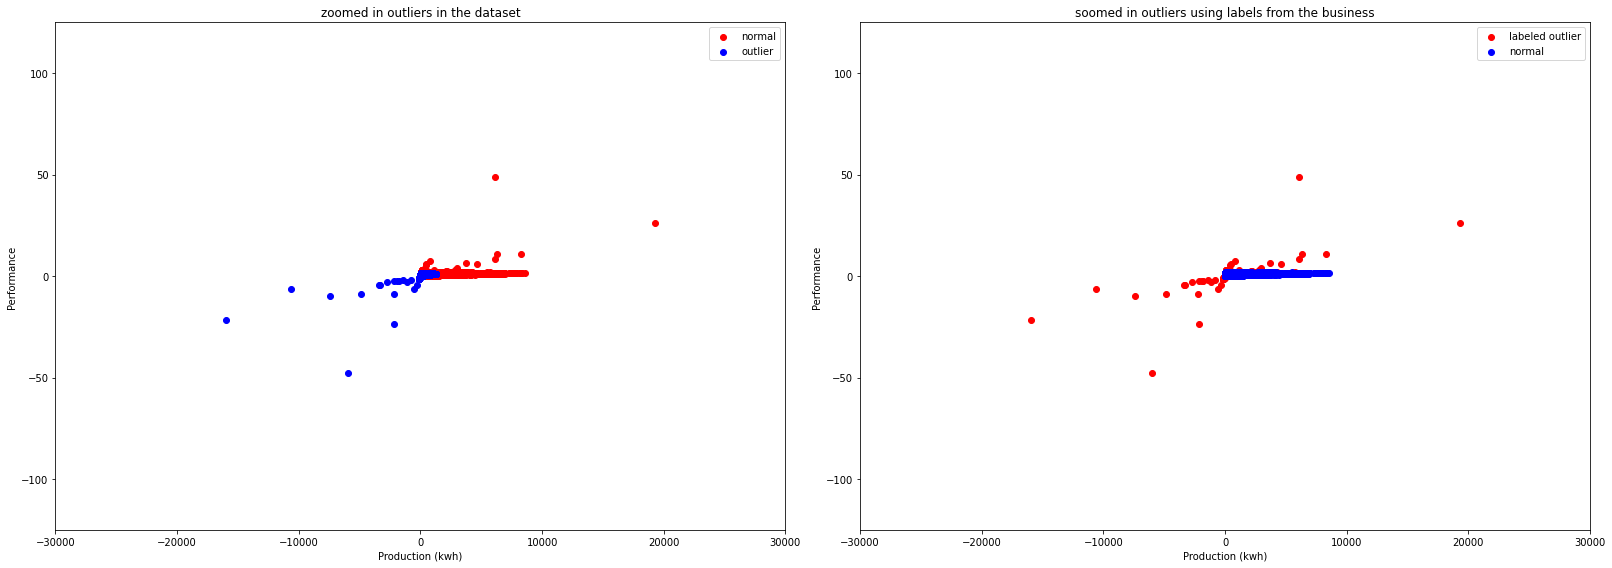

In [197]:
# plot detected vs labeled outliers (zoomed in)

fig, axs = plt.subplots(1, 2)

axs[0].scatter(X[outlier==-1][:,0],X[outlier==-1][:,1],c='red')
axs[0].scatter(X[outlier!=-1][:,0],X[outlier!=-1][:,1],c='blue')
axs[0].set_title('zoomed in outliers in the dataset')
axs[0].set(xlabel = 'Production (kwh)', ylabel = 'Performance')
axs[0].legend(['normal','outlier'])
axs[0].set_xlim([-30000, 30000])
axs[0].set_ylim([-125, 125])

axs[1].scatter(df_outliers[df_outliers['anom_label'] == True]['actual_kwh_raw'], \
df_outliers[df_outliers['anom_label'] == True]['performance_raw'], c='red')
axs[1].scatter(df_outliers[df_outliers['anom_label'] == False]['actual_kwh_raw'], \
df_outliers[df_outliers['anom_label'] == False]['performance_raw'], c='blue')
axs[1].set_title('soomed in outliers using labels from the business')
axs[1].set(xlabel = 'Production (kwh)', ylabel = 'Performance')
axs[1].legend(['labeled outlier','normal'])
axs[1].set_xlim([-30000, 30000])
axs[1].set_ylim([-125, 125])

plt.tight_layout(rect = (0, 0, 1.5, 1))

## Predicting Performance

Beyond anomaly detection, we also generally want to be able to predict system performance. To this end, we can use the analyses above to inform variable selection and create a set of predictors to feed into a regression model. We will include both the predictors we deemed statistically AND practically significant earlier and the new variables we created marking non-comms, low production, and loss due to weather.

In [198]:
df.columns[27:41]

Index(['degradation', 'non_comm_total', 'non_comm_consecutive',
       'weather_loss_total', 'weather_loss_consecutive', 'production_year',
       'ato_year', 'in_service_year', 'production_month', 'ato_month',
       'in_service_month', 'production_day', 'ato_day', 'in_service_day'],
      dtype='object')

In [199]:
predictors += list(df.columns[27:41])

In [200]:
predictors

['system_yield_finance',
 'system_yield_as_built',
 'low_performance_total',
 'low_performance_consecutive',
 'annual_degradation_finance',
 'yield',
 'actual_kwh',
 'hold_20',
 'hold_13',
 'hold_35',
 'proj_56',
 'proj_58',
 'proj_41',
 'proj_84',
 'reve_PPA',
 'reve_Ethos Prepaid PPA',
 'degradation',
 'non_comm_total',
 'non_comm_consecutive',
 'weather_loss_total',
 'weather_loss_consecutive',
 'production_year',
 'ato_year',
 'in_service_year',
 'production_month',
 'ato_month',
 'in_service_month',
 'production_day',
 'ato_day',
 'in_service_day']

In [215]:
test_X = df.dropna()[predictors]
test_y = df.dropna()['performance']

test_X_train, test_X_test, test_y_train, test_y_test = train_test_split(test_X, test_y, test_size=0.25, random_state=42)

test_X_train_scaled = ss.fit_transform(test_X_train)
test_X_test_scaled = ss.transform(test_X_test)

test_model = LinearRegression()
test_model.fit(test_X_train_scaled, test_y_train)

test_model.predict(test_X_test_scaled)

print(f'training accuracy: {test_model.score(test_X_train_scaled, test_y_train)}')
print(f'test accuracy: {test_model.score(test_X_test_scaled, test_y_test)}')

training accuracy: 0.44699737510815307
test accuracy: 0.476822134491094


In [216]:
r2_score(test_y_test, test_model.predict(test_X_test_scaled))

0.476822134491094

In [227]:
df_prediction = pd.DataFrame()
df_prediction['actual'] = test_y_test
df_prediction['predicted'] = test_model.predict(test_X_test_scaled)
df_prediction['date'] = df.dropna()['production_date'][test_X_test.index]

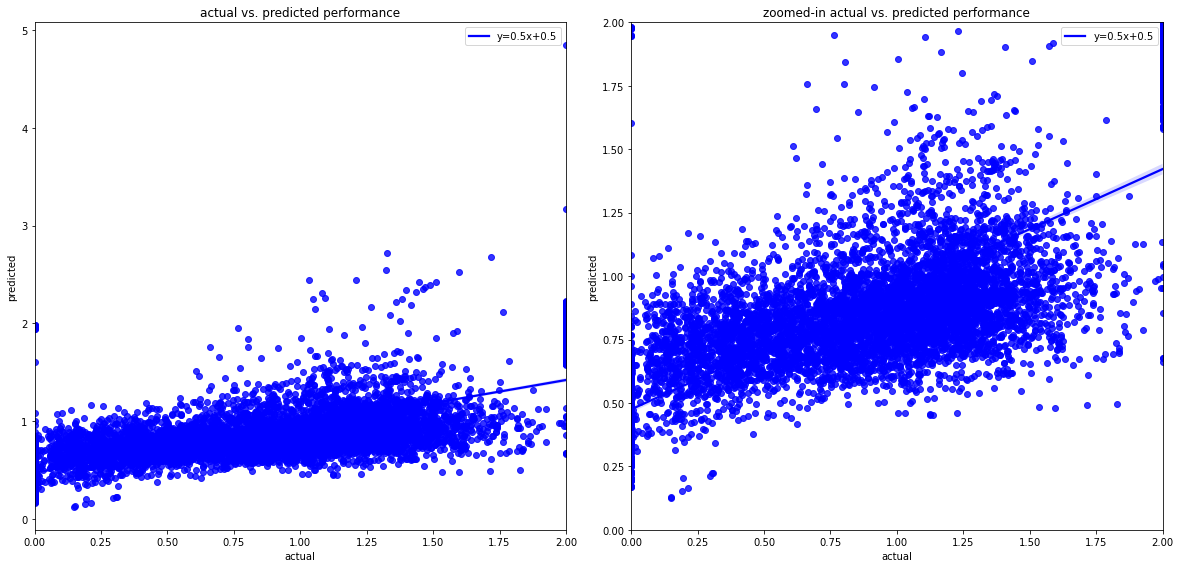

In [242]:
# get coefs of linear fit
s, i, r, p, se = stats.linregress(test_y_test, test_model.predict(test_X_test_scaled))

fig, (ax1, ax2) = plt.subplots(ncols = 2)

sns.regplot(x = 'actual', y = 'predicted', data = df_prediction, color='b', \
line_kws={'label':"y={0:.1f}x+{1:.1f}".format(s, i)}, ax = ax1).legend()
ax1.set_title('actual vs. predicted performance')

sns.regplot(x = 'actual', y = 'predicted', data = df_prediction, color='b', \
line_kws={'label':"y={0:.1f}x+{1:.1f}".format(s, i)}, ax = ax2).legend()
ax2.set_ylim(0, 2)
ax2.set_title('zoomed-in actual vs. predicted performance')

plt.tight_layout(rect = (0, 0, 1.1, 1))

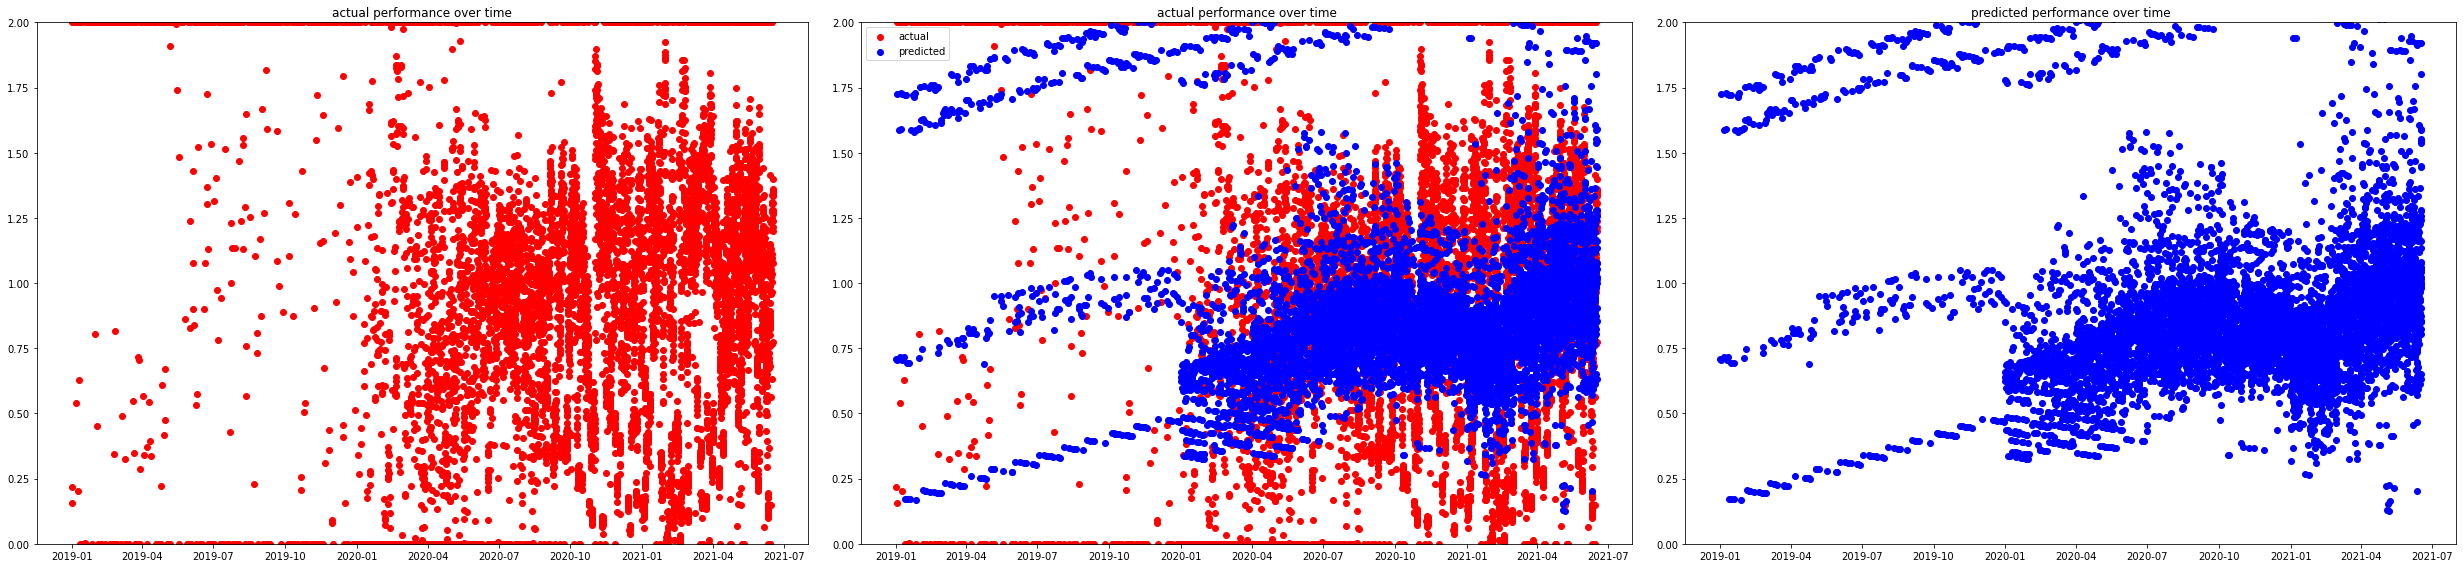

In [248]:
fig, axs = plt.subplots(1, 3)

axs[0].scatter(df_prediction['date'], df_prediction['actual'], color = 'r')
axs[0].set_title(f'actual performance over time')
axs[0].set_ylim(0, 2)

axs[2].scatter(df_prediction['date'], df_prediction['predicted'], color = 'b')
axs[2].set_title(f'predicted performance over time')
axs[2].set_ylim(0, 2)

axs[1].scatter(df_prediction['date'], df_prediction['actual'], color = 'r')
axs[1].scatter(df_prediction['date'], df_prediction['predicted'], color = 'b')
axs[1].set_title(f'actual performance over time')
axs[1].legend(['actual', 'predicted'])
axs[1].set_ylim(0, 2)

plt.tight_layout(rect = (0, 0, 2.3, 1))

## 5 Evaluation

### Sections

#### 5.1 Results
Summarize the results of the previous step in business terms - how well were your business objective(s) met? Models that meet business success criteria become approved models. 

#### 5.2 Summary
After selecting appropriate models, review the work accomplished. Make sure models were correctly built, no important factors or tasks were overlooked, and all data are accessible/replicable for future analyses. 

#### 5.3 Next Steps
Depending on assessed results, decide next steps, whether to move on to deployment, initiate further iterations, or move on to new data mining projects.

From a business perspective, a thorough analysis of given solar system statistics was conducted to determine which factors might impact performance (and, accordingly, production). This analysis includes graphs showing the  size and growth of the solar fleet, average system performance, a distribution of performance for each system, etc. Further, we highlight potential sources of loss, from low production to non-comms to weather-related loss and analyze how often and how long these issues persist. We also analyze the completeness and accuracy of the data given, from comparing the mount of data obtained per contract against its age to self-calculating yield and degradation and comparing to given metrics. We found more accurate individualized values for yield and degradation compared to the ones provided. We also concluded that the month during which a system is created (whether we measure by ato month or in service month) does not have a significant impact on system performance. 

Throughout, we found a number of faulty data which led us to create an anomaly detection model. This model certainly does not detect all of the anomalies we labelled given business knowledge, but it does capture at least obvious anomalies quite accurately and can help auto-detect anomalies in future data. Finally, throughout this analyses, performance was broken down by each predictor variable and significance testing was conducted to determine whether or not each might have a significant impact on performance. Those variables which were both statistically and practically significant were collected as predictors for a linear regression model used to predict performance. This model is not perfect in terms of predictive power, but it does have a test $r^2$ value of 0.48, which indicates a reasonable predictive power (in fact, higher than the $r^2$ obtained on the training set). 

In terms of next steps, we may want to modify the tuning of the anomaly detection algorithm and bias it towards catching more or less anomalies based on business needs. For example, as a business, we may determins that we care more about catching as many potential anomalies as possible instead of worrying too much about wrongly catching non-anomalous data and labeling it anomalous. In this case, instad of using a basic f1 score that's balanced between precision and recall, we might want to bias the model towards recall (change the metric by which we tune). We could also look into other methods of making our anomaly detection model better. We could also vary the features on our predictive performance model to see if there's a way to achieve a higher $r^2$ score. Finally, it could be useful to create a whole new time-series model predicting production as opposed to performance.

# 6 Deployment
## 6.1 Deployment Plan
Develop a plan for deploying relevant model(s). 
## 6.2 Monitoring Plan
Further develop a monitoring and maintenance plan to ensure correct usage of data mining results and avoid issues during the operational phase of model(s). 
## 6.3 Conduct Retrospective
Summarize results, conclusions and deliverables. Conduct any necessary retrospective analysis of what went well, what could be improved, and general experience documentation.